In [1]:
import pandas as pd
import glob
import shutil
import numpy as np
from sklearn.decomposition import DictionaryLearning
from sklearn.cluster import KMeans
from sklearn.metrics import rand_score, adjusted_rand_score

def get_clipp_acc(datafile):

   df = pd.read_csv(datafile, sep='\t')
   dfs_by_region = {region: data for region, data in df.groupby('region')}
   n = int(len(df) / len(dfs_by_region))
    # Create an empty matrix of zeros
   matrix = np.zeros((n, n), dtype=int)
    # Assuming dfs_by_region is already defined and contains the DataFrame split by region
   df = pd.read_csv(datafile, sep='\t')
   dfs_by_region = {region: data for region, data in df.groupby('region')}

   df = dfs_by_region['R1']

   # Create df1 with mutation, ref_counts, and alt_counts
   df1 = df[['mutation', 'ref_counts', 'alt_counts']].copy()
   df1['alt_counts'] = df1['alt_counts'].replace(0, 1)
   df1['mutation'] = [1 for i in range(1, len(df1) + 1)]
   df1.rename(columns={
      'ref_counts': 'ref_count',
      'alt_counts': 'alt_count'
   }, inplace=True)
   df1.rename(columns={'mutation': 'chromosome_index'}, inplace=True)
   df1['position'] = [5 * i + 2 for i in range(1, len(df1) + 1)]
   df1 = df1[['chromosome_index', 'position', 'alt_count', 'ref_count']]
   df1.to_csv('sample_snv.txt', sep='\t', index=False)

   # Create df2 with mutation, major_cn, minor_cn, and sum_cn
   df2 = df[['mutation', 'major_cn', 'minor_cn']].copy()
   df2['mutation'] =[1 for i in range(1, len(df2) + 1)]
   df2['total_cn'] = df2['major_cn'] + df2['minor_cn']
   df2.rename(columns={'mutation': 'chromosome_index'}, inplace=True)
   df2['start_position'] = [5 * i + 1 for i in range(1, len(df2) + 1)]
   df2['end_position'] = [5 * i + 4 for i in range(1, len(df2) + 1)]
   df2 = df2[['chromosome_index', 'start_position', 'end_position', 'major_cn', 'minor_cn', 'total_cn']]

   df2.to_csv('sample_cna.txt', sep='\t', index=False)

   # Get the first element of the 'tumour_purity' column
   purity = df['tumour_purity'].iloc[0]

   # Open a file in write mode and save the number
   with open('sample_purity.txt', 'w') as file:
      file.write(str(purity))
      
   !docker run -v $(pwd):/Sample clipp python3 /CliPP/run_clipp_main.py -i /Sample/test /Sample/sample_snv.txt /Sample/sample_cna.txt /Sample/sample_purity.txt

   file = glob.glob('test/final_result/Best_lambda/*mutation_assignments*')
   df = pd.read_csv(file[0], sep='\t')
   cluster_index = df['cluster_index'].values

   # Fill the matrix
   for i in range(n):
      for j in range(n):
         if cluster_index[i] == cluster_index[j]:
               matrix[i, j] += 1
   shutil.rmtree('test')
   
   
   # Assuming dfs_by_region is already defined and contains the DataFrame split by region
   df = pd.read_csv(datafile, sep='\t')
   dfs_by_region = {region: data for region, data in df.groupby('region')}

   df = dfs_by_region['R2']

   # Create df1 with mutation, ref_counts, and alt_counts
   df1 = df[['mutation', 'ref_counts', 'alt_counts']].copy()
   df1['alt_counts'] = df1['alt_counts'].replace(0, 1)
   df1['mutation'] = [1 for i in range(1, len(df1) + 1)]
   df1.rename(columns={
      'ref_counts': 'ref_count',
      'alt_counts': 'alt_count'
   }, inplace=True)
   df1.rename(columns={'mutation': 'chromosome_index'}, inplace=True)
   df1['position'] = [5 * i + 2 for i in range(1, len(df1) + 1)]
   df1 = df1[['chromosome_index', 'position', 'alt_count', 'ref_count']]
   df1.to_csv('sample_snv.txt', sep='\t', index=False)

   # Create df2 with mutation, major_cn, minor_cn, and sum_cn
   df2 = df[['mutation', 'major_cn', 'minor_cn']].copy()
   df2['mutation'] =[1 for i in range(1, len(df2) + 1)]
   df2['total_cn'] = df2['major_cn'] + df2['minor_cn']
   df2.rename(columns={'mutation': 'chromosome_index'}, inplace=True)
   df2['start_position'] = [5 * i + 1 for i in range(1, len(df2) + 1)]
   df2['end_position'] = [5 * i + 4 for i in range(1, len(df2) + 1)]
   df2 = df2[['chromosome_index', 'start_position', 'end_position', 'major_cn', 'minor_cn', 'total_cn']]

   df2.to_csv('sample_cna.txt', sep='\t', index=False)

   # Get the first element of the 'tumour_purity' column
   purity = df['tumour_purity'].iloc[0]

   # Open a file in write mode and save the number
   with open('sample_purity.txt', 'w') as file:
      file.write(str(purity))
      
   !docker run -v $(pwd):/Sample clipp python3 /CliPP/run_clipp_main.py -i /Sample/test /Sample/sample_snv.txt /Sample/sample_cna.txt /Sample/sample_purity.txt

   file = glob.glob('test/final_result/Best_lambda/*mutation_assignments*')
   df = pd.read_csv(file[0], sep='\t')
   cluster_index = df['cluster_index'].values

   # Fill the matrix
   for i in range(n):
      for j in range(n):
         if cluster_index[i] == cluster_index[j]:
               matrix[i, j] += 1
   shutil.rmtree('test')
   
   matrix = matrix / 2
   
   n_components_values = range(1, 21)

   # Regularization parameter for sparsity
   alpha = 1.0

   # Initialize variables to store the best results
   best_n_components = None
   best_reconstruction_error = np.inf
   best_A = None
   best_D = None

   # Perform dictionary learning for different values of n_components
   reconstruction_errors = []
   for n_components in n_components_values:
      dict_learner = DictionaryLearning(n_components=n_components, alpha=alpha, fit_algorithm='lars', transform_algorithm='lars')
      A = dict_learner.fit_transform(matrix)  # Sparse code matrix
      D = dict_learner.components_            # Dictionary matrix
      
      # Calculate the reconstruction error
      reconstruction = np.dot(A, D)
      reconstruction_error = np.linalg.norm(matrix - reconstruction)
      reconstruction_errors.append(reconstruction_error)
      
      # Check if this is the best result so far
      if reconstruction_error < best_reconstruction_error:
         best_n_components = n_components
         best_reconstruction_error = reconstruction_error
         best_A = A
         best_D = D
         
   A = best_A
   
   k_values = range(2, 11)

   # Initialize variables to store the best results
   best_k = None
   best_inertia = np.inf
   best_labels = None
   best_centers = None

   # Perform k-means clustering for different values of k
   for k in k_values:
      kmeans = KMeans(n_clusters=k, random_state=0).fit(A)
      inertia = kmeans.inertia_
      
      # Check if this is the best result so far
      if inertia < best_inertia:
         best_k = k
         best_inertia = inertia
         best_labels = kmeans.labels_
         best_centers = kmeans.cluster_centers_
   
   df = pd.read_csv(datafile, sep='\t')
   m = len(np.unique(df['region']))
   n = int(len(df) / m)
   group = np.zeros(n)
   for i in range(n):
      group[i] = int(df['cluster'][i * m])
   acc = adjusted_rand_score(group, best_labels)
   return acc

In [2]:
import numpy as np
res1 = np.zeros([100, 3])
for kk in range(100):
    !python clipp_data_simulation.py
    datafile = 'multi_clipp_simulation_data/simulation_data_cluster_5_region_2_read_depth_100_replica_2.tsv'
    from helper import *
    from sklearn.metrics import rand_score
    df = pd.read_csv(datafile, sep="\t")
    change_df_to_pyclonevi(df)
    !pyclone-vi fit -i pyclonevi_input.tsv -o pyclonevi_intemediate_output.h5 -c 40 -d beta-binomial -r 10
    !pyclone-vi write-results-file -i pyclonevi_intemediate_output.h5 -o pyclonevi_output.tsv
    df = pd.read_csv("pyclonevi_output.tsv", sep="\t")
    mutation_to_cluster = df.set_index('mutation_id')['cluster_id'].to_dict()
    mutation_to_cluster = dict(sorted(mutation_to_cluster.items()))
    df = pd.read_csv(datafile, sep="\t")
    mutation_to_cluster2 = df.set_index('mutation')['cluster'].to_dict()
    mutation_to_cluster2 = dict(sorted(mutation_to_cluster2.items()))
    from sklearn.metrics import adjusted_rand_score
    res1[kk, 0] = adjusted_rand_score(list(mutation_to_cluster.values()), list(mutation_to_cluster2.values()))
    
    from snv2 import *
    import pandas as pd
    from helper import *
    from sklearn.metrics import rand_score, adjusted_rand_score
    df = pd.read_csv(datafile, sep="\t")
    m = len(np.unique(df['region']))
    n = int(len(df) / m)
    rho = 0.2
    omega = 1
    max_iteration = 20
    gamma = [0.05 + 0.002 * i for i in range(56)]
    ray.shutdown()
    ray.init
    res = [ADMM.remote(df, rho, gamma[i], omega, n, m, max_iteration) for i in range(len(gamma))]
    res = ray.get(res)
    ray.shutdown()

    group = np.zeros(n)
    acc = np.zeros(len(gamma))
    for i in range(n):
        group[i] = int(df['cluster'][i * m])
    for i in range(len(gamma)):
        acc[i] = adjusted_rand_score(res[i][7], group)
    res1[kk, 1] = max(acc)
    
    try:
        res1[kk, 2] = get_clipp_acc(datafile)
    except:
        res1[kk, 2] = 0

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

Num Samples: 2
Samples: R1 R2
Num mutations: 100
Performing restart 0
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -17547.453369320745
Number of clusters used: 37

Fitting completed
ELBO: -650.846375642099
Number of clusters used: 5

Performing restart 1
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -30764.453765685674
Number of clusters used: 37

Fitting completed
ELBO: -643.8641831054433
Number of clusters used: 6

Performing restart 2
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -28869.952058062503
Number of clusters used: 37

Fitting completed
ELBO: -650.8465057231316
Number of clusters used: 5

Performing restart 3
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -85788.5648531098
Number of clusters used: 38

Fitting completed
ELBO: -650.8463071353311
Number of clusters used: 5

Performing restart 4
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -

2024-12-15 01:06:46,667	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=39476) Gamma: 0.07, clusters : dict_values([0, 1, 2, 3, 4, 5, 4, 7, 4, 9, 0, 11, 12, 13, 14, 7, 16, 17, 18, 7, 20, 21, 7, 0, 7, 7, 26, 17, 7, 7, 30, 20, 32, 33, 34, 7, 7, 26, 17, 39, 40, 41, 7, 43, 2, 39, 17, 47, 21, 49, 7, 51, 7, 53, 2, 7, 12, 0, 7, 7, 20, 61, 5, 63, 7, 7, 7, 4, 0, 69, 70, 71, 39, 73, 74, 7, 76, 77, 17, 18, 34, 81, 82, 7, 63, 20, 14, 17, 88, 7, 77, 88, 92, 7, 88, 7, 26, 5, 7, 7])
(ADMM pid=39476) Gamma: 0.078, clusters : dict_values([0, 1, 2, 3, 4, 5, 4, 7, 4, 9, 0, 11, 12, 13, 14, 7, 16, 12, 18, 7, 20, 21, 7, 0, 7, 7, 26, 12, 7, 7, 30, 20, 32, 33, 34, 7, 7, 26, 12, 39, 40, 41, 7, 43, 2, 39, 12, 47, 21, 49, 7, 51, 7, 53, 2, 7, 12, 0, 7, 7, 20, 61, 5, 1, 7, 7, 7, 4, 0, 69, 70, 18, 39, 73, 74, 7, 76, 2, 12, 18, 80, 21, 82, 7, 1, 20, 14, 12, 88, 7, 2, 88, 92, 7, 88, 7, 26, 5, 7, 7]) [repeated 14x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guide

2024-12-15 01:07:26,698	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=39727) Gamma: 0.064, clusters : dict_values([0, 1, 2, 3, 4, 0, 6, 0, 8, 9, 9, 0, 9, 6, 14, 0, 16, 17, 18, 19, 0, 21, 0, 16, 24, 25, 24, 27, 28, 29, 30, 2, 16, 33, 0, 9, 0, 30, 18, 0, 40, 41, 40, 8, 0, 18, 0, 47, 16, 0, 18, 51, 40, 53, 54, 55, 56, 17, 58, 9, 54, 25, 62, 0, 0, 40, 0, 0, 40, 69, 70, 0, 40, 73, 0, 9, 76, 0, 40, 40, 80, 27, 16, 83, 18, 40, 21, 87, 27, 89, 0, 16, 21, 93, 47, 95, 0, 9, 9, 99])
(ADMM pid=39722) Gamma: 0.084, clusters : dict_values([0, 1, 2, 3, 4, 0, 6, 0, 8, 9, 9, 0, 9, 6, 14, 0, 16, 17, 4, 19, 0, 21, 0, 16, 2, 1, 2, 27, 28, 29, 30, 2, 16, 30, 0, 9, 0, 30, 4, 0, 4, 4, 4, 8, 0, 4, 0, 30, 16, 0, 4, 28, 4, 53, 54, 55, 56, 17, 58, 9, 54, 1, 62, 0, 0, 4, 0, 0, 4, 69, 70, 0, 4, 73, 0, 9, 76, 0, 4, 4, 80, 81, 16, 56, 4, 4, 21, 87, 81, 89, 0, 16, 21, 93, 30, 17, 0, 9, 9, 99]) [repeated 14x across cluster]
(ADMM pid=39722) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 0, 6, 0, 8, 9, 9, 0, 9, 6, 4, 0, 16, 17, 4, 19, 0, 21, 0, 16, 2, 1, 2, 

2024-12-15 01:08:06,434	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=39949) Gamma: 0.054000000000000006, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 6, 6, 8, 13, 14, 15, 6, 6, 18, 19, 20, 13, 6, 23, 24, 25, 26, 27, 9, 26, 30, 31, 32, 31, 34, 26, 36, 6, 38, 39, 40, 13, 42, 13, 13, 45, 46, 2, 13, 49, 13, 39, 52, 15, 54, 55, 56, 57, 58, 59, 13, 61, 6, 55, 25, 6, 55, 20, 68, 69, 70, 71, 72, 73, 74, 75, 7, 13, 13, 52, 13, 14, 70, 83, 84, 55, 14, 87, 13, 89, 13, 91, 25, 93, 19, 18, 13, 97, 2, 99])
(ADMM pid=39949) Gamma: 0.078, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 6, 6, 8, 13, 14, 15, 6, 6, 18, 19, 20, 13, 6, 23, 24, 25, 26, 27, 9, 26, 30, 27, 32, 27, 34, 26, 36, 6, 38, 26, 40, 13, 42, 13, 13, 45, 24, 2, 13, 49, 13, 26, 52, 15, 25, 25, 56, 57, 58, 59, 13, 61, 6, 25, 25, 6, 25, 20, 68, 69, 27, 71, 72, 73, 74, 75, 7, 13, 13, 52, 13, 14, 27, 83, 84, 25, 14, 87, 13, 89, 13, 91, 25, 1, 19, 26, 13, 27, 2, 99]) [repeated 14x across cluster]
(ADMM pid=39949) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 

2024-12-15 01:08:45,528	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=40180) Gamma: 0.068, clusters : dict_values([0, 1, 2, 3, 1, 1, 6, 6, 8, 9, 6, 6, 6, 13, 6, 15, 6, 6, 18, 19, 20, 18, 6, 6, 6, 6, 26, 27, 6, 29, 30, 15, 30, 33, 6, 35, 6, 6, 19, 39, 40, 6, 19, 6, 44, 6, 46, 6, 1, 8, 50, 18, 52, 6, 19, 55, 56, 19, 58, 59, 8, 61, 30, 63, 29, 59, 66, 19, 68, 6, 70, 8, 56, 6, 30, 6, 76, 6, 6, 19, 6, 30, 6, 19, 84, 19, 8, 6, 66, 39, 68, 30, 18, 93, 6, 19, 96, 6, 6, 6])
(ADMM pid=40180) Gamma: 0.078, clusters : dict_values([0, 1, 2, 3, 1, 1, 6, 6, 8, 9, 6, 6, 6, 13, 6, 15, 6, 6, 18, 6, 20, 18, 6, 6, 6, 6, 26, 0, 6, 29, 30, 15, 30, 33, 6, 35, 6, 6, 6, 39, 9, 6, 6, 6, 44, 6, 46, 6, 1, 8, 39, 18, 52, 6, 6, 55, 56, 6, 58, 59, 8, 61, 30, 63, 29, 59, 66, 6, 68, 6, 70, 8, 56, 6, 30, 6, 76, 6, 6, 6, 6, 30, 6, 6, 84, 6, 68, 6, 66, 39, 68, 30, 18, 93, 6, 6, 93, 6, 6, 6]) [repeated 14x across cluster]
(ADMM pid=40184) Gamma: 0.10800000000000001, clusters : dict_values([0, 1, 2, 3, 1, 1, 0, 0, 1, 9, 0, 0, 0, 13, 0, 15, 0, 0, 18, 0, 20, 18, 0, 0, 0, 0, 26, 0, 0,

2024-12-15 01:09:25,557	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=40423) Gamma: 0.07600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 5, 18, 19, 5, 21, 5, 9, 24, 25, 26, 27, 28, 29, 9, 1, 32, 33, 9, 35, 9, 37, 9, 33, 40, 41, 33, 43, 1, 33, 13, 13, 33, 33, 9, 51, 4, 4, 33, 55, 56, 0, 0, 0, 18, 13, 8, 63, 37, 4, 25, 13, 9, 69, 40, 71, 72, 9, 74, 10, 76, 77, 9, 33, 80, 13, 9, 0, 0, 9, 33, 37, 10, 89, 9, 33, 9, 33, 32, 95, 1, 5, 40, 99])
(ADMM pid=40433) Gamma: 0.08, clusters : dict_values([0, 1, 2, 3, 4, 3, 6, 4, 8, 9, 10, 11, 12, 13, 14, 15, 16, 3, 18, 19, 3, 21, 3, 9, 24, 25, 26, 27, 28, 29, 9, 1, 32, 33, 9, 35, 9, 1, 9, 33, 40, 41, 33, 43, 1, 33, 13, 13, 33, 33, 9, 51, 4, 4, 33, 55, 56, 0, 0, 0, 18, 13, 8, 63, 1, 4, 25, 13, 9, 69, 40, 71, 72, 9, 74, 10, 76, 77, 9, 33, 80, 13, 9, 0, 0, 9, 33, 1, 10, 89, 9, 33, 9, 33, 32, 95, 1, 33, 40, 28]) [repeated 14x across cluster]
(ADMM pid=40433) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 3, 6, 4, 8, 9, 4, 11, 12, 13, 14, 15, 16,

2024-12-15 01:10:06,652	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=40706) Gamma: 0.07400000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 9, 12, 2, 14, 9, 16, 17, 1, 19, 20, 21, 22, 23, 24, 20, 2, 23, 28, 29, 2, 12, 32, 33, 12, 32, 36, 7, 38, 14, 32, 41, 42, 2, 44, 21, 22, 47, 2, 32, 32, 32, 52, 3, 32, 55, 8, 57, 57, 59, 60, 32, 3, 8, 64, 65, 66, 23, 23, 69, 32, 10, 1, 3, 32, 32, 76, 21, 78, 32, 6, 29, 32, 32, 3, 21, 38, 47, 3, 89, 36, 91, 32, 78, 9, 32, 36, 23, 65, 32])
(ADMM pid=40702) Gamma: 0.08, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 9, 12, 2, 14, 9, 16, 17, 1, 19, 20, 21, 22, 23, 24, 20, 2, 23, 28, 29, 2, 12, 32, 33, 12, 32, 36, 7, 38, 14, 32, 41, 42, 2, 44, 21, 22, 47, 2, 32, 32, 32, 52, 3, 32, 55, 8, 32, 32, 59, 60, 32, 3, 8, 64, 9, 66, 23, 23, 42, 32, 10, 1, 3, 32, 32, 76, 21, 14, 32, 6, 29, 32, 32, 3, 21, 38, 47, 3, 89, 36, 42, 32, 14, 9, 32, 36, 23, 9, 32]) [repeated 14x across cluster]
(ADMM pid=40702) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 0, 3, 4, 5, 6, 7, 8, 5, 10, 5,

2024-12-15 01:10:48,662	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=40997) Gamma: 0.05, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 6, 9, 10, 11, 12, 13, 14, 15, 16, 10, 12, 2, 1, 21, 22, 23, 24, 25, 26, 27, 28, 29, 10, 12, 32, 33, 34, 35, 12, 37, 38, 35, 40, 35, 2, 43, 2, 15, 24, 32, 29, 49, 50, 24, 3, 35, 29, 12, 25, 25, 2, 9, 60, 35, 62, 63, 2, 35, 66, 67, 10, 11, 70, 71, 29, 73, 38, 75, 3, 29, 78, 70, 14, 12, 71, 24, 24, 25, 49, 67, 88, 29, 88, 37, 13, 10, 2, 71, 25, 2, 98, 25])
(ADMM pid=40997) Gamma: 0.078, clusters : dict_values([0, 1, 2, 3, 4, 2, 6, 7, 6, 9, 4, 11, 12, 13, 14, 15, 16, 4, 14, 2, 1, 21, 22, 11, 24, 25, 26, 27, 28, 29, 4, 14, 28, 33, 34, 35, 14, 37, 38, 35, 38, 35, 2, 43, 2, 15, 24, 28, 29, 49, 2, 28, 6, 35, 29, 14, 25, 14, 2, 9, 60, 35, 62, 63, 2, 35, 66, 67, 4, 2, 70, 71, 29, 9, 38, 27, 6, 29, 78, 70, 14, 67, 71, 28, 28, 67, 49, 67, 2, 29, 2, 67, 13, 4, 2, 71, 14, 2, 98, 25]) [repeated 14x across cluster]
(ADMM pid=40997) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 2, 3, 7, 3, 9, 4, 2, 12, 13

2024-12-15 01:11:26,573	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=41270) Gamma: 0.058, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 0, 8, 9, 0, 11, 12, 3, 14, 15, 16, 1, 12, 19, 20, 21, 22, 23, 24, 25, 26, 21, 11, 0, 0, 1, 2, 1, 1, 35, 8, 1, 0, 39, 40, 0, 0, 43, 44, 0, 46, 47, 0, 0, 47, 51, 52, 21, 26, 55, 23, 57, 4, 52, 0, 61, 47, 63, 64, 65, 46, 67, 63, 47, 21, 2, 16, 73, 26, 75, 46, 77, 2, 26, 47, 81, 26, 14, 84, 67, 14, 57, 52, 77, 1, 91, 61, 84, 0, 46, 1, 67, 98, 1])
(ADMM pid=41267) Gamma: 0.078, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 0, 8, 9, 0, 11, 12, 3, 14, 15, 16, 1, 3, 19, 20, 21, 2, 23, 2, 25, 3, 21, 11, 0, 0, 1, 2, 1, 1, 35, 8, 1, 0, 39, 40, 0, 0, 43, 44, 0, 46, 47, 0, 0, 47, 51, 52, 21, 3, 55, 1, 57, 4, 52, 0, 61, 47, 1, 64, 65, 46, 67, 1, 47, 21, 2, 16, 73, 3, 75, 46, 77, 2, 3, 47, 81, 3, 14, 84, 67, 14, 84, 52, 77, 1, 91, 61, 84, 0, 46, 1, 67, 98, 1]) [repeated 14x across cluster]
(ADMM pid=41267) Gamma: 0.10800000000000001, clusters : dict_values([0, 0, 2, 3, 4, 5, 2, 0, 8, 9, 0, 11, 12, 3, 14, 15, 16, 0, 3, 19, 16, 

2024-12-15 01:12:05,490	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=41513) Gamma: 0.066, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 0, 8, 9, 5, 11, 12, 13, 5, 9, 16, 17, 18, 19, 20, 21, 22, 9, 24, 25, 2, 19, 0, 29, 30, 5, 32, 0, 34, 0, 36, 37, 4, 39, 40, 41, 0, 0, 9, 45, 37, 36, 34, 0, 5, 37, 37, 53, 54, 36, 19, 36, 19, 9, 36, 4, 0, 63, 64, 65, 66, 9, 45, 69, 70, 1, 9, 73, 74, 36, 70, 19, 0, 53, 45, 9, 16, 0, 84, 84, 36, 37, 9, 19, 9, 91, 92, 93, 36, 37, 96, 97, 0, 37])
(ADMM pid=41509) Gamma: 0.08, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 0, 8, 9, 5, 11, 12, 13, 5, 9, 16, 17, 18, 19, 20, 6, 22, 9, 24, 8, 2, 19, 0, 29, 30, 5, 32, 0, 9, 0, 36, 37, 4, 32, 40, 41, 0, 0, 9, 45, 37, 36, 9, 0, 5, 37, 37, 53, 54, 36, 19, 36, 19, 9, 36, 4, 0, 63, 3, 65, 66, 9, 68, 69, 70, 1, 9, 17, 74, 36, 70, 19, 0, 53, 17, 9, 16, 0, 84, 84, 36, 37, 9, 19, 9, 91, 92, 93, 36, 37, 96, 97, 0, 37]) [repeated 14x across cluster]
(ADMM pid=41509) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 0, 8, 9, 5, 11, 12, 13, 5, 9, 16, 17, 18, 19, 20

2024-12-15 01:12:44,825	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=41793) Gamma: 0.07600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 7, 6, 11, 0, 13, 3, 15, 0, 17, 0, 13, 8, 13, 1, 23, 24, 25, 26, 8, 4, 29, 30, 31, 29, 33, 34, 1, 13, 4, 29, 33, 30, 6, 13, 4, 44, 6, 8, 13, 48, 13, 13, 8, 13, 53, 54, 0, 8, 29, 8, 8, 1, 8, 8, 63, 8, 65, 66, 67, 13, 69, 30, 8, 72, 66, 11, 11, 23, 13, 26, 79, 1, 81, 72, 81, 84, 85, 72, 87, 88, 89, 13, 8, 63, 1, 94, 13, 81, 13, 13, 3])
(ADMM pid=41805) Gamma: 0.082, clusters : dict_values([0, 0, 2, 3, 4, 5, 6, 7, 8, 7, 6, 11, 0, 13, 3, 15, 0, 17, 0, 13, 8, 13, 0, 23, 24, 25, 26, 8, 4, 29, 30, 31, 29, 33, 34, 0, 13, 4, 29, 33, 30, 6, 13, 4, 44, 6, 8, 13, 48, 13, 13, 8, 13, 53, 54, 0, 8, 29, 8, 8, 0, 8, 8, 63, 8, 65, 66, 67, 13, 69, 30, 8, 72, 66, 11, 11, 23, 13, 26, 79, 0, 81, 72, 81, 84, 85, 72, 72, 88, 89, 13, 8, 63, 0, 94, 13, 81, 13, 13, 3]) [repeated 14x across cluster]
(ADMM pid=41797) Gamma: 0.12000000000000001, clusters : dict_values([0, 0, 2, 3, 4, 5, 6, 7, 4, 4, 6, 11, 0, 13, 3, 11, 0,

/Users/yuding/miniforge3/envs/ml1/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

Num Samples: 2
Samples: R1 R2
Num mutations: 100
Performing restart 0
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -13813.93399578616
Number of clusters used: 37

Fitting completed
ELBO: -705.1721618867331
Number of clusters used: 6

Performing restart 1
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -50653.07565776844
Number of clusters used: 38

Fitting completed
ELBO: -740.0675337028192
Number of clusters used: 5

Performing restart 2
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -25457.94316637575
Number of clusters used: 38

Fitting completed
ELBO: -746.1945055671999
Number of clusters used: 4

Performing restart 3
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -19909.06206800894
Number of clusters used: 37

Fitting completed
ELBO: -717.5226230402186
Number of clusters used: 5

Performing restart 4
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -3

2024-12-15 01:13:22,363	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=42023) Gamma: 0.060000000000000005, clusters : dict_values([0, 1, 2, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 10, 15, 9, 17, 18, 19, 20, 21, 22, 23, 2, 8, 26, 18, 28, 29, 30, 4, 32, 33, 9, 10, 9, 37, 38, 26, 26, 29, 22, 43, 26, 30, 9, 47, 30, 49, 50, 51, 9, 4, 54, 19, 2, 57, 58, 59, 6, 9, 2, 63, 51, 18, 66, 2, 9, 66, 66, 6, 2, 19, 74, 0, 76, 77, 78, 50, 80, 6, 66, 83, 2, 9, 86, 87, 88, 66, 19, 91, 92, 83, 88, 66, 96, 97, 4, 99])
(ADMM pid=42023) Gamma: 0.078, clusters : dict_values([0, 1, 2, 2, 4, 5, 6, 7, 8, 4, 10, 11, 12, 13, 10, 15, 4, 17, 0, 19, 20, 21, 22, 23, 2, 25, 6, 0, 28, 13, 1, 2, 32, 33, 4, 10, 4, 37, 38, 6, 6, 13, 22, 43, 6, 1, 4, 47, 1, 49, 50, 51, 4, 2, 54, 19, 2, 21, 58, 59, 6, 4, 2, 63, 51, 0, 1, 2, 4, 1, 1, 6, 2, 8, 74, 0, 76, 77, 78, 50, 1, 6, 1, 83, 2, 4, 86, 87, 88, 1, 19, 7, 92, 83, 88, 1, 96, 97, 2, 99]) [repeated 14x across cluster]
(ADMM pid=42023) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 2, 2, 5, 6, 7, 8, 2, 10, 11, 12, 13, 10, 15, 2,

2024-12-15 01:14:01,284	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=42276) Gamma: 0.064, clusters : dict_values([0, 1, 2, 3, 1, 5, 6, 7, 8, 9, 10, 11, 12, 7, 1, 11, 12, 5, 18, 19, 20, 3, 22, 23, 24, 25, 26, 24, 28, 11, 30, 3, 12, 33, 28, 9, 28, 28, 12, 12, 9, 41, 1, 43, 43, 45, 46, 24, 10, 8, 8, 28, 52, 5, 23, 12, 56, 3, 7, 59, 30, 1, 11, 0, 1, 22, 3, 1, 9, 28, 23, 18, 19, 73, 74, 24, 22, 77, 24, 1, 8, 1, 19, 22, 46, 22, 24, 52, 88, 9, 22, 91, 92, 93, 1, 8, 96, 56, 28, 8])
(ADMM pid=42276) Gamma: 0.078, clusters : dict_values([0, 1, 2, 3, 1, 5, 6, 7, 8, 9, 10, 11, 12, 7, 1, 11, 12, 5, 18, 19, 20, 3, 22, 23, 7, 25, 26, 7, 28, 11, 30, 3, 12, 33, 28, 9, 28, 28, 12, 12, 9, 41, 1, 43, 43, 45, 20, 7, 10, 7, 7, 28, 52, 12, 23, 12, 56, 3, 7, 43, 30, 1, 11, 0, 1, 22, 3, 1, 9, 28, 23, 18, 19, 7, 74, 7, 22, 77, 7, 1, 7, 1, 19, 22, 20, 22, 7, 52, 88, 1, 22, 91, 92, 93, 1, 7, 96, 56, 28, 7]) [repeated 14x across cluster]
(ADMM pid=42267) Gamma: 0.116, clusters : dict_values([0, 1, 2, 0, 1, 2, 6, 1, 1, 1, 10, 2, 2, 1, 1, 2, 2, 2, 18, 2, 1, 0, 22, 23, 1, 25

2024-12-15 01:14:40,241	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=42498) Gamma: 0.056, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 4, 15, 13, 13, 1, 6, 20, 21, 22, 23, 24, 25, 26, 27, 1, 29, 13, 3, 13, 33, 34, 35, 35, 13, 35, 39, 1, 41, 13, 13, 44, 13, 1, 47, 1, 13, 1, 51, 52, 13, 54, 44, 56, 33, 58, 25, 60, 61, 62, 63, 13, 58, 25, 54, 13, 13, 21, 25, 72, 13, 74, 75, 61, 1, 78, 79, 9, 13, 13, 1, 84, 13, 86, 13, 75, 56, 47, 91, 92, 25, 9, 95, 13, 56, 98, 99])
(ADMM pid=42498) Gamma: 0.078, clusters : dict_values([0, 0, 2, 3, 4, 5, 6, 7, 8, 4, 10, 2, 12, 13, 4, 15, 13, 13, 0, 6, 20, 21, 22, 23, 24, 7, 26, 27, 6, 29, 13, 3, 13, 33, 8, 35, 35, 13, 35, 39, 35, 41, 13, 13, 44, 13, 35, 47, 35, 13, 35, 51, 52, 13, 54, 44, 41, 33, 58, 7, 58, 33, 62, 62, 13, 58, 7, 54, 13, 13, 21, 7, 39, 13, 58, 13, 33, 35, 78, 79, 4, 13, 13, 35, 13, 35, 86, 13, 35, 62, 47, 15, 92, 7, 4, 95, 35, 62, 41, 41]) [repeated 14x across cluster]
(ADMM pid=42508) Gamma: 0.10800000000000001, clusters : dict_values([0, 0, 2, 3, 4, 5, 0, 7, 8, 4, 10, 2,

2024-12-15 01:15:19,382	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=42746) Gamma: 0.052000000000000005, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 2, 5, 12, 13, 13, 13, 8, 4, 18, 5, 20, 13, 22, 2, 24, 3, 5, 22, 28, 13, 2, 31, 32, 8, 9, 8, 36, 18, 5, 39, 18, 8, 42, 36, 44, 18, 46, 44, 31, 18, 50, 39, 2, 13, 5, 55, 56, 57, 8, 59, 13, 8, 59, 5, 20, 4, 13, 8, 44, 1, 5, 36, 5, 44, 36, 2, 76, 8, 36, 79, 18, 5, 44, 44, 5, 5, 5, 55, 8, 5, 90, 36, 44, 93, 36, 5, 36, 5, 98, 5])
(ADMM pid=42736) Gamma: 0.096, clusters : dict_values([0, 1, 2, 3, 4, 0, 6, 7, 8, 9, 2, 0, 12, 13, 13, 13, 8, 9, 18, 0, 20, 13, 18, 2, 24, 3, 0, 18, 28, 13, 2, 31, 32, 8, 9, 8, 9, 13, 0, 9, 13, 8, 42, 9, 2, 13, 46, 2, 31, 13, 50, 31, 2, 13, 0, 55, 3, 18, 8, 18, 13, 8, 18, 0, 18, 9, 13, 8, 2, 1, 0, 9, 0, 2, 9, 2, 2, 2, 9, 31, 13, 0, 0, 0, 0, 0, 0, 55, 2, 0, 46, 9, 0, 93, 9, 0, 9, 0, 98, 0]) [repeated 14x across cluster]
(ADMM pid=42736) Gamma: 0.10800000000000001, clusters : dict_values([0, 1, 2, 3, 4, 0, 6, 7, 2, 9, 2, 0, 12, 13, 13, 13, 2, 9, 18, 0, 20, 13, 18, 2, 24

/Users/yuding/miniforge3/envs/ml1/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

Num Samples: 2
Samples: R1 R2
Num mutations: 100
Performing restart 0
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -20751.93943402455
Number of clusters used: 36

Fitting completed
ELBO: -702.362982028772
Number of clusters used: 4

Performing restart 1
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -31275.43333275521
Number of clusters used: 35

Fitting completed
ELBO: -702.3629846650088
Number of clusters used: 4

Performing restart 2
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -389797.40477909375
Number of clusters used: 38

Fitting completed
ELBO: -713.9241093978023
Number of clusters used: 4

Performing restart 3
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -14295.458155611694
Number of clusters used: 36

Fitting completed
ELBO: -695.2010695393021
Number of clusters used: 5

Performing restart 4
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -

2024-12-15 01:15:57,290	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=43030) Gamma: 0.058, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 9, 12, 13, 3, 3, 16, 17, 16, 19, 20, 21, 13, 19, 9, 6, 26, 27, 13, 9, 30, 5, 3, 4, 7, 35, 3, 37, 3, 9, 26, 41, 7, 13, 2, 45, 3, 7, 48, 49, 3, 9, 26, 0, 7, 16, 9, 48, 7, 19, 12, 26, 62, 63, 9, 3, 66, 13, 9, 13, 3, 66, 30, 63, 7, 75, 76, 0, 78, 27, 7, 81, 7, 63, 0, 3, 66, 3, 9, 13, 9, 7, 7, 93, 9, 95, 26, 97, 63, 0])
(ADMM pid=43025) Gamma: 0.08, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 9, 12, 4, 3, 3, 16, 17, 16, 19, 8, 21, 4, 19, 9, 6, 7, 3, 4, 9, 30, 5, 3, 4, 5, 35, 3, 37, 3, 9, 7, 41, 17, 4, 2, 45, 3, 17, 48, 49, 3, 9, 7, 0, 5, 16, 9, 48, 5, 19, 12, 7, 62, 63, 9, 3, 9, 4, 3, 4, 3, 9, 30, 63, 5, 75, 76, 0, 78, 35, 5, 1, 5, 63, 0, 3, 3, 3, 9, 4, 9, 5, 5, 35, 9, 5, 7, 48, 63, 0]) [repeated 14x across cluster]
(ADMM pid=43025) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 4, 3, 3, 16, 7, 16, 19, 8, 21, 4, 19, 9, 6, 7, 3, 4, 9, 30, 7, 3,

2024-12-15 01:16:35,501	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=43281) Gamma: 0.056, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 11, 6, 16, 16, 18, 19, 2, 21, 6, 23, 12, 18, 12, 27, 28, 29, 12, 31, 12, 6, 7, 35, 11, 19, 12, 6, 40, 11, 16, 21, 44, 45, 46, 12, 5, 49, 27, 11, 52, 11, 12, 31, 6, 57, 2, 44, 60, 61, 44, 23, 64, 12, 6, 18, 12, 12, 21, 23, 72, 49, 74, 7, 16, 77, 11, 6, 29, 6, 64, 83, 64, 77, 86, 61, 6, 89, 12, 91, 92, 60, 64, 95, 96, 97, 6, 99])
(ADMM pid=43279) Gamma: 0.078, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1, 10, 13, 1, 6, 16, 16, 18, 19, 2, 21, 6, 23, 10, 18, 10, 4, 28, 16, 10, 31, 10, 6, 7, 8, 1, 19, 10, 6, 40, 1, 16, 21, 8, 45, 46, 10, 5, 49, 4, 1, 52, 1, 10, 31, 6, 57, 2, 8, 60, 61, 8, 23, 64, 10, 6, 18, 10, 10, 21, 23, 40, 49, 52, 7, 16, 2, 1, 6, 16, 6, 64, 19, 64, 2, 3, 61, 6, 89, 10, 91, 5, 60, 64, 19, 96, 97, 6, 99]) [repeated 14x across cluster]
(ADMM pid=43281) Gamma: 0.10800000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1, 10, 0, 1, 6, 16, 16

/Users/yuding/miniforge3/envs/ml1/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

Num Samples: 2
Samples: R1 R2
Num mutations: 100
Performing restart 0
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -164876.4015041695
Number of clusters used: 37

Fitting completed
ELBO: -808.542590160407
Number of clusters used: 4

Performing restart 1
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -36232.69976027512
Number of clusters used: 37

Fitting completed
ELBO: -752.7596773630012
Number of clusters used: 5

Performing restart 2
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -154311.9765445367
Number of clusters used: 36

Fitting completed
ELBO: -752.7598245944702
Number of clusters used: 5

Performing restart 3
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -145505.0527033148
Number of clusters used: 37

Fitting completed
ELBO: -752.7596040403585
Number of clusters used: 5

Performing restart 4
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -17

2024-12-15 01:17:15,783	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=43527) Gamma: 0.064, clusters : dict_values([0, 1, 1, 3, 4, 5, 6, 6, 8, 6, 10, 11, 12, 6, 14, 15, 16, 17, 18, 19, 6, 21, 22, 23, 24, 6, 26, 27, 28, 29, 30, 17, 32, 33, 33, 11, 36, 37, 24, 39, 12, 41, 8, 5, 44, 6, 46, 29, 3, 49, 50, 51, 52, 4, 54, 55, 6, 44, 58, 59, 30, 61, 4, 29, 6, 6, 6, 67, 4, 51, 70, 6, 8, 39, 29, 75, 8, 4, 39, 6, 80, 8, 6, 26, 80, 85, 3, 36, 6, 89, 24, 6, 92, 6, 70, 11, 96, 97, 14, 99])
(ADMM pid=43527) Gamma: 0.078, clusters : dict_values([0, 1, 1, 3, 4, 5, 6, 6, 8, 6, 10, 11, 12, 6, 14, 15, 16, 17, 18, 19, 6, 21, 22, 23, 24, 6, 26, 27, 28, 29, 30, 17, 4, 33, 33, 11, 36, 37, 24, 39, 12, 41, 8, 5, 1, 6, 46, 29, 3, 49, 50, 15, 52, 4, 54, 16, 6, 1, 33, 59, 30, 61, 4, 29, 6, 6, 6, 67, 23, 15, 70, 6, 72, 39, 29, 19, 72, 4, 39, 6, 80, 8, 6, 26, 80, 85, 3, 36, 6, 39, 24, 6, 33, 6, 70, 11, 96, 97, 14, 96]) [repeated 14x across cluster]
(ADMM pid=43527) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 1, 3, 4, 5, 0, 0, 8, 0, 10, 11, 12, 0, 14, 15, 16, 17

/Users/yuding/miniforge3/envs/ml1/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/yuding/miniforge3/envs/ml1/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

Num Samples: 2
Samples: R1 R2
Num mutations: 100
Performing restart 0
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -17174.543704372874
Number of clusters used: 37

Fitting completed
ELBO: -690.3728089857159
Number of clusters used: 4

Performing restart 1
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -25659.333708315477
Number of clusters used: 37

Fitting completed
ELBO: -690.3728328146594
Number of clusters used: 4

Performing restart 2
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -27572.06234894311
Number of clusters used: 39

Fitting completed
ELBO: -685.8168328388541
Number of clusters used: 5

Performing restart 3
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -92401.43999795552
Number of clusters used: 36

Fitting completed
ELBO: -690.3728389997624
Number of clusters used: 4

Performing restart 4
Setting annealing factor to : 1.0

Iteration: 0
ELBO: 

2024-12-15 01:17:54,746	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=43763) Gamma: 0.056, clusters : dict_values([0, 1, 0, 3, 0, 5, 6, 7, 8, 9, 10, 1, 12, 13, 14, 15, 16, 17, 18, 19, 20, 14, 22, 8, 24, 25, 26, 1, 14, 1, 30, 20, 0, 33, 34, 35, 33, 20, 38, 39, 40, 41, 16, 35, 33, 20, 1, 20, 17, 40, 33, 20, 20, 20, 54, 20, 56, 57, 58, 16, 26, 54, 62, 63, 20, 0, 58, 33, 68, 20, 70, 56, 9, 33, 20, 35, 20, 20, 58, 79, 20, 33, 1, 83, 84, 83, 41, 35, 35, 89, 83, 91, 58, 93, 56, 20, 84, 97, 38, 6])
(ADMM pid=43763) Gamma: 0.078, clusters : dict_values([0, 1, 0, 3, 0, 5, 6, 7, 8, 9, 10, 1, 5, 13, 14, 15, 16, 17, 18, 19, 20, 14, 22, 8, 24, 25, 26, 1, 14, 1, 30, 20, 0, 33, 34, 35, 33, 20, 38, 39, 40, 41, 16, 35, 33, 20, 1, 20, 17, 40, 33, 20, 20, 20, 54, 20, 56, 57, 41, 35, 26, 54, 62, 63, 20, 0, 41, 33, 68, 20, 70, 24, 13, 33, 20, 16, 20, 20, 41, 79, 20, 33, 1, 16, 84, 16, 68, 16, 16, 22, 16, 20, 41, 26, 24, 20, 84, 97, 38, 6]) [repeated 14x across cluster]
(ADMM pid=43763) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 0, 3, 0, 5, 6, 7, 8, 9,

2024-12-15 01:18:33,647	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=44016) Gamma: 0.056, clusters : dict_values([0, 1, 2, 0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 0, 4, 19, 20, 21, 22, 6, 7, 25, 26, 16, 28, 29, 30, 0, 4, 4, 34, 1, 0, 37, 0, 16, 40, 30, 29, 43, 4, 1, 46, 7, 48, 0, 50, 4, 6, 0, 0, 28, 0, 57, 58, 59, 4, 43, 1, 1, 30, 9, 0, 1, 0, 25, 0, 7, 72, 4, 1, 75, 76, 77, 7, 1, 80, 43, 4, 1, 4, 46, 0, 9, 0, 0, 4, 58, 12, 75, 72, 95, 75, 0, 46, 0])
(ADMM pid=44009) Gamma: 0.09, clusters : dict_values([0, 1, 2, 0, 4, 0, 0, 7, 0, 1, 10, 11, 12, 0, 14, 15, 16, 0, 4, 16, 20, 20, 22, 0, 20, 25, 26, 16, 28, 28, 30, 0, 4, 4, 34, 1, 0, 37, 0, 16, 40, 30, 28, 43, 4, 1, 46, 20, 48, 0, 50, 4, 0, 0, 0, 28, 0, 4, 1, 30, 4, 43, 1, 1, 30, 1, 0, 1, 0, 25, 0, 20, 14, 4, 1, 15, 20, 14, 20, 79, 1, 43, 4, 1, 4, 46, 0, 1, 0, 0, 4, 1, 12, 15, 14, 95, 15, 0, 79, 0]) [repeated 14x across cluster]
(ADMM pid=44009) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 0, 4, 0, 0, 7, 0, 1, 10, 11, 12, 0, 14, 15, 11, 0, 4, 11, 11, 11, 22, 0, 11, 11, 26, 

/Users/yuding/miniforge3/envs/ml1/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

Num Samples: 2
Samples: R1 R2
Num mutations: 100
Performing restart 0
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -15313.98649729817
Number of clusters used: 39

Fitting completed
ELBO: -765.760327768545
Number of clusters used: 5

Performing restart 1
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -13530.950446116209
Number of clusters used: 36

Fitting completed
ELBO: -938.5804025898278
Number of clusters used: 2

Performing restart 2
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -17168.89063946869
Number of clusters used: 36

Fitting completed
ELBO: -780.5510938437407
Number of clusters used: 4

Performing restart 3
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -28609.01277013542
Number of clusters used: 36

Fitting completed
ELBO: -780.5511084185981
Number of clusters used: 4

Performing restart 4
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -2

2024-12-15 01:19:11,804	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=44233) Gamma: 0.066, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 7, 13, 14, 15, 16, 17, 18, 17, 15, 2, 22, 23, 17, 25, 26, 2, 4, 17, 30, 23, 32, 15, 10, 6, 2, 37, 38, 26, 11, 37, 11, 0, 44, 45, 46, 47, 23, 49, 50, 51, 52, 4, 15, 17, 56, 57, 4, 15, 49, 23, 23, 17, 23, 14, 66, 23, 17, 69, 70, 17, 56, 0, 74, 15, 11, 51, 78, 15, 57, 81, 82, 2, 66, 32, 86, 11, 17, 89, 15, 11, 30, 89, 5, 0, 14, 30, 17, 89])
(ADMM pid=44233) Gamma: 0.078, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 7, 13, 14, 15, 16, 17, 8, 17, 15, 21, 22, 23, 17, 25, 26, 21, 4, 17, 4, 23, 32, 15, 23, 6, 21, 6, 38, 26, 23, 6, 23, 0, 44, 45, 46, 26, 23, 49, 50, 51, 52, 4, 15, 17, 56, 57, 4, 15, 49, 23, 23, 17, 23, 14, 8, 23, 17, 69, 70, 17, 56, 0, 56, 15, 11, 51, 78, 15, 56, 81, 82, 21, 8, 32, 50, 11, 17, 89, 15, 23, 4, 89, 5, 0, 14, 4, 17, 89]) [repeated 14x across cluster]
(ADMM pid=44233) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 1, 9, 10, 10, 7

2024-12-15 01:19:50,207	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=44473) Gamma: 0.068, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 8, 3, 6, 23, 28, 21, 10, 28, 14, 33, 28, 35, 36, 37, 37, 39, 40, 41, 11, 37, 44, 19, 46, 8, 48, 49, 28, 51, 6, 14, 54, 14, 51, 16, 58, 11, 37, 61, 12, 16, 64, 4, 8, 58, 37, 2, 14, 64, 19, 28, 7, 28, 76, 14, 78, 79, 2, 6, 82, 83, 61, 85, 61, 87, 88, 11, 28, 19, 14, 93, 51, 95, 14, 97, 98, 20])
(ADMM pid=44471) Gamma: 0.084, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 8, 3, 6, 23, 28, 21, 10, 28, 22, 33, 28, 35, 36, 11, 11, 39, 40, 41, 11, 11, 44, 19, 46, 8, 48, 49, 28, 51, 6, 22, 54, 22, 51, 16, 4, 11, 11, 61, 12, 16, 17, 4, 8, 4, 11, 2, 22, 17, 19, 28, 7, 28, 76, 22, 28, 79, 2, 6, 82, 83, 61, 35, 61, 87, 76, 11, 28, 19, 22, 93, 51, 95, 22, 97, 8, 20]) [repeated 14x across cluster]
(ADMM pid=44471) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 7, 10, 

2024-12-15 01:20:30,374	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=44712) Gamma: 0.062, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 4, 15, 16, 17, 18, 19, 20, 6, 22, 10, 24, 10, 26, 27, 28, 22, 20, 9, 32, 33, 34, 28, 20, 28, 38, 22, 34, 19, 42, 10, 7, 7, 46, 47, 38, 49, 28, 46, 7, 0, 54, 55, 10, 57, 58, 59, 22, 61, 6, 46, 0, 55, 66, 28, 7, 26, 70, 7, 72, 73, 74, 34, 7, 7, 78, 4, 80, 34, 7, 83, 46, 4, 7, 87, 88, 32, 17, 6, 92, 46, 94, 34, 10, 19, 17, 46])
(ADMM pid=44712) Gamma: 0.078, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 5, 13, 10, 15, 16, 15, 18, 15, 20, 6, 22, 10, 24, 10, 26, 27, 28, 22, 20, 9, 32, 33, 34, 28, 20, 28, 1, 22, 34, 15, 3, 10, 7, 7, 11, 47, 1, 49, 28, 11, 7, 0, 54, 55, 10, 57, 58, 59, 22, 61, 6, 11, 0, 65, 66, 28, 7, 26, 70, 7, 72, 73, 74, 34, 7, 7, 78, 10, 80, 34, 7, 83, 11, 10, 7, 87, 65, 32, 15, 6, 92, 11, 94, 34, 10, 15, 15, 11]) [repeated 14x across cluster]
(ADMM pid=44712) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 1, 8, 9, 4, 11, 5, 13, 4,

2024-12-15 01:21:09,523	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=44978) Gamma: 0.060000000000000005, clusters : dict_values([0, 1, 2, 3, 4, 2, 6, 7, 8, 9, 10, 11, 12, 8, 14, 15, 16, 17, 7, 15, 20, 6, 20, 23, 24, 10, 10, 20, 28, 29, 30, 10, 6, 2, 34, 35, 36, 10, 6, 2, 40, 10, 40, 2, 44, 45, 46, 47, 48, 20, 2, 28, 28, 28, 28, 28, 2, 57, 2, 59, 6, 61, 62, 63, 10, 65, 6, 67, 62, 69, 70, 71, 72, 73, 10, 75, 6, 62, 78, 2, 80, 81, 82, 83, 75, 85, 36, 71, 10, 6, 90, 7, 92, 93, 71, 30, 93, 97, 10, 80])
(ADMM pid=44978) Gamma: 0.078, clusters : dict_values([0, 1, 2, 3, 4, 2, 6, 7, 8, 9, 1, 11, 7, 8, 14, 15, 16, 16, 7, 15, 20, 6, 20, 23, 24, 1, 1, 20, 15, 29, 8, 1, 6, 2, 34, 35, 36, 1, 6, 2, 40, 1, 40, 2, 44, 45, 46, 47, 48, 20, 2, 15, 15, 15, 15, 15, 2, 57, 2, 59, 40, 61, 62, 46, 1, 65, 40, 67, 62, 69, 70, 14, 72, 73, 1, 59, 40, 62, 67, 2, 24, 8, 82, 83, 59, 7, 67, 14, 1, 40, 90, 46, 92, 9, 14, 8, 9, 97, 1, 24]) [repeated 14x across cluster]
(ADMM pid=44983) Gamma: 0.10800000000000001, clusters : dict_values([0, 1, 2, 3, 4, 4, 6, 7, 8, 9, 1, 11, 7, 

2024-12-15 01:21:47,679	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=45207) Gamma: 0.056, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 6, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2, 22, 4, 24, 25, 8, 27, 28, 8, 8, 31, 24, 33, 10, 35, 4, 37, 38, 22, 6, 41, 10, 43, 44, 45, 10, 47, 18, 28, 9, 51, 4, 22, 37, 5, 56, 57, 17, 18, 60, 22, 2, 63, 64, 41, 8, 33, 68, 13, 70, 71, 72, 73, 24, 75, 5, 73, 5, 79, 28, 22, 24, 22, 84, 22, 60, 22, 88, 22, 18, 22, 22, 64, 94, 95, 7, 97, 44, 22])
(ADMM pid=45207) Gamma: 0.078, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 5, 8, 9, 10, 6, 12, 13, 14, 15, 16, 17, 0, 19, 20, 2, 3, 3, 24, 25, 8, 27, 28, 8, 8, 31, 24, 33, 10, 6, 3, 37, 38, 3, 6, 41, 10, 43, 44, 45, 10, 47, 0, 28, 9, 45, 3, 3, 37, 5, 56, 57, 28, 0, 60, 3, 45, 63, 64, 57, 8, 33, 68, 13, 70, 12, 72, 64, 24, 75, 5, 64, 5, 79, 28, 3, 24, 3, 6, 3, 60, 3, 88, 3, 0, 3, 3, 64, 8, 95, 15, 97, 44, 3]) [repeated 14x across cluster]
(ADMM pid=45207) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 5, 8, 9, 10, 6, 12, 4, 10, 5, 16, 6, 

2024-12-15 01:22:25,400	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=45425) Gamma: 0.062, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 6, 10, 11, 12, 13, 2, 6, 16, 17, 18, 19, 10, 21, 2, 6, 24, 2, 26, 27, 28, 29, 30, 2, 2, 10, 34, 35, 16, 2, 38, 30, 0, 41, 28, 5, 44, 2, 46, 47, 6, 24, 50, 51, 21, 21, 11, 55, 28, 1, 4, 59, 60, 61, 10, 3, 4, 0, 2, 2, 68, 69, 30, 6, 24, 73, 50, 2, 6, 77, 24, 29, 17, 2, 30, 2, 0, 2, 0, 87, 2, 2, 90, 51, 2, 2, 51, 95, 0, 69, 29, 2])
(ADMM pid=45421) Gamma: 0.08600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 2, 6, 6, 11, 12, 13, 2, 6, 16, 2, 18, 19, 6, 2, 2, 23, 2, 2, 26, 27, 28, 29, 30, 2, 2, 6, 34, 35, 16, 2, 38, 30, 6, 41, 28, 5, 44, 2, 46, 47, 6, 2, 38, 13, 2, 2, 11, 55, 28, 1, 28, 59, 34, 18, 6, 2, 28, 6, 2, 2, 55, 11, 30, 6, 2, 73, 38, 2, 6, 77, 2, 29, 2, 2, 30, 2, 6, 2, 6, 87, 2, 2, 90, 13, 2, 2, 13, 95, 96, 11, 29, 2]) [repeated 14x across cluster]
(ADMM pid=45421) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 2, 4, 5, 6, 7, 2, 6, 6, 11, 12, 13, 2, 6, 16, 2, 18, 19, 6, 2

2024-12-15 01:23:03,157	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=45643) Gamma: 0.07200000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 4, 8, 4, 10, 11, 12, 13, 0, 11, 4, 17, 6, 19, 20, 21, 22, 20, 24, 25, 26, 27, 28, 24, 30, 30, 32, 33, 34, 10, 2, 37, 11, 24, 40, 41, 42, 24, 44, 45, 46, 40, 48, 2, 26, 42, 26, 11, 54, 55, 56, 34, 58, 2, 60, 26, 0, 63, 64, 11, 0, 2, 13, 2, 42, 71, 55, 2, 24, 2, 22, 28, 34, 79, 80, 63, 34, 83, 84, 11, 86, 24, 0, 34, 90, 91, 42, 93, 94, 95, 24, 97, 98, 99])
(ADMM pid=45643) Gamma: 0.08, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 4, 8, 4, 10, 11, 12, 13, 0, 11, 4, 17, 6, 19, 20, 21, 22, 20, 24, 25, 26, 27, 28, 24, 30, 30, 32, 33, 34, 10, 2, 37, 11, 24, 40, 41, 30, 24, 44, 45, 46, 40, 48, 2, 26, 30, 26, 11, 54, 21, 56, 34, 58, 2, 60, 26, 0, 63, 64, 11, 0, 2, 13, 2, 30, 71, 21, 2, 24, 2, 22, 28, 34, 79, 80, 63, 34, 83, 84, 11, 86, 24, 0, 34, 90, 91, 30, 93, 94, 95, 24, 97, 98, 99]) [repeated 14x across cluster]
(ADMM pid=45641) Gamma: 0.10800000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 4

2024-12-15 01:23:42,367	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=45871) Gamma: 0.064, clusters : dict_values([0, 1, 2, 3, 0, 5, 6, 7, 8, 9, 10, 11, 12, 3, 14, 0, 16, 17, 18, 16, 20, 21, 22, 23, 0, 22, 17, 27, 22, 29, 30, 11, 32, 33, 34, 35, 36, 37, 21, 39, 0, 41, 21, 43, 21, 16, 46, 3, 30, 30, 17, 5, 23, 53, 54, 55, 3, 14, 58, 59, 60, 61, 30, 23, 64, 3, 66, 67, 18, 53, 53, 71, 32, 6, 74, 6, 76, 32, 71, 79, 80, 61, 22, 83, 84, 0, 86, 0, 79, 32, 23, 23, 30, 93, 94, 0, 96, 97, 14, 20])
(ADMM pid=45867) Gamma: 0.088, clusters : dict_values([0, 1, 2, 3, 0, 5, 6, 7, 8, 9, 10, 11, 12, 3, 14, 0, 16, 17, 18, 16, 20, 21, 22, 23, 0, 22, 17, 27, 22, 29, 1, 11, 32, 6, 34, 35, 10, 37, 21, 39, 0, 41, 21, 43, 21, 16, 46, 3, 1, 1, 17, 21, 23, 6, 14, 6, 3, 14, 58, 59, 3, 61, 1, 23, 64, 3, 66, 39, 18, 6, 6, 71, 1, 6, 74, 6, 21, 1, 78, 9, 1, 61, 14, 83, 84, 39, 23, 39, 9, 1, 23, 23, 1, 93, 94, 39, 96, 97, 14, 20]) [repeated 14x across cluster]
(ADMM pid=45867) Gamma: 0.10800000000000001, clusters : dict_values([0, 1, 2, 0, 0, 5, 6, 7, 8, 9, 10, 11, 12, 0, 10,

2024-12-15 01:24:20,801	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=46093) Gamma: 0.07, clusters : dict_values([0, 0, 2, 3, 4, 2, 0, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 2, 18, 3, 20, 21, 3, 23, 24, 25, 26, 2, 28, 29, 2, 31, 32, 25, 31, 35, 36, 2, 3, 24, 2, 15, 42, 43, 20, 45, 46, 47, 2, 49, 50, 2, 2, 21, 54, 28, 56, 57, 35, 24, 60, 61, 15, 31, 64, 14, 66, 21, 68, 69, 2, 10, 72, 24, 74, 75, 2, 3, 21, 2, 24, 0, 82, 83, 64, 85, 3, 87, 2, 0, 57, 21, 24, 93, 20, 2, 43, 8, 3, 2])
(ADMM pid=46084) Gamma: 0.078, clusters : dict_values([0, 0, 2, 3, 4, 2, 0, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 2, 18, 3, 20, 21, 3, 23, 24, 25, 26, 2, 21, 29, 2, 31, 32, 25, 31, 35, 36, 2, 3, 24, 2, 15, 42, 43, 20, 45, 46, 47, 2, 49, 50, 2, 2, 21, 54, 21, 56, 23, 35, 24, 60, 61, 15, 31, 64, 14, 66, 21, 8, 69, 2, 10, 64, 24, 74, 75, 2, 3, 21, 2, 24, 0, 18, 2, 64, 85, 3, 87, 2, 0, 23, 21, 24, 8, 20, 2, 43, 8, 3, 2]) [repeated 14x across cluster]
(ADMM pid=46084) Gamma: 0.10600000000000001, clusters : dict_values([0, 0, 0, 3, 4, 0, 0, 7, 8, 7, 10, 11, 12, 8, 14, 15, 16, 0,

2024-12-15 01:24:58,542	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=46335) Gamma: 0.054000000000000006, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 4, 12, 13, 14, 15, 9, 17, 18, 4, 4, 21, 22, 23, 9, 9, 4, 27, 9, 29, 30, 31, 4, 21, 34, 35, 4, 4, 38, 31, 40, 21, 42, 43, 3, 13, 46, 47, 4, 4, 4, 30, 52, 53, 54, 4, 56, 57, 8, 59, 4, 4, 52, 4, 22, 9, 66, 57, 4, 52, 22, 71, 3, 73, 4, 9, 76, 4, 78, 79, 9, 9, 9, 52, 9, 9, 9, 52, 88, 9, 66, 4, 4, 93, 4, 95, 9, 97, 98, 15])
(ADMM pid=46328) Gamma: 0.08600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 4, 8, 4, 10, 4, 12, 4, 14, 4, 4, 17, 18, 4, 4, 4, 22, 23, 4, 4, 4, 27, 4, 2, 14, 17, 4, 4, 22, 35, 4, 4, 38, 17, 40, 22, 42, 18, 3, 4, 4, 8, 4, 22, 4, 14, 22, 53, 54, 4, 1, 17, 8, 59, 4, 4, 22, 4, 4, 4, 66, 17, 4, 22, 22, 71, 3, 73, 4, 4, 76, 4, 78, 17, 4, 4, 4, 22, 4, 4, 4, 22, 14, 4, 18, 22, 22, 93, 22, 95, 4, 97, 3, 4]) [repeated 14x across cluster]
(ADMM pid=46335) Gamma: 0.112, clusters : dict_values([0, 1, 2, 3, 4, 5, 4, 4, 8, 4, 10, 4, 12, 4, 14, 4, 4, 17, 18, 4, 4, 4, 4, 23

2024-12-15 01:25:36,801	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=46544) Gamma: 0.058, clusters : dict_values([0, 1, 2, 3, 4, 5, 4, 7, 8, 4, 7, 1, 7, 8, 14, 7, 7, 17, 18, 7, 8, 21, 22, 23, 7, 14, 7, 4, 28, 8, 8, 28, 23, 33, 34, 4, 8, 21, 4, 7, 8, 4, 4, 43, 23, 8, 46, 8, 7, 49, 50, 51, 52, 22, 49, 7, 0, 23, 7, 59, 60, 7, 23, 8, 8, 8, 22, 49, 68, 46, 70, 71, 72, 7, 74, 8, 72, 77, 78, 8, 80, 49, 22, 7, 8, 85, 74, 0, 23, 23, 90, 8, 8, 23, 22, 74, 1, 8, 8, 51])
(ADMM pid=46544) Gamma: 0.082, clusters : dict_values([0, 1, 2, 3, 4, 5, 4, 7, 2, 4, 7, 1, 7, 2, 14, 7, 7, 17, 18, 7, 2, 21, 22, 23, 7, 14, 7, 4, 28, 2, 2, 28, 23, 33, 1, 4, 2, 21, 4, 7, 2, 4, 4, 43, 23, 4, 46, 2, 23, 49, 50, 51, 52, 22, 49, 23, 0, 23, 23, 59, 60, 23, 23, 2, 2, 4, 22, 49, 68, 46, 70, 71, 72, 23, 74, 4, 72, 77, 78, 4, 18, 49, 22, 23, 4, 85, 74, 0, 23, 23, 17, 4, 4, 23, 22, 74, 1, 4, 4, 51]) [repeated 14x across cluster]
(ADMM pid=46544) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 2, 3, 2, 7, 2, 2, 7, 1, 7, 2, 1, 7, 7, 1, 3, 7, 2, 21, 22, 7, 7, 1, 7, 7, 

2024-12-15 01:26:16,765	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=46789) Gamma: 0.07600000000000001, clusters : dict_values([0, 1, 1, 3, 4, 5, 1, 7, 8, 1, 10, 1, 4, 1, 1, 4, 16, 4, 1, 19, 4, 19, 1, 23, 24, 25, 26, 27, 28, 24, 1, 4, 32, 19, 34, 35, 1, 1, 38, 1, 40, 41, 27, 1, 16, 34, 16, 1, 4, 49, 24, 34, 34, 1, 34, 4, 56, 16, 1, 59, 60, 61, 35, 10, 34, 65, 35, 67, 10, 4, 1, 4, 34, 73, 56, 75, 76, 26, 1, 24, 41, 1, 49, 25, 1, 10, 4, 1, 16, 1, 1, 34, 1, 34, 34, 95, 96, 34, 23, 4])
(ADMM pid=46798) Gamma: 0.09, clusters : dict_values([0, 1, 1, 3, 4, 5, 3, 7, 7, 3, 10, 3, 4, 3, 3, 4, 16, 4, 3, 19, 4, 19, 3, 7, 24, 3, 26, 27, 28, 24, 3, 4, 32, 19, 34, 35, 3, 3, 38, 3, 40, 5, 27, 3, 16, 34, 16, 3, 4, 3, 24, 34, 34, 3, 34, 4, 56, 16, 3, 59, 60, 61, 35, 10, 34, 65, 35, 67, 10, 4, 3, 4, 34, 73, 56, 75, 76, 26, 3, 24, 5, 3, 3, 3, 3, 10, 4, 3, 16, 3, 3, 34, 3, 34, 34, 95, 96, 19, 7, 4]) [repeated 14x across cluster]
(ADMM pid=46790) Gamma: 0.11, clusters : dict_values([0, 1, 1, 1, 4, 4, 1, 7, 7, 1, 0, 1, 4, 1, 1, 4, 16, 4, 1, 19, 4, 19, 1, 7, 24, 1, 2

2024-12-15 01:26:53,823	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=47012) Gamma: 0.066, clusters : dict_values([0, 0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 0, 15, 7, 17, 18, 19, 20, 21, 6, 23, 24, 25, 6, 27, 6, 29, 23, 17, 32, 21, 20, 35, 36, 37, 0, 0, 21, 41, 19, 6, 20, 45, 15, 47, 19, 0, 6, 51, 19, 0, 6, 21, 56, 57, 58, 59, 60, 0, 6, 15, 64, 6, 66, 10, 68, 69, 56, 20, 20, 73, 19, 75, 6, 0, 0, 12, 36, 4, 19, 83, 84, 10, 6, 59, 21, 66, 0, 21, 17, 93, 11, 0, 96, 57, 98, 45])
(ADMM pid=47009) Gamma: 0.084, clusters : dict_values([0, 0, 2, 3, 4, 5, 6, 7, 8, 5, 10, 11, 12, 13, 0, 15, 7, 17, 18, 19, 20, 21, 6, 23, 24, 25, 6, 27, 6, 29, 23, 17, 32, 21, 20, 35, 36, 37, 0, 20, 21, 41, 42, 6, 20, 32, 15, 47, 25, 20, 6, 51, 25, 20, 6, 21, 56, 17, 11, 59, 60, 20, 6, 15, 64, 6, 66, 10, 68, 69, 10, 20, 20, 73, 25, 75, 6, 20, 20, 12, 36, 4, 25, 83, 36, 10, 6, 59, 21, 66, 0, 21, 17, 93, 11, 20, 10, 7, 98, 32]) [repeated 14x across cluster]
(ADMM pid=47009) Gamma: 0.10600000000000001, clusters : dict_values([0, 0, 2, 3, 4, 5, 5, 7, 8, 5, 10, 7, 12, 13, 0,

/Users/yuding/miniforge3/envs/ml1/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

Num Samples: 2
Samples: R1 R2
Num mutations: 100
Performing restart 0
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -23056.818454282835
Number of clusters used: 34

Fitting completed
ELBO: -689.653995097063
Number of clusters used: 4

Performing restart 1
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -14193.056846788651
Number of clusters used: 39

Fitting completed
ELBO: -721.7977748879251
Number of clusters used: 4

Performing restart 2
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -33131.18086731038
Number of clusters used: 37

Fitting completed
ELBO: -671.050985939444
Number of clusters used: 5

Performing restart 3
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -69329.04040053468
Number of clusters used: 37

Fitting completed
ELBO: -671.0509569445668
Number of clusters used: 5

Performing restart 4
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -4

2024-12-15 01:27:32,715	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=47253) Gamma: 0.05, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 0, 8, 2, 10, 2, 12, 13, 14, 15, 16, 2, 16, 19, 20, 21, 22, 23, 24, 23, 2, 23, 28, 14, 23, 31, 22, 31, 2, 23, 31, 22, 38, 2, 40, 23, 42, 23, 44, 45, 46, 47, 3, 28, 2, 6, 23, 46, 6, 55, 56, 57, 6, 59, 19, 61, 2, 63, 6, 14, 40, 23, 2, 4, 28, 6, 72, 6, 74, 75, 6, 77, 2, 79, 13, 2, 6, 83, 6, 20, 46, 23, 47, 89, 90, 61, 92, 6, 94, 61, 3, 97, 89, 46])
(ADMM pid=47252) Gamma: 0.08, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 0, 8, 2, 10, 2, 12, 13, 14, 15, 16, 2, 16, 19, 20, 21, 22, 21, 24, 21, 2, 21, 28, 29, 21, 2, 22, 2, 2, 21, 2, 22, 38, 2, 40, 21, 42, 21, 44, 45, 0, 2, 3, 28, 2, 21, 21, 10, 21, 55, 56, 57, 21, 59, 19, 61, 2, 63, 21, 29, 40, 21, 2, 4, 28, 21, 12, 21, 59, 75, 21, 0, 2, 79, 13, 2, 21, 83, 21, 20, 0, 21, 2, 89, 90, 12, 2, 21, 94, 61, 3, 42, 89, 12]) [repeated 14x across cluster]
(ADMM pid=47252) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 0, 8, 2, 10, 2, 0, 13, 14, 15, 16, 

2024-12-15 01:28:09,281	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=47458) Gamma: 0.07, clusters : dict_values([0, 1, 2, 3, 4, 5, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1, 19, 20, 3, 22, 20, 24, 12, 26, 27, 28, 28, 28, 31, 14, 15, 20, 28, 36, 37, 38, 39, 28, 28, 24, 43, 44, 45, 8, 47, 48, 3, 50, 24, 17, 53, 54, 3, 56, 12, 20, 15, 8, 2, 62, 63, 2, 3, 24, 20, 2, 1, 24, 22, 72, 3, 24, 20, 24, 77, 15, 20, 3, 2, 2, 27, 2, 12, 7, 24, 20, 24, 90, 2, 92, 24, 11, 24, 96, 97, 27, 24])
(ADMM pid=47458) Gamma: 0.078, clusters : dict_values([0, 1, 2, 3, 4, 5, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 7, 19, 20, 3, 22, 20, 24, 12, 26, 27, 10, 10, 10, 31, 14, 33, 20, 10, 36, 37, 38, 39, 10, 10, 10, 43, 44, 36, 8, 47, 48, 3, 50, 10, 17, 53, 54, 3, 56, 12, 20, 15, 8, 10, 62, 63, 10, 3, 10, 20, 10, 7, 10, 22, 72, 3, 10, 20, 10, 77, 33, 20, 3, 10, 10, 27, 10, 12, 9, 10, 20, 10, 4, 10, 92, 10, 11, 10, 10, 97, 27, 10]) [repeated 14x across cluster]
(ADMM pid=47458) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 5, 1, 8, 9, 2, 11, 12,

2024-12-15 01:28:47,012	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=47685) Gamma: 0.068, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 2, 4, 10, 11, 12, 13, 14, 15, 16, 15, 18, 19, 3, 12, 22, 23, 12, 15, 26, 27, 12, 29, 30, 15, 6, 33, 34, 35, 36, 37, 38, 15, 40, 34, 42, 6, 44, 45, 46, 47, 48, 49, 50, 51, 22, 4, 54, 29, 46, 57, 5, 16, 60, 46, 62, 34, 46, 65, 54, 18, 68, 4, 18, 71, 40, 34, 74, 46, 4, 1, 4, 79, 80, 23, 49, 40, 84, 2, 34, 79, 88, 60, 60, 22, 92, 93, 94, 54, 2, 22, 98, 79])
(ADMM pid=47682) Gamma: 0.08, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 2, 4, 10, 11, 12, 13, 14, 15, 16, 15, 18, 19, 3, 12, 22, 23, 12, 15, 26, 27, 12, 29, 30, 15, 6, 33, 34, 35, 36, 37, 38, 15, 40, 34, 37, 6, 44, 45, 46, 47, 48, 49, 50, 51, 22, 4, 54, 29, 46, 57, 5, 16, 60, 46, 62, 34, 46, 65, 54, 18, 68, 4, 18, 71, 40, 34, 68, 46, 4, 1, 4, 19, 80, 23, 49, 40, 84, 2, 34, 19, 88, 60, 60, 22, 92, 50, 33, 54, 2, 22, 98, 19]) [repeated 14x across cluster]
(ADMM pid=47683) Gamma: 0.10800000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 2, 4, 10

2024-12-15 01:29:24,597	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=47894) Gamma: 0.07400000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 4, 7, 1, 9, 7, 4, 12, 4, 4, 15, 4, 17, 12, 19, 1, 4, 22, 23, 24, 25, 26, 27, 28, 29, 27, 31, 5, 33, 34, 4, 0, 3, 38, 0, 4, 4, 38, 4, 1, 45, 33, 1, 1, 49, 50, 26, 29, 5, 12, 4, 2, 57, 1, 7, 1, 7, 25, 63, 50, 65, 29, 7, 7, 0, 1, 29, 4, 4, 7, 75, 76, 2, 4, 4, 28, 75, 7, 4, 75, 1, 86, 4, 4, 4, 2, 4, 92, 4, 4, 4, 25, 26, 98, 99])
(ADMM pid=47905) Gamma: 0.08, clusters : dict_values([0, 1, 2, 3, 4, 5, 4, 7, 1, 9, 7, 4, 12, 4, 4, 15, 4, 17, 18, 19, 4, 4, 5, 23, 24, 25, 17, 27, 28, 29, 27, 31, 5, 33, 34, 4, 0, 3, 38, 0, 4, 4, 38, 4, 5, 45, 33, 4, 5, 49, 34, 17, 29, 0, 12, 5, 2, 57, 5, 7, 5, 7, 49, 63, 34, 65, 29, 7, 7, 0, 5, 29, 5, 4, 7, 75, 76, 2, 5, 5, 28, 75, 7, 5, 75, 5, 86, 5, 4, 5, 2, 5, 29, 5, 5, 5, 25, 17, 98, 0]) [repeated 14x across cluster]
(ADMM pid=47905) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 1, 1, 1, 1, 1, 9, 1, 1, 12, 1, 1, 15, 1, 3, 18, 19, 1, 1, 1, 23, 24, 25, 3, 1,

/Users/yuding/miniforge3/envs/ml1/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

Num Samples: 2
Samples: R1 R2
Num mutations: 100
Performing restart 0
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -25159.37241537654
Number of clusters used: 38

Fitting completed
ELBO: -734.0177740867143
Number of clusters used: 5

Performing restart 1
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -48488.21009844016
Number of clusters used: 39

Fitting completed
ELBO: -734.0176971353386
Number of clusters used: 5

Performing restart 2
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -36667.970177606505
Number of clusters used: 36

Fitting completed
ELBO: -734.0177488441325
Number of clusters used: 5

Performing restart 3
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -50242.312442129
Number of clusters used: 38

Fitting completed
ELBO: -774.5898343390495
Number of clusters used: 4

Performing restart 4
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -34

2024-12-15 01:30:01,978	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=48113) Gamma: 0.05, clusters : dict_values([0, 1, 2, 3, 4, 2, 6, 7, 8, 9, 10, 11, 12, 13, 13, 15, 16, 17, 2, 9, 20, 21, 22, 23, 24, 20, 20, 27, 28, 2, 30, 20, 7, 33, 10, 2, 2, 2, 38, 39, 40, 20, 42, 43, 44, 23, 16, 47, 48, 7, 20, 39, 20, 16, 54, 9, 20, 9, 58, 59, 60, 61, 62, 63, 48, 9, 61, 67, 40, 69, 70, 24, 67, 73, 74, 75, 76, 15, 16, 44, 33, 4, 20, 83, 6, 67, 20, 16, 83, 9, 2, 24, 67, 74, 9, 95, 61, 9, 74, 99])
(ADMM pid=48115) Gamma: 0.098, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 9, 9, 15, 16, 7, 5, 9, 9, 7, 22, 9, 24, 9, 9, 27, 28, 29, 30, 9, 7, 28, 10, 2, 5, 2, 9, 9, 9, 9, 24, 43, 44, 9, 16, 44, 28, 7, 9, 9, 9, 16, 2, 9, 9, 9, 58, 7, 9, 9, 11, 9, 28, 9, 9, 12, 7, 3, 9, 24, 12, 7, 5, 75, 2, 28, 16, 44, 28, 9, 9, 7, 9, 12, 9, 16, 7, 9, 2, 24, 12, 5, 9, 95, 9, 9, 2, 7]) [repeated 14x across cluster]
(ADMM pid=48117) Gamma: 0.12200000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 7, 10, 11, 12, 7, 7, 3, 16, 7, 5, 7, 7, 7, 7, 7, 1, 7,

/Users/yuding/miniforge3/envs/ml1/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

Num Samples: 2
Samples: R1 R2
Num mutations: 100
Performing restart 0
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -18209.90275631549
Number of clusters used: 36

Fitting completed
ELBO: -769.5436302421848
Number of clusters used: 5

Performing restart 1
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -28307.29468012634
Number of clusters used: 37

Fitting completed
ELBO: -799.2285727823563
Number of clusters used: 4

Performing restart 2
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -16823.95333699384
Number of clusters used: 38

Fitting completed
ELBO: -748.2471479466642
Number of clusters used: 5

Performing restart 3
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -20098.10743038125
Number of clusters used: 39

Fitting completed
ELBO: -799.2290061595455
Number of clusters used: 4

Performing restart 4
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -9

2024-12-15 01:30:38,954	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=48324) Gamma: 0.056, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 2, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 7, 13, 22, 23, 24, 9, 26, 27, 28, 29, 9, 23, 32, 33, 34, 1, 7, 37, 23, 39, 27, 41, 9, 13, 44, 23, 46, 15, 5, 27, 50, 2, 2, 53, 54, 2, 32, 57, 41, 0, 10, 28, 62, 5, 1, 62, 23, 23, 68, 69, 2, 44, 3, 46, 69, 75, 32, 77, 2, 2, 77, 53, 77, 23, 84, 3, 86, 27, 88, 77, 90, 3, 13, 77, 9, 32, 27, 46, 10, 7])
(ADMM pid=48333) Gamma: 0.08600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 2, 9, 10, 11, 12, 11, 14, 3, 16, 17, 18, 11, 7, 11, 22, 11, 24, 9, 26, 27, 12, 29, 9, 11, 14, 24, 34, 1, 7, 17, 11, 39, 40, 41, 9, 11, 3, 11, 39, 3, 5, 49, 50, 2, 2, 29, 54, 2, 14, 24, 41, 0, 10, 12, 62, 5, 1, 62, 11, 11, 40, 11, 2, 3, 3, 39, 11, 75, 14, 77, 2, 2, 77, 3, 82, 11, 54, 3, 86, 49, 88, 77, 90, 3, 11, 82, 9, 14, 40, 39, 10, 7]) [repeated 14x across cluster]
(ADMM pid=48328) Gamma: 0.114, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 2, 6, 10, 11, 12, 11, 14, 3, 16,

2024-12-15 01:31:18,656	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=48563) Gamma: 0.052000000000000005, clusters : dict_values([0, 1, 2, 3, 4, 5, 0, 7, 8, 9, 10, 11, 5, 3, 14, 1, 16, 17, 18, 1, 20, 5, 22, 23, 24, 25, 26, 1, 1, 7, 30, 31, 32, 33, 5, 35, 1, 37, 38, 24, 40, 41, 42, 5, 44, 5, 7, 8, 5, 8, 5, 5, 42, 53, 9, 1, 5, 8, 58, 8, 37, 5, 5, 63, 5, 7, 35, 0, 1, 5, 5, 24, 25, 24, 5, 7, 76, 1, 8, 1, 63, 7, 82, 5, 5, 44, 9, 87, 35, 9, 82, 25, 44, 93, 94, 25, 33, 76, 76, 5])
(ADMM pid=48557) Gamma: 0.09, clusters : dict_values([0, 1, 2, 3, 4, 5, 0, 0, 8, 8, 10, 11, 5, 4, 14, 1, 16, 16, 18, 1, 20, 5, 22, 5, 8, 5, 26, 1, 1, 14, 30, 10, 32, 33, 5, 5, 1, 14, 38, 8, 40, 41, 42, 5, 44, 5, 14, 8, 5, 8, 5, 5, 42, 53, 8, 1, 20, 8, 30, 8, 14, 5, 5, 14, 5, 14, 5, 0, 1, 5, 5, 8, 5, 8, 5, 14, 76, 1, 8, 1, 14, 14, 82, 82, 5, 44, 8, 87, 5, 8, 82, 5, 44, 1, 14, 5, 14, 5, 5, 5]) [repeated 14x across cluster]
(ADMM pid=48557) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 0, 0, 8, 8, 10, 11, 5, 4, 0, 1, 16, 16, 18, 1, 20, 5, 22, 5, 8, 5, 1,

2024-12-15 01:31:55,297	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=48774) Gamma: 0.05, clusters : dict_values([0, 1, 2, 3, 4, 0, 6, 7, 1, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 18, 23, 19, 25, 26, 27, 28, 29, 1, 31, 32, 33, 19, 35, 21, 37, 38, 39, 40, 23, 42, 32, 44, 26, 46, 47, 28, 4, 50, 18, 52, 53, 19, 4, 38, 4, 1, 19, 60, 61, 20, 63, 64, 65, 66, 19, 33, 69, 70, 71, 26, 19, 42, 1, 53, 77, 78, 77, 77, 12, 18, 77, 84, 85, 86, 77, 19, 89, 90, 6, 18, 78, 19, 29, 19, 97, 66, 53])
(ADMM pid=48774) Gamma: 0.078, clusters : dict_values([0, 1, 2, 3, 4, 0, 6, 7, 1, 9, 10, 7, 10, 13, 14, 6, 16, 17, 18, 19, 20, 21, 18, 23, 19, 25, 13, 27, 28, 29, 1, 31, 32, 33, 19, 35, 19, 37, 20, 39, 40, 23, 42, 32, 19, 35, 20, 7, 28, 4, 50, 18, 52, 20, 19, 4, 20, 4, 58, 19, 16, 14, 20, 63, 64, 65, 31, 19, 33, 69, 9, 58, 35, 19, 42, 1, 20, 25, 78, 25, 25, 10, 18, 25, 84, 10, 86, 25, 19, 89, 14, 6, 18, 78, 19, 89, 19, 97, 31, 20]) [repeated 14x across cluster]
(ADMM pid=48769) Gamma: 0.114, clusters : dict_values([0, 1, 2, 3, 4, 0, 6, 7, 8, 9, 10, 7, 10, 

/Users/yuding/miniforge3/envs/ml1/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

Num Samples: 2
Samples: R1 R2
Num mutations: 100
Performing restart 0
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -14387.67979717578
Number of clusters used: 37

Fitting completed
ELBO: -696.4115667623321
Number of clusters used: 5

Performing restart 1
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -25750.168866053875
Number of clusters used: 35

Fitting completed
ELBO: -705.8861923965176
Number of clusters used: 5

Performing restart 2
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -17437.812770349723
Number of clusters used: 37

Fitting completed
ELBO: -736.3213475818616
Number of clusters used: 3

Performing restart 3
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -24899.908548486354
Number of clusters used: 38

Fitting completed
ELBO: -736.3214015814729
Number of clusters used: 3

Performing restart 4
Setting annealing factor to : 1.0

Iteration: 0
ELBO:

2024-12-15 01:32:32,605	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=48996) Gamma: 0.07400000000000001, clusters : dict_values([0, 1, 2, 3, 4, 0, 6, 7, 0, 9, 10, 11, 12, 12, 14, 15, 12, 15, 18, 0, 20, 2, 22, 23, 20, 25, 1, 27, 25, 23, 27, 12, 32, 20, 0, 15, 36, 32, 0, 39, 22, 18, 42, 43, 44, 32, 23, 47, 48, 20, 15, 51, 27, 32, 54, 22, 56, 22, 0, 32, 27, 61, 22, 32, 32, 0, 0, 67, 22, 15, 43, 22, 0, 73, 22, 0, 32, 20, 18, 1, 48, 81, 82, 43, 22, 20, 48, 87, 22, 43, 20, 23, 1, 25, 0, 1, 0, 1, 27, 36])
(ADMM pid=48992) Gamma: 0.08, clusters : dict_values([0, 1, 2, 3, 4, 0, 6, 7, 0, 0, 10, 11, 12, 12, 14, 15, 12, 15, 18, 0, 20, 2, 22, 23, 20, 25, 1, 27, 25, 23, 27, 12, 32, 12, 0, 15, 36, 32, 0, 39, 22, 18, 42, 43, 44, 32, 23, 47, 48, 32, 15, 51, 27, 32, 54, 22, 56, 22, 0, 32, 27, 61, 22, 32, 32, 0, 0, 67, 22, 15, 43, 22, 0, 73, 22, 0, 32, 32, 48, 1, 48, 81, 0, 43, 22, 32, 48, 87, 22, 43, 32, 23, 1, 25, 0, 1, 0, 1, 27, 36]) [repeated 14x across cluster]
(ADMM pid=48996) Gamma: 0.10800000000000001, clusters : dict_values([0, 1, 2, 3, 4, 0, 6, 7, 0, 0,

2024-12-15 01:33:10,052	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=49210) Gamma: 0.07600000000000001, clusters : dict_values([0, 1, 1, 3, 4, 5, 1, 7, 7, 7, 7, 1, 12, 13, 7, 15, 16, 17, 7, 19, 7, 7, 7, 23, 4, 25, 26, 7, 28, 7, 30, 31, 26, 33, 34, 35, 15, 7, 38, 7, 40, 41, 42, 43, 7, 45, 46, 47, 48, 49, 50, 26, 38, 53, 12, 55, 56, 57, 7, 55, 26, 31, 7, 13, 34, 7, 38, 67, 7, 34, 1, 7, 7, 26, 1, 75, 26, 17, 7, 7, 7, 7, 17, 30, 84, 85, 34, 87, 7, 26, 5, 67, 34, 7, 7, 16, 26, 1, 7, 34])
(ADMM pid=49210) Gamma: 0.078, clusters : dict_values([0, 1, 1, 3, 4, 5, 1, 7, 7, 7, 7, 1, 12, 13, 7, 15, 16, 17, 7, 19, 7, 7, 7, 23, 4, 25, 26, 7, 28, 7, 30, 31, 26, 33, 34, 35, 15, 7, 38, 7, 40, 41, 42, 43, 7, 45, 46, 47, 48, 49, 50, 26, 38, 53, 12, 55, 56, 57, 7, 55, 26, 31, 7, 13, 34, 7, 38, 67, 7, 34, 1, 7, 7, 26, 1, 75, 26, 17, 7, 7, 7, 7, 17, 30, 84, 85, 34, 87, 7, 26, 5, 67, 34, 7, 7, 16, 26, 1, 7, 34]) [repeated 14x across cluster]
(ADMM pid=49211) Gamma: 0.10800000000000001, clusters : dict_values([0, 1, 1, 3, 4, 5, 1, 7, 7, 7, 7, 1, 12, 1, 7, 15, 16, 17,

2024-12-15 01:33:50,080	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=49448) Gamma: 0.07400000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 1, 21, 4, 17, 16, 16, 9, 27, 28, 3, 21, 27, 1, 13, 34, 16, 36, 37, 17, 3, 40, 41, 9, 37, 28, 45, 6, 3, 2, 9, 3, 3, 52, 53, 52, 1, 56, 53, 3, 59, 60, 61, 53, 16, 64, 65, 66, 6, 68, 45, 17, 15, 13, 17, 6, 6, 17, 3, 6, 3, 80, 17, 0, 6, 53, 85, 6, 53, 61, 89, 3, 13, 6, 6, 9, 9, 3, 53, 3, 6])
(ADMM pid=49449) Gamma: 0.08, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 1, 21, 4, 17, 16, 16, 9, 27, 28, 3, 21, 27, 1, 13, 34, 16, 36, 37, 17, 3, 40, 41, 9, 37, 28, 45, 6, 3, 2, 9, 3, 3, 52, 53, 52, 1, 56, 53, 3, 59, 60, 61, 53, 16, 64, 65, 66, 6, 68, 45, 17, 15, 13, 17, 6, 6, 17, 3, 6, 3, 80, 17, 0, 6, 53, 18, 6, 53, 61, 89, 3, 13, 6, 6, 9, 9, 3, 53, 3, 6]) [repeated 14x across cluster]
(ADMM pid=49449) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 6, 9, 10, 11, 12, 10, 14, 3, 5, 10, 

2024-12-15 01:34:28,333	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=49661) Gamma: 0.05, clusters : dict_values([0, 1, 2, 0, 4, 0, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 8, 17, 0, 19, 20, 21, 22, 17, 13, 25, 26, 27, 28, 22, 30, 25, 15, 10, 34, 9, 36, 37, 38, 39, 40, 0, 42, 26, 17, 45, 46, 47, 48, 38, 38, 13, 52, 53, 54, 13, 19, 57, 58, 0, 60, 17, 62, 39, 64, 15, 39, 6, 4, 45, 17, 7, 72, 19, 74, 0, 2, 13, 17, 13, 80, 81, 6, 13, 48, 17, 0, 87, 88, 13, 48, 2, 0, 13, 17, 17, 13, 26, 0, 74])
(ADMM pid=49661) Gamma: 0.078, clusters : dict_values([0, 1, 2, 0, 4, 0, 6, 2, 8, 9, 10, 11, 9, 13, 14, 9, 0, 17, 0, 9, 20, 21, 22, 17, 13, 25, 26, 11, 28, 22, 30, 25, 9, 10, 34, 9, 9, 37, 25, 30, 40, 0, 42, 26, 17, 26, 46, 47, 48, 25, 25, 13, 1, 53, 20, 13, 9, 57, 58, 8, 20, 17, 62, 30, 10, 9, 30, 58, 4, 26, 17, 2, 40, 9, 74, 0, 2, 13, 17, 13, 80, 81, 58, 13, 9, 17, 17, 20, 88, 13, 9, 2, 17, 13, 17, 17, 13, 26, 17, 74]) [repeated 14x across cluster]
(ADMM pid=49661) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 0, 4, 2, 8, 9, 10, 11, 9, 13, 1

2024-12-15 01:35:05,141	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=49873) Gamma: 0.064, clusters : dict_values([0, 1, 1, 3, 4, 5, 6, 7, 1, 9, 4, 11, 12, 7, 14, 7, 16, 14, 1, 1, 1, 21, 4, 23, 1, 25, 14, 27, 28, 29, 30, 1, 27, 1, 34, 35, 35, 7, 34, 1, 29, 41, 42, 7, 44, 45, 45, 21, 14, 0, 14, 45, 52, 14, 45, 29, 56, 1, 1, 59, 30, 7, 27, 63, 64, 29, 7, 67, 1, 14, 9, 9, 35, 1, 1, 14, 35, 27, 21, 27, 1, 34, 82, 25, 29, 1, 86, 14, 29, 89, 1, 91, 30, 93, 1, 27, 63, 63, 98, 99])
(ADMM pid=49876) Gamma: 0.08600000000000001, clusters : dict_values([0, 1, 1, 3, 4, 5, 6, 7, 1, 9, 4, 11, 12, 7, 9, 7, 16, 9, 1, 1, 1, 21, 4, 23, 1, 25, 9, 1, 28, 29, 30, 1, 1, 1, 34, 35, 35, 7, 34, 1, 29, 41, 42, 7, 44, 45, 45, 21, 9, 0, 9, 23, 52, 9, 45, 29, 56, 1, 1, 59, 30, 7, 1, 45, 64, 29, 7, 67, 1, 9, 9, 9, 35, 1, 1, 9, 35, 1, 21, 1, 9, 34, 82, 25, 29, 1, 86, 9, 29, 89, 9, 91, 30, 93, 9, 1, 45, 45, 98, 25]) [repeated 14x across cluster]
(ADMM pid=49873) Gamma: 0.10800000000000001, clusters : dict_values([0, 1, 1, 3, 4, 5, 6, 7, 1, 9, 4, 11, 12, 7, 9, 7, 16, 9, 1, 1, 1

/Users/yuding/miniforge3/envs/ml1/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

Num Samples: 2
Samples: R1 R2
Num mutations: 100
Performing restart 0
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -368875.8789729923
Number of clusters used: 35

Fitting completed
ELBO: -722.3545889743373
Number of clusters used: 5

Performing restart 1
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -35072.54226172782
Number of clusters used: 36

Fitting completed
ELBO: -722.3545852354766
Number of clusters used: 5

Performing restart 2
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -40656.81741896217
Number of clusters used: 35

Fitting completed
ELBO: -722.3551811998083
Number of clusters used: 5

Performing restart 3
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -25946.278762334885
Number of clusters used: 34

Fitting completed
ELBO: -712.5957123091716
Number of clusters used: 5

Performing restart 4
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -

2024-12-15 01:35:42,264	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=50086) Gamma: 0.068, clusters : dict_values([0, 1, 2, 3, 1, 1, 6, 7, 8, 9, 10, 11, 3, 13, 1, 15, 2, 9, 18, 19, 1, 9, 22, 23, 24, 3, 26, 27, 28, 9, 30, 31, 32, 33, 33, 1, 36, 7, 24, 39, 30, 24, 9, 1, 24, 1, 46, 47, 1, 1, 47, 1, 52, 53, 9, 1, 23, 57, 58, 59, 19, 1, 36, 63, 24, 1, 33, 24, 33, 39, 70, 1, 1, 13, 39, 1, 9, 52, 78, 24, 1, 81, 82, 0, 9, 52, 86, 87, 52, 47, 11, 31, 52, 47, 94, 9, 96, 47, 1, 7])
(ADMM pid=50097) Gamma: 0.082, clusters : dict_values([0, 1, 2, 3, 1, 1, 6, 7, 8, 9, 10, 11, 3, 13, 1, 11, 2, 9, 18, 19, 1, 9, 22, 2, 24, 3, 26, 27, 28, 9, 30, 31, 32, 33, 33, 1, 36, 2, 24, 39, 2, 24, 9, 1, 24, 1, 46, 36, 1, 1, 36, 1, 52, 53, 9, 1, 2, 57, 58, 59, 19, 1, 52, 63, 24, 1, 33, 24, 33, 24, 3, 1, 1, 13, 24, 1, 9, 52, 78, 24, 1, 81, 82, 0, 9, 52, 86, 87, 52, 36, 11, 31, 52, 9, 11, 9, 9, 9, 1, 2]) [repeated 14x across cluster]
(ADMM pid=50086) Gamma: 0.10800000000000001, clusters : dict_values([0, 1, 2, 3, 1, 1, 6, 7, 8, 9, 10, 11, 3, 13, 1, 11, 2, 9, 9, 1, 1, 9, 22, 2,

2024-12-15 01:36:20,121	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=50307) Gamma: 0.068, clusters : dict_values([0, 0, 2, 0, 2, 5, 6, 0, 0, 0, 0, 11, 12, 13, 12, 15, 16, 17, 0, 19, 0, 21, 0, 23, 23, 25, 26, 5, 28, 21, 0, 31, 32, 0, 0, 0, 0, 0, 0, 39, 28, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 52, 0, 21, 55, 56, 28, 0, 21, 60, 61, 23, 63, 64, 65, 0, 0, 21, 69, 70, 0, 72, 73, 0, 39, 0, 0, 0, 21, 23, 81, 0, 0, 0, 0, 0, 0, 16, 21, 90, 0, 92, 0, 23, 95, 0, 97, 21, 63])
(ADMM pid=50295) Gamma: 0.082, clusters : dict_values([0, 0, 2, 0, 2, 5, 6, 0, 0, 0, 0, 11, 12, 13, 12, 15, 16, 17, 0, 17, 0, 21, 0, 21, 21, 25, 26, 0, 28, 21, 0, 31, 32, 0, 0, 0, 0, 0, 0, 39, 28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 52, 0, 21, 21, 56, 28, 0, 21, 60, 61, 21, 63, 60, 65, 0, 0, 21, 69, 70, 0, 72, 73, 0, 39, 0, 0, 0, 21, 21, 81, 0, 0, 0, 0, 0, 0, 16, 21, 90, 0, 92, 0, 21, 95, 0, 97, 21, 63]) [repeated 14x across cluster]
(ADMM pid=50307) Gamma: 0.10600000000000001, clusters : dict_values([0, 0, 2, 0, 2, 0, 6, 0, 0, 0, 0, 11, 12, 0, 12, 15, 15, 17, 0, 17, 0, 21, 0, 21, 21, 25, 21

2024-12-15 01:36:57,222	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=50512) Gamma: 0.068, clusters : dict_values([0, 1, 2, 3, 4, 5, 1, 4, 8, 9, 10, 11, 2, 1, 14, 15, 16, 14, 18, 19, 20, 21, 22, 3, 20, 2, 0, 2, 14, 29, 20, 14, 29, 20, 29, 20, 14, 37, 10, 10, 14, 41, 2, 8, 14, 10, 29, 41, 2, 29, 14, 2, 29, 41, 54, 14, 29, 57, 29, 41, 41, 14, 14, 14, 14, 29, 41, 14, 14, 69, 2, 71, 29, 2, 2, 8, 2, 77, 2, 29, 80, 14, 80, 14, 37, 2, 10, 2, 14, 89, 2, 22, 14, 93, 14, 29, 41, 97, 19, 14])
(ADMM pid=50512) Gamma: 0.078, clusters : dict_values([0, 1, 2, 3, 4, 5, 1, 4, 8, 9, 10, 11, 2, 1, 14, 9, 16, 14, 18, 19, 1, 21, 22, 3, 1, 2, 0, 2, 14, 29, 1, 14, 29, 1, 29, 1, 14, 37, 10, 10, 14, 41, 2, 8, 14, 10, 1, 41, 2, 1, 14, 2, 1, 41, 54, 14, 1, 57, 1, 41, 41, 14, 14, 14, 14, 1, 41, 14, 14, 69, 2, 71, 1, 2, 2, 2, 1, 77, 2, 1, 57, 14, 57, 14, 37, 2, 10, 2, 14, 89, 1, 22, 14, 93, 14, 1, 41, 97, 19, 14]) [repeated 14x across cluster]
(ADMM pid=50512) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 1, 4, 8, 9, 10, 11, 2, 1, 4, 9, 16, 4, 18, 1

/Users/yuding/miniforge3/envs/ml1/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/yuding/miniforge3/envs/ml1/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

Num Samples: 2
Samples: R1 R2
Num mutations: 100
Performing restart 0
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -17613.33788277417
Number of clusters used: 38

Fitting completed
ELBO: -694.4289612423534
Number of clusters used: 5

Performing restart 1
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -80497.81804160045
Number of clusters used: 37

Fitting completed
ELBO: -694.4289912769
Number of clusters used: 5

Performing restart 2
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -26689.595084020522
Number of clusters used: 39

Fitting completed
ELBO: -694.4289599158258
Number of clusters used: 5

Performing restart 3
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -686582.4858355772
Number of clusters used: 37

Fitting completed
ELBO: -694.4289864667617
Number of clusters used: 5

Performing restart 4
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -124

2024-12-15 01:37:34,194	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=50731) Gamma: 0.064, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 2, 8, 9, 10, 11, 12, 13, 14, 1, 1, 17, 18, 19, 20, 21, 22, 23, 20, 25, 25, 8, 6, 1, 2, 31, 32, 1, 34, 35, 25, 22, 38, 25, 40, 41, 42, 22, 44, 34, 46, 4, 48, 40, 50, 34, 2, 53, 4, 4, 6, 22, 25, 34, 25, 44, 25, 22, 64, 65, 1, 67, 46, 69, 6, 11, 72, 73, 6, 25, 25, 8, 78, 6, 5, 81, 82, 25, 6, 2, 2, 22, 25, 89, 6, 50, 40, 25, 2, 8, 11, 81, 48, 25])
(ADMM pid=50731) Gamma: 0.078, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 2, 8, 9, 10, 11, 12, 13, 14, 1, 1, 17, 18, 19, 20, 21, 22, 23, 20, 25, 25, 8, 6, 1, 2, 21, 32, 1, 34, 35, 25, 22, 38, 25, 40, 41, 42, 22, 44, 34, 46, 4, 48, 40, 48, 34, 13, 53, 4, 4, 6, 22, 25, 34, 25, 44, 25, 22, 64, 25, 1, 67, 46, 69, 6, 11, 72, 73, 6, 25, 25, 8, 78, 6, 5, 81, 82, 25, 6, 13, 13, 22, 25, 89, 6, 48, 40, 25, 13, 8, 11, 81, 48, 25]) [repeated 14x across cluster]
(ADMM pid=50736) 
(ADMM pid=50731) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 2, 4, 9, 4, 11

2024-12-15 01:38:11,865	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=50965) Gamma: 0.056, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1, 13, 14, 15, 16, 17, 15, 17, 13, 21, 3, 23, 1, 25, 6, 6, 1, 14, 15, 0, 1, 7, 34, 17, 36, 36, 38, 39, 0, 21, 42, 36, 39, 45, 46, 16, 36, 36, 50, 51, 52, 53, 17, 15, 56, 15, 7, 59, 15, 1, 25, 36, 15, 13, 17, 59, 68, 69, 17, 15, 15, 73, 36, 59, 1, 17, 7, 17, 15, 7, 82, 83, 84, 85, 86, 1, 88, 1, 59, 4, 84, 93, 1, 56, 59, 51, 1, 1])
(ADMM pid=50964) Gamma: 0.088, clusters : dict_values([0, 1, 1, 3, 4, 5, 6, 5, 8, 5, 10, 11, 8, 13, 11, 15, 11, 11, 15, 11, 13, 21, 3, 23, 8, 6, 6, 6, 8, 11, 15, 0, 8, 5, 34, 11, 36, 36, 38, 13, 0, 21, 42, 36, 13, 45, 46, 11, 36, 36, 50, 15, 52, 53, 11, 15, 56, 15, 5, 13, 15, 8, 6, 36, 15, 13, 11, 13, 21, 69, 11, 15, 15, 73, 36, 13, 8, 11, 5, 11, 15, 5, 82, 15, 8, 85, 86, 8, 88, 8, 13, 4, 8, 5, 8, 56, 13, 15, 8, 8]) [repeated 14x across cluster]
(ADMM pid=50962) Gamma: 0.10800000000000001, clusters : dict_values([0, 0, 0, 3, 4, 5, 6, 5, 0, 5, 10, 11, 0, 13, 11, 15, 11,

2024-12-15 01:38:49,662	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=51183) Gamma: 0.07400000000000001, clusters : dict_values([0, 1, 0, 3, 4, 5, 6, 7, 8, 9, 10, 6, 6, 13, 14, 15, 16, 17, 18, 6, 10, 6, 22, 13, 24, 25, 26, 27, 6, 29, 13, 26, 6, 33, 34, 0, 15, 37, 24, 39, 40, 41, 6, 43, 44, 24, 6, 47, 6, 49, 14, 15, 39, 26, 13, 37, 43, 13, 58, 39, 26, 6, 6, 63, 6, 17, 66, 66, 24, 29, 66, 15, 72, 15, 74, 75, 24, 66, 78, 15, 15, 10, 6, 39, 37, 85, 8, 87, 10, 15, 6, 6, 6, 58, 94, 15, 6, 17, 40, 37])
(ADMM pid=51183) Gamma: 0.078, clusters : dict_values([0, 1, 0, 3, 4, 5, 3, 7, 8, 4, 10, 3, 3, 13, 14, 4, 16, 17, 18, 3, 10, 3, 22, 13, 24, 25, 26, 27, 3, 29, 13, 26, 3, 33, 34, 0, 4, 37, 24, 39, 40, 41, 3, 43, 44, 24, 3, 27, 3, 49, 14, 4, 39, 26, 13, 37, 43, 13, 58, 39, 26, 3, 3, 63, 3, 17, 66, 66, 24, 29, 66, 4, 72, 4, 74, 75, 24, 66, 78, 4, 4, 10, 3, 39, 37, 85, 8, 87, 10, 4, 3, 3, 3, 58, 94, 4, 3, 17, 40, 37]) [repeated 14x across cluster]
(ADMM pid=51183) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 0, 3, 4, 5, 3, 7, 8, 4, 10, 3, 3, 13

2024-12-15 01:39:26,852	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=51413) [[3.19515883e-01 4.26863912e-06]
(ADMM pid=51413)  [4.81247022e-01 5.06648308e-06]
(ADMM pid=51413)  [3.20465740e-01 5.83085889e-07]
(ADMM pid=51413)  [6.39820534e-01 2.06383859e-08]
(ADMM pid=51413)  [6.45210580e-01 2.84582033e-07]
(ADMM pid=51413)  [3.18808409e-01 4.65503375e-06]
(ADMM pid=51413)  [4.78656067e-01 5.29430828e-06]
(ADMM pid=51413)  [3.18168072e-01 1.22389949e-06]
(ADMM pid=51413)  [4.87969624e-01 2.90908391e-06]
(ADMM pid=51413)  [4.85217909e-01 5.92152910e-06]
(ADMM pid=51413)  [3.18908979e-01 7.90681495e-06]
(ADMM pid=51413)  [4.92859538e-01 4.49825266e-06]
(ADMM pid=51413)  [3.85399490e-01 2.94510450e-06]
(ADMM pid=51413)  [4.76300090e-01 2.11493203e-07]
(ADMM pid=51413)  [4.76470110e-01 1.79875927e-06]
(ADMM pid=51413)  [4.72456450e-01 1.04764414e-05]
(ADMM pid=51413)  [3.82626222e-01 6.81606371e-07]
(ADMM pid=51413)  [2.87470846e-01 1.86989700e-08]
(ADMM pid=51413)  [4.63997535e-01 2.12300373e-06]
(ADMM pid=51413)  [4.63141358e-01 7.46453283e-06]


2024-12-15 01:40:04,841	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=51622) Gamma: 0.060000000000000005, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 8, 10, 11, 2, 13, 14, 15, 2, 17, 18, 19, 20, 21, 22, 23, 8, 25, 26, 27, 28, 11, 30, 27, 32, 33, 34, 8, 5, 37, 2, 39, 40, 37, 2, 0, 44, 5, 46, 47, 8, 8, 8, 25, 33, 2, 25, 37, 56, 57, 8, 59, 33, 2, 62, 4, 2, 65, 20, 5, 8, 69, 8, 37, 21, 8, 5, 75, 76, 77, 33, 79, 80, 81, 8, 83, 33, 85, 47, 87, 87, 89, 90, 37, 8, 93, 94, 94, 0, 37, 5, 99])
(ADMM pid=51622) Gamma: 0.08, clusters : dict_values([0, 1, 1, 3, 4, 5, 6, 7, 7, 7, 10, 11, 7, 13, 14, 15, 7, 17, 18, 19, 20, 14, 22, 23, 7, 25, 26, 27, 20, 11, 30, 27, 32, 33, 34, 7, 5, 37, 7, 39, 40, 37, 7, 0, 18, 5, 46, 47, 7, 7, 7, 51, 33, 7, 51, 37, 56, 57, 7, 59, 33, 7, 62, 4, 7, 65, 20, 5, 7, 69, 7, 37, 14, 7, 5, 75, 76, 77, 33, 79, 80, 81, 7, 57, 33, 85, 47, 87, 87, 89, 23, 37, 7, 93, 94, 94, 0, 37, 5, 99]) [repeated 14x across cluster]
(ADMM pid=51622) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 1, 3, 4, 5, 6, 1, 1, 1, 10, 11, 1, 13, 14

2024-12-15 01:40:43,204	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=51848) Gamma: 0.056, clusters : dict_values([0, 1, 2, 3, 4, 0, 6, 7, 8, 9, 2, 11, 12, 13, 14, 15, 16, 8, 15, 19, 4, 21, 22, 23, 24, 21, 22, 21, 0, 6, 21, 31, 21, 33, 21, 8, 15, 37, 38, 21, 15, 8, 21, 21, 4, 45, 46, 47, 48, 49, 15, 15, 52, 53, 21, 55, 56, 23, 38, 8, 21, 21, 8, 21, 15, 8, 2, 21, 48, 69, 70, 22, 21, 15, 74, 0, 76, 22, 21, 2, 16, 22, 82, 22, 33, 85, 15, 8, 88, 89, 21, 21, 16, 15, 15, 49, 96, 38, 21, 21])
(ADMM pid=51843) Gamma: 0.084, clusters : dict_values([0, 1, 2, 3, 4, 0, 6, 7, 6, 9, 2, 7, 12, 13, 14, 6, 6, 6, 6, 19, 4, 4, 22, 23, 24, 4, 22, 4, 0, 6, 4, 31, 4, 33, 4, 6, 6, 37, 38, 4, 6, 6, 4, 4, 4, 45, 46, 47, 48, 3, 6, 6, 4, 53, 4, 55, 56, 23, 38, 6, 4, 4, 6, 4, 6, 6, 2, 4, 48, 69, 70, 22, 4, 6, 74, 0, 76, 22, 4, 2, 6, 22, 82, 22, 22, 85, 6, 6, 88, 89, 4, 4, 6, 6, 6, 3, 96, 38, 4, 4]) [repeated 14x across cluster]
(ADMM pid=51843) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 0, 6, 7, 6, 9, 2, 7, 12, 13, 14, 6, 6, 6, 6, 1, 4, 4, 22, 23, 

2024-12-15 01:41:20,985	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=52070) Gamma: 0.052000000000000005, clusters : dict_values([0, 1, 2, 3, 0, 5, 1, 2, 8, 9, 5, 11, 12, 13, 14, 15, 16, 17, 18, 2, 2, 21, 22, 12, 24, 25, 26, 27, 2, 5, 30, 17, 32, 5, 34, 2, 17, 34, 2, 0, 2, 41, 17, 34, 44, 2, 8, 15, 1, 18, 5, 2, 0, 53, 2, 1, 15, 57, 58, 2, 5, 61, 2, 2, 41, 2, 2, 2, 2, 24, 5, 2, 5, 73, 1, 12, 76, 2, 78, 79, 27, 12, 82, 83, 84, 85, 86, 87, 2, 2, 0, 5, 0, 24, 2, 5, 58, 5, 15, 73])
(ADMM pid=52070) Gamma: 0.08, clusters : dict_values([0, 1, 2, 3, 0, 5, 1, 2, 8, 9, 5, 11, 12, 13, 14, 2, 16, 5, 18, 2, 2, 21, 22, 12, 24, 25, 9, 27, 2, 27, 30, 5, 32, 27, 34, 2, 5, 0, 2, 0, 2, 41, 5, 0, 24, 2, 8, 2, 5, 18, 27, 2, 0, 53, 2, 5, 2, 57, 58, 2, 5, 30, 2, 2, 41, 2, 2, 2, 2, 24, 5, 2, 5, 22, 5, 57, 24, 2, 78, 79, 27, 57, 82, 83, 83, 83, 86, 30, 2, 2, 0, 5, 0, 24, 2, 5, 58, 27, 2, 22]) [repeated 14x across cluster]
(ADMM pid=52070) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 0, 1, 1, 2, 8, 9, 1, 11, 12, 13, 14, 2, 16, 1, 18, 2, 2, 21, 22, 12,

2024-12-15 01:41:59,581	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=52294) Gamma: 0.056, clusters : dict_values([0, 1, 1, 3, 1, 5, 6, 7, 8, 9, 10, 1, 12, 6, 14, 15, 16, 17, 18, 19, 20, 7, 22, 23, 20, 25, 26, 12, 12, 29, 30, 22, 17, 1, 34, 34, 36, 37, 38, 34, 34, 41, 16, 16, 16, 20, 16, 47, 48, 49, 20, 51, 14, 9, 36, 55, 56, 57, 34, 30, 60, 3, 62, 63, 1, 0, 3, 63, 68, 16, 0, 1, 12, 12, 74, 75, 1, 77, 78, 79, 80, 7, 16, 48, 29, 85, 63, 16, 88, 20, 68, 29, 0, 30, 79, 95, 48, 34, 12, 16])
(ADMM pid=52296) Gamma: 0.08, clusters : dict_values([0, 1, 1, 3, 1, 5, 6, 7, 8, 9, 10, 1, 7, 6, 14, 15, 0, 17, 18, 19, 18, 7, 22, 23, 18, 25, 26, 7, 7, 29, 8, 22, 32, 1, 34, 34, 1, 37, 38, 34, 34, 41, 0, 0, 0, 18, 0, 47, 48, 49, 18, 51, 14, 9, 1, 55, 0, 57, 34, 8, 60, 3, 62, 0, 1, 0, 37, 0, 23, 0, 0, 1, 7, 7, 74, 75, 1, 55, 78, 62, 80, 7, 0, 48, 0, 85, 0, 0, 88, 18, 23, 0, 0, 8, 62, 95, 48, 32, 7, 0]) [repeated 14x across cluster]
(ADMM pid=52289) Gamma: 0.11, clusters : dict_values([0, 1, 1, 3, 1, 5, 6, 7, 8, 9, 10, 1, 7, 6, 14, 15, 0, 17, 5, 19, 5, 7, 22, 15,

2024-12-15 01:42:38,581	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=52522) Gamma: 0.054000000000000006, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 6, 4, 12, 13, 14, 15, 16, 17, 7, 9, 4, 21, 22, 23, 24, 25, 26, 27, 28, 4, 30, 31, 32, 33, 34, 13, 32, 37, 38, 12, 40, 31, 17, 43, 44, 7, 33, 43, 8, 49, 43, 4, 52, 21, 54, 33, 2, 49, 49, 22, 60, 2, 52, 63, 31, 21, 9, 60, 68, 27, 49, 37, 72, 73, 74, 75, 17, 77, 27, 21, 80, 17, 82, 83, 22, 85, 54, 17, 88, 28, 74, 91, 9, 49, 73, 91, 49, 43, 82, 75])
(ADMM pid=52512) Gamma: 0.08, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 1, 9, 6, 4, 12, 13, 14, 15, 16, 13, 7, 9, 4, 21, 22, 23, 24, 25, 26, 6, 28, 4, 30, 4, 7, 33, 34, 13, 7, 13, 38, 12, 40, 4, 13, 43, 44, 7, 33, 43, 7, 43, 43, 13, 52, 21, 33, 33, 2, 43, 43, 22, 12, 2, 52, 12, 13, 21, 9, 12, 68, 6, 43, 13, 33, 13, 7, 75, 13, 44, 6, 21, 13, 13, 82, 83, 22, 82, 2, 13, 88, 28, 7, 91, 92, 43, 13, 91, 43, 43, 82, 75]) [repeated 14x across cluster]
(ADMM pid=52522) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 0, 5, 6, 7, 1, 9,

2024-12-15 01:43:18,149	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=52751) Gamma: 0.07200000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 4, 7, 8, 9, 10, 8, 12, 13, 8, 15, 16, 17, 1, 19, 20, 21, 21, 23, 24, 25, 15, 8, 10, 4, 30, 31, 8, 33, 17, 35, 36, 10, 23, 9, 1, 41, 12, 17, 10, 45, 15, 47, 48, 33, 50, 33, 52, 53, 54, 41, 56, 57, 58, 54, 60, 52, 33, 54, 64, 54, 12, 64, 68, 69, 70, 71, 15, 15, 74, 54, 8, 15, 78, 79, 15, 31, 82, 20, 79, 8, 70, 87, 12, 21, 8, 15, 36, 74, 94, 8, 33, 79, 33, 99])
(ADMM pid=52750) Gamma: 0.08600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 4, 7, 8, 9, 10, 8, 0, 13, 8, 5, 16, 17, 1, 19, 20, 21, 21, 23, 1, 25, 5, 8, 10, 4, 30, 31, 8, 33, 17, 35, 36, 37, 23, 21, 1, 41, 0, 17, 10, 45, 5, 47, 48, 33, 50, 33, 52, 53, 54, 41, 56, 57, 58, 54, 8, 52, 33, 54, 64, 54, 0, 0, 68, 69, 8, 71, 5, 5, 64, 54, 8, 5, 78, 79, 5, 31, 82, 20, 79, 8, 8, 87, 54, 21, 8, 5, 36, 64, 13, 8, 33, 79, 33, 99]) [repeated 14x across cluster]
(ADMM pid=52750) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 4,

2024-12-15 01:43:56,781	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=52984) Gamma: 0.07200000000000001, clusters : dict_values([0, 1, 2, 3, 4, 4, 6, 7, 8, 9, 10, 11, 12, 11, 14, 15, 4, 11, 11, 19, 9, 4, 22, 11, 24, 25, 10, 8, 28, 4, 4, 31, 12, 10, 4, 4, 4, 4, 4, 1, 4, 9, 4, 43, 14, 4, 46, 47, 4, 4, 4, 4, 11, 53, 10, 4, 10, 57, 4, 4, 10, 4, 62, 63, 64, 65, 66, 19, 9, 69, 3, 4, 4, 73, 10, 75, 76, 10, 4, 79, 4, 81, 82, 10, 84, 10, 86, 87, 4, 10, 90, 4, 57, 3, 11, 11, 63, 97, 98, 12])
(ADMM pid=52984) Gamma: 0.082, clusters : dict_values([0, 1, 2, 3, 4, 4, 6, 7, 8, 9, 10, 6, 12, 6, 14, 15, 4, 6, 6, 19, 9, 4, 22, 6, 14, 25, 10, 8, 28, 4, 4, 31, 12, 10, 4, 4, 4, 4, 4, 1, 4, 9, 4, 43, 14, 4, 46, 47, 4, 4, 4, 4, 6, 53, 10, 4, 10, 57, 4, 4, 10, 10, 62, 63, 64, 65, 66, 19, 9, 69, 3, 10, 4, 73, 10, 75, 76, 10, 10, 79, 10, 81, 82, 10, 84, 10, 86, 87, 10, 10, 90, 10, 57, 3, 6, 6, 63, 97, 98, 12]) [repeated 14x across cluster]
(ADMM pid=52985) Gamma: 0.11, clusters : dict_values([0, 1, 2, 3, 4, 4, 6, 7, 8, 9, 4, 11, 12, 11, 14, 6, 4, 6, 6, 19, 9, 4, 22, 6, 

2024-12-15 01:44:34,296	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=53197) Gamma: 0.060000000000000005, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 3, 9, 10, 11, 12, 13, 14, 15, 15, 17, 18, 19, 20, 21, 1, 1, 20, 25, 15, 15, 28, 15, 30, 31, 32, 33, 33, 35, 6, 37, 38, 39, 40, 41, 39, 15, 44, 45, 46, 39, 48, 10, 50, 46, 50, 9, 37, 1, 12, 10, 17, 59, 15, 61, 41, 63, 64, 17, 48, 67, 33, 69, 70, 59, 72, 3, 37, 59, 76, 33, 9, 79, 10, 81, 69, 83, 69, 10, 46, 17, 69, 89, 50, 91, 0, 76, 69, 83, 59, 11, 69, 10])
(ADMM pid=53197) Gamma: 0.078, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 3, 9, 7, 11, 12, 13, 14, 2, 2, 17, 18, 19, 17, 21, 17, 17, 17, 25, 2, 2, 28, 2, 30, 31, 32, 33, 33, 35, 6, 37, 38, 39, 35, 41, 39, 2, 17, 45, 46, 39, 48, 2, 50, 6, 50, 9, 37, 17, 12, 2, 17, 59, 2, 61, 41, 63, 32, 17, 48, 2, 33, 69, 70, 59, 72, 3, 37, 59, 76, 33, 9, 79, 2, 2, 69, 45, 69, 2, 6, 17, 69, 89, 50, 91, 0, 76, 69, 45, 59, 11, 69, 2]) [repeated 14x across cluster]
(ADMM pid=53198) Gamma: 0.11, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 2, 3, 9, 2, 5, 5, 

2024-12-15 01:45:09,269	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=53399) Gamma: 0.058, clusters : dict_values([0, 1, 1, 3, 4, 5, 6, 7, 8, 7, 10, 11, 12, 13, 14, 15, 16, 12, 18, 18, 20, 21, 7, 23, 10, 25, 12, 12, 28, 7, 30, 31, 32, 7, 34, 7, 7, 37, 28, 23, 40, 41, 42, 3, 44, 45, 7, 7, 18, 7, 50, 7, 14, 53, 20, 7, 56, 57, 57, 59, 60, 40, 62, 7, 64, 31, 66, 7, 68, 69, 70, 71, 72, 10, 71, 7, 11, 13, 34, 70, 4, 12, 71, 1, 41, 85, 68, 7, 88, 16, 90, 32, 59, 93, 1, 71, 96, 40, 98, 99])
(ADMM pid=53399) Gamma: 0.078, clusters : dict_values([0, 1, 1, 3, 4, 5, 6, 6, 8, 6, 10, 11, 6, 13, 14, 15, 16, 6, 18, 18, 20, 21, 6, 23, 10, 6, 6, 6, 28, 6, 30, 6, 32, 6, 34, 6, 6, 11, 28, 23, 18, 41, 42, 3, 44, 45, 6, 6, 18, 6, 50, 6, 18, 53, 20, 6, 56, 57, 57, 59, 60, 18, 62, 6, 64, 57, 66, 6, 28, 69, 70, 71, 72, 60, 71, 6, 30, 13, 34, 70, 4, 6, 71, 1, 41, 85, 28, 6, 11, 16, 90, 32, 59, 93, 1, 71, 96, 93, 98, 99]) [repeated 14x across cluster]
(ADMM pid=53399) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 1, 3, 4, 5, 6, 6, 8, 6, 10, 11, 6, 13, 3, 6, 1

/Users/yuding/miniforge3/envs/ml1/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/yuding/miniforge3/envs/ml1/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/yuding/miniforge3/envs/ml1/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/yuding/miniforge3/envs/ml1/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fi

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

Num Samples: 2
Samples: R1 R2
Num mutations: 100
Performing restart 0
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -24068.23731790218
Number of clusters used: 37

Fitting completed
ELBO: -723.0103684937683
Number of clusters used: 5

Performing restart 1
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -11021.246096619523
Number of clusters used: 37

Fitting completed
ELBO: -722.3612055329196
Number of clusters used: 6

Performing restart 2
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -28485.22748641708
Number of clusters used: 35

Fitting completed
ELBO: -723.0106935391916
Number of clusters used: 5

Performing restart 3
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -27207.890820177112
Number of clusters used: 37

Fitting completed
ELBO: -725.5189541073969
Number of clusters used: 4

Performing restart 4
Setting annealing factor to : 1.0

Iteration: 0
ELBO: 

2024-12-15 01:45:46,980	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=53626) Gamma: 0.060000000000000005, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 12, 13, 14, 12, 12, 4, 18, 19, 18, 21, 22, 23, 22, 12, 4, 27, 28, 29, 30, 31, 12, 12, 12, 35, 2, 12, 12, 12, 12, 41, 12, 31, 44, 45, 5, 47, 48, 12, 14, 51, 52, 13, 18, 55, 14, 57, 29, 12, 2, 22, 62, 63, 28, 22, 66, 67, 12, 4, 70, 71, 66, 73, 74, 75, 45, 62, 21, 27, 80, 81, 82, 22, 7, 22, 86, 75, 12, 89, 14, 18, 13, 13, 4, 9, 9, 97, 98, 66])
(ADMM pid=53626) Gamma: 0.078, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 13, 14, 10, 10, 4, 18, 19, 18, 21, 22, 23, 22, 10, 14, 27, 28, 29, 30, 31, 10, 10, 10, 35, 2, 10, 10, 10, 10, 41, 10, 31, 44, 45, 5, 47, 48, 10, 14, 45, 52, 13, 18, 35, 14, 9, 29, 10, 2, 14, 62, 13, 28, 14, 66, 67, 10, 14, 70, 71, 66, 73, 74, 75, 45, 62, 21, 27, 80, 81, 82, 14, 10, 14, 1, 75, 10, 89, 14, 81, 13, 13, 14, 9, 9, 97, 98, 75]) [repeated 14x across cluster]
(ADMM pid=53626) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 

2024-12-15 01:46:25,321	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=53847) Gamma: 0.064, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1, 15, 1, 8, 20, 21, 21, 23, 21, 25, 26, 27, 28, 8, 12, 15, 21, 21, 1, 35, 36, 1, 38, 39, 40, 21, 42, 21, 44, 12, 15, 47, 21, 21, 21, 51, 52, 1, 1, 21, 3, 57, 1, 27, 1, 21, 21, 63, 12, 15, 1, 15, 12, 1, 15, 2, 72, 1, 74, 21, 76, 21, 21, 52, 80, 15, 82, 26, 1, 85, 86, 21, 21, 15, 1, 91, 92, 42, 3, 44, 27, 80, 21, 42])
(ADMM pid=53857) Gamma: 0.082, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 10, 13, 14, 1, 1, 1, 1, 8, 20, 21, 21, 23, 21, 25, 26, 27, 28, 8, 10, 1, 8, 8, 1, 35, 36, 1, 38, 35, 40, 21, 42, 21, 44, 10, 1, 47, 21, 8, 21, 51, 52, 1, 1, 8, 3, 57, 1, 27, 1, 8, 8, 63, 10, 1, 1, 1, 10, 1, 1, 2, 72, 1, 74, 8, 20, 8, 8, 52, 21, 1, 74, 26, 1, 85, 86, 1, 1, 1, 1, 86, 92, 42, 3, 44, 27, 21, 8, 42]) [repeated 14x across cluster]
(ADMM pid=53857) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 4, 9, 10, 11, 10, 4, 14, 1, 1, 1, 1, 4, 20

2024-12-15 01:47:03,580	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=54068) Gamma: 0.062, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 8, 13, 14, 15, 16, 2, 18, 7, 18, 10, 4, 23, 6, 25, 26, 14, 23, 8, 30, 31, 32, 33, 4, 35, 36, 37, 38, 4, 8, 41, 2, 14, 44, 32, 16, 15, 3, 49, 4, 8, 52, 53, 44, 44, 10, 7, 58, 59, 23, 53, 62, 63, 64, 65, 8, 8, 53, 3, 8, 18, 72, 73, 65, 4, 7, 2, 23, 14, 80, 81, 14, 83, 4, 62, 86, 87, 88, 53, 65, 91, 41, 93, 94, 53, 41, 18, 86, 64])
(ADMM pid=54065) Gamma: 0.08, clusters : dict_values([0, 1, 2, 3, 0, 5, 6, 7, 8, 9, 10, 11, 8, 13, 14, 15, 16, 2, 18, 7, 18, 10, 10, 23, 6, 25, 10, 14, 23, 7, 30, 2, 32, 33, 10, 35, 36, 1, 38, 10, 7, 41, 2, 14, 44, 32, 16, 15, 3, 13, 10, 32, 0, 32, 44, 44, 10, 32, 58, 59, 23, 32, 62, 63, 64, 10, 7, 7, 32, 3, 32, 16, 72, 73, 10, 10, 32, 2, 23, 14, 80, 81, 14, 83, 10, 62, 32, 10, 33, 32, 10, 13, 41, 93, 16, 32, 41, 18, 32, 64]) [repeated 14x across cluster]
(ADMM pid=54065) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 0, 5, 6, 7, 8, 9, 10, 11, 8, 13, 14

2024-12-15 01:47:42,179	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=54288) Gamma: 0.062, clusters : dict_values([0, 1, 2, 3, 4, 4, 6, 7, 8, 9, 10, 11, 7, 13, 14, 15, 14, 17, 18, 4, 20, 21, 22, 0, 24, 25, 26, 7, 28, 17, 6, 31, 10, 25, 34, 22, 22, 37, 11, 39, 40, 41, 15, 43, 44, 45, 46, 47, 7, 49, 3, 31, 39, 14, 14, 0, 56, 9, 58, 59, 14, 39, 14, 22, 6, 59, 66, 49, 21, 7, 0, 14, 72, 22, 74, 8, 46, 14, 4, 72, 14, 0, 82, 83, 66, 85, 4, 8, 88, 0, 2, 39, 66, 10, 4, 41, 49, 22, 15, 99])
(ADMM pid=54288) Gamma: 0.078, clusters : dict_values([0, 1, 2, 3, 4, 4, 6, 7, 8, 9, 10, 11, 7, 10, 14, 15, 14, 17, 18, 4, 20, 4, 22, 0, 24, 25, 7, 4, 28, 17, 6, 31, 10, 25, 34, 22, 22, 37, 11, 18, 10, 41, 15, 43, 44, 45, 46, 47, 4, 49, 3, 31, 18, 14, 14, 0, 4, 9, 58, 59, 14, 18, 14, 22, 6, 65, 66, 49, 4, 4, 0, 14, 66, 22, 74, 8, 46, 14, 14, 66, 14, 0, 22, 11, 66, 85, 14, 8, 18, 0, 14, 18, 66, 10, 14, 41, 49, 66, 15, 99]) [repeated 14x across cluster]
(ADMM pid=54295) Gamma: 0.112, clusters : dict_values([0, 1, 2, 3, 2, 2, 6, 2, 8, 9, 10, 11, 2, 10, 2, 15, 2, 11, 18, 

2024-12-15 01:48:20,629	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=54520) Gamma: 0.056, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 5, 5, 13, 14, 0, 16, 17, 5, 8, 14, 21, 22, 0, 24, 25, 0, 22, 28, 0, 30, 31, 32, 5, 0, 35, 8, 8, 38, 0, 40, 5, 16, 21, 32, 8, 0, 47, 40, 25, 50, 51, 24, 8, 54, 55, 56, 57, 58, 7, 60, 7, 62, 54, 64, 5, 55, 21, 5, 69, 21, 71, 6, 73, 4, 5, 76, 0, 5, 5, 17, 81, 16, 83, 84, 5, 8, 0, 88, 89, 5, 5, 92, 32, 94, 95, 0, 97, 98, 99])
(ADMM pid=54522) Gamma: 0.08, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 5, 5, 13, 14, 0, 16, 17, 5, 8, 14, 2, 2, 5, 24, 4, 5, 2, 28, 5, 30, 31, 32, 5, 5, 6, 8, 8, 38, 5, 9, 5, 16, 2, 32, 8, 5, 47, 9, 4, 50, 51, 24, 8, 54, 55, 56, 57, 51, 7, 60, 7, 62, 54, 64, 5, 55, 2, 5, 16, 2, 56, 6, 73, 4, 5, 32, 5, 5, 5, 17, 81, 16, 83, 84, 5, 8, 5, 88, 38, 5, 5, 88, 32, 94, 95, 5, 97, 98, 99]) [repeated 14x across cluster]
(ADMM pid=54520) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 0, 6, 7, 8, 9, 8, 0, 0, 13, 14, 0, 16, 17, 0, 8, 14, 2, 2, 0, 24, 4, 0, 24

2024-12-15 01:48:59,046	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=54748) Gamma: 0.07200000000000001, clusters : dict_values([0, 1, 2, 2, 4, 5, 6, 7, 2, 2, 10, 2, 12, 13, 2, 15, 16, 6, 2, 1, 20, 21, 2, 23, 24, 25, 26, 23, 0, 0, 4, 31, 4, 2, 34, 4, 2, 2, 23, 0, 15, 4, 42, 4, 12, 45, 2, 15, 48, 49, 2, 51, 2, 4, 2, 2, 56, 15, 20, 2, 60, 2, 2, 2, 2, 2, 66, 2, 68, 68, 23, 45, 72, 4, 2, 75, 2, 23, 2, 2, 6, 2, 82, 7, 1, 4, 20, 87, 2, 49, 82, 49, 92, 20, 2, 2, 1, 20, 2, 49])
(ADMM pid=54748) Gamma: 0.08, clusters : dict_values([0, 1, 2, 2, 4, 5, 6, 7, 2, 2, 10, 2, 12, 13, 2, 15, 16, 6, 2, 1, 20, 21, 2, 23, 24, 25, 26, 23, 0, 0, 4, 10, 4, 2, 2, 4, 2, 2, 23, 0, 15, 4, 23, 4, 12, 45, 2, 15, 48, 49, 2, 20, 2, 4, 2, 2, 56, 15, 20, 2, 60, 2, 2, 2, 2, 2, 66, 2, 68, 68, 23, 45, 72, 4, 2, 75, 2, 23, 2, 2, 6, 2, 82, 7, 1, 4, 20, 87, 2, 49, 82, 49, 2, 20, 2, 2, 1, 20, 2, 49]) [repeated 14x across cluster]
(ADMM pid=54746) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 2, 4, 5, 6, 7, 2, 2, 10, 2, 12, 13, 2, 15, 16, 6, 2, 19, 2, 21, 2, 23, 24, 2, 2

2024-12-15 01:49:37,243	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=54960) Gamma: 0.058, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 6, 8, 9, 10, 11, 8, 2, 14, 15, 16, 17, 18, 19, 20, 21, 6, 23, 24, 25, 18, 27, 15, 29, 30, 31, 3, 18, 1, 35, 8, 37, 4, 39, 40, 41, 18, 43, 15, 41, 46, 47, 48, 41, 8, 30, 11, 29, 18, 41, 56, 57, 18, 59, 39, 18, 4, 63, 8, 56, 66, 67, 3, 20, 31, 19, 72, 3, 27, 31, 76, 77, 41, 8, 18, 4, 15, 18, 3, 3, 86, 86, 2, 89, 18, 19, 8, 11, 18, 35, 4, 15, 3, 30])
(ADMM pid=54955) Gamma: 0.084, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 6, 1, 9, 10, 11, 1, 2, 14, 15, 16, 10, 18, 1, 20, 21, 6, 1, 24, 0, 18, 27, 15, 29, 11, 31, 3, 18, 1, 35, 1, 37, 4, 39, 40, 3, 18, 43, 15, 3, 46, 47, 48, 3, 1, 11, 11, 29, 18, 3, 39, 57, 3, 16, 39, 3, 4, 63, 1, 39, 66, 67, 3, 20, 70, 1, 72, 3, 27, 75, 76, 77, 3, 1, 3, 4, 72, 70, 3, 3, 11, 11, 24, 89, 18, 1, 1, 11, 70, 75, 4, 4, 3, 11]) [repeated 14x across cluster]
(ADMM pid=54965) Gamma: 0.112, clusters : dict_values([0, 1, 2, 3, 0, 5, 6, 6, 1, 9, 10, 11, 1, 2, 0, 0, 16, 10, 18, 1, 9, 11, 6, 1

2024-12-15 01:50:15,134	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=55191) Gamma: 0.060000000000000005, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 2, 15, 16, 15, 18, 13, 20, 15, 20, 15, 6, 20, 13, 15, 20, 0, 13, 31, 13, 33, 34, 35, 7, 37, 7, 39, 40, 41, 15, 7, 44, 33, 1, 12, 35, 39, 50, 34, 16, 0, 54, 13, 56, 8, 58, 59, 12, 58, 12, 63, 7, 5, 15, 1, 15, 15, 1, 7, 72, 15, 7, 15, 56, 13, 35, 7, 80, 56, 82, 7, 44, 85, 86, 15, 0, 6, 13, 0, 7, 15, 7, 59, 35, 15, 39, 15])
(ADMM pid=55188) Gamma: 0.09, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1, 10, 2, 1, 16, 1, 10, 10, 11, 1, 11, 1, 6, 11, 10, 1, 11, 0, 10, 31, 10, 33, 34, 35, 11, 37, 11, 35, 31, 41, 1, 11, 10, 33, 1, 1, 35, 35, 50, 34, 16, 0, 35, 10, 56, 8, 58, 34, 1, 58, 1, 63, 11, 5, 1, 1, 1, 1, 1, 11, 72, 1, 11, 1, 56, 10, 35, 11, 80, 56, 82, 11, 10, 85, 86, 1, 0, 6, 10, 0, 11, 1, 11, 34, 35, 1, 35, 1]) [repeated 14x across cluster]
(ADMM pid=55188) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1, 10, 2, 

2024-12-15 01:50:54,400	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=55405) Gamma: 0.066, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 4, 4, 11, 0, 13, 14, 15, 5, 17, 18, 19, 14, 21, 22, 23, 24, 24, 26, 27, 14, 29, 2, 27, 0, 33, 2, 35, 36, 37, 4, 19, 14, 24, 29, 33, 15, 14, 0, 18, 4, 14, 50, 51, 52, 19, 4, 37, 51, 2, 58, 0, 2, 37, 23, 2, 23, 24, 19, 67, 68, 69, 2, 0, 19, 73, 19, 75, 27, 37, 23, 75, 0, 24, 11, 4, 27, 0, 86, 14, 24, 0, 23, 4, 92, 11, 73, 95, 27, 37, 3, 73])
(ADMM pid=55405) Gamma: 0.078, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 2, 8, 4, 4, 11, 0, 13, 14, 15, 5, 2, 18, 3, 14, 21, 22, 8, 24, 24, 26, 27, 14, 13, 2, 27, 22, 33, 2, 35, 36, 37, 4, 3, 14, 24, 13, 33, 15, 14, 14, 47, 4, 14, 50, 51, 52, 3, 4, 37, 51, 2, 58, 14, 2, 37, 8, 2, 8, 24, 3, 51, 68, 69, 2, 14, 3, 2, 3, 75, 27, 37, 8, 75, 22, 24, 11, 4, 27, 14, 3, 14, 24, 14, 8, 4, 92, 11, 2, 95, 27, 27, 3, 2]) [repeated 14x across cluster]
(ADMM pid=55405) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 1, 5, 6, 2, 8, 1, 1, 11, 0, 13, 1, 15, 5, 2, 18, 3

2024-12-15 01:51:34,874	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=55658) Gamma: 0.052000000000000005, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 2, 11, 12, 13, 14, 15, 6, 17, 18, 19, 20, 8, 22, 23, 24, 15, 15, 15, 19, 29, 2, 6, 19, 33, 23, 35, 23, 4, 38, 19, 3, 4, 33, 4, 23, 4, 6, 47, 48, 49, 50, 47, 52, 12, 54, 9, 22, 15, 6, 19, 19, 15, 19, 15, 19, 29, 66, 4, 12, 4, 13, 8, 72, 6, 6, 75, 76, 13, 78, 79, 80, 6, 12, 24, 84, 47, 29, 47, 88, 15, 15, 66, 19, 93, 12, 1, 19, 66, 14, 1])
(ADMM pid=55655) Gamma: 0.084, clusters : dict_values([0, 1, 2, 3, 3, 5, 6, 7, 8, 9, 2, 11, 12, 13, 14, 3, 12, 17, 18, 19, 20, 8, 22, 23, 24, 3, 23, 23, 19, 1, 30, 2, 19, 33, 23, 35, 23, 3, 38, 19, 3, 3, 33, 3, 23, 3, 12, 18, 48, 49, 50, 18, 35, 12, 54, 9, 1, 3, 12, 19, 19, 23, 19, 23, 19, 1, 18, 3, 8, 3, 13, 8, 72, 8, 8, 75, 76, 13, 78, 8, 13, 12, 12, 24, 84, 18, 1, 18, 88, 3, 3, 18, 19, 93, 12, 1, 19, 18, 98, 1]) [repeated 14x across cluster]
(ADMM pid=55659) Gamma: 0.112, clusters : dict_values([0, 1, 2, 3, 3, 5, 6, 7, 8, 9, 2, 11, 12, 13, 14, 3, 12, 

2024-12-15 01:52:13,815	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=55868) Gamma: 0.07400000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 3, 9, 10, 6, 12, 13, 14, 15, 16, 14, 6, 2, 20, 21, 22, 15, 24, 25, 6, 27, 2, 12, 22, 25, 32, 5, 6, 6, 6, 37, 38, 39, 39, 10, 42, 2, 16, 10, 10, 13, 6, 49, 6, 51, 52, 27, 54, 20, 56, 57, 58, 6, 54, 15, 15, 63, 12, 5, 6, 12, 12, 12, 5, 71, 12, 10, 12, 71, 9, 25, 39, 15, 10, 57, 39, 49, 14, 85, 6, 87, 2, 6, 15, 71, 25, 6, 94, 95, 96, 6, 51, 49])
(ADMM pid=55868) Gamma: 0.078, clusters : dict_values([0, 1, 2, 0, 4, 5, 6, 7, 0, 9, 10, 6, 12, 13, 14, 15, 16, 14, 6, 2, 20, 21, 22, 15, 24, 4, 6, 27, 2, 12, 22, 4, 32, 5, 6, 6, 6, 37, 38, 39, 39, 10, 39, 2, 16, 10, 10, 13, 6, 49, 6, 51, 52, 27, 54, 20, 56, 57, 58, 6, 54, 15, 15, 63, 12, 5, 6, 12, 12, 12, 5, 71, 12, 10, 12, 71, 9, 4, 39, 15, 10, 57, 39, 49, 14, 85, 6, 87, 2, 6, 15, 71, 4, 6, 94, 95, 96, 6, 51, 49]) [repeated 14x across cluster]
(ADMM pid=55868) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 0, 4, 5, 6, 7, 0, 9, 4, 6, 0, 13, 

/Users/yuding/miniforge3/envs/ml1/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

Num Samples: 2
Samples: R1 R2
Num mutations: 100
Performing restart 0
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -28600.527800203374
Number of clusters used: 37

Fitting completed
ELBO: -716.3971456614572
Number of clusters used: 5

Performing restart 1
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -26329.12156408794
Number of clusters used: 38

Fitting completed
ELBO: -863.4929999605461
Number of clusters used: 3

Performing restart 2
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -25534.82558123126
Number of clusters used: 38

Fitting completed
ELBO: -716.3971769640066
Number of clusters used: 5

Performing restart 3
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -18461.51797230544
Number of clusters used: 36

Fitting completed
ELBO: -716.3970948909341
Number of clusters used: 5

Performing restart 4
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -

2024-12-15 01:52:51,646	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=56082) Gamma: 0.07, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 18, 22, 11, 24, 25, 13, 27, 18, 1, 30, 31, 1, 1, 7, 10, 11, 12, 1, 12, 1, 41, 22, 17, 44, 45, 1, 12, 48, 49, 50, 51, 4, 12, 54, 55, 56, 3, 8, 1, 0, 2, 62, 30, 64, 51, 15, 8, 18, 69, 13, 49, 18, 1, 74, 7, 51, 18, 18, 79, 11, 8, 74, 49, 84, 30, 74, 31, 12, 18, 0, 12, 64, 93, 51, 54, 8, 12, 18, 51])
(ADMM pid=56085) Gamma: 0.078, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 18, 22, 11, 24, 25, 13, 27, 18, 1, 0, 31, 1, 1, 7, 10, 11, 12, 1, 12, 1, 41, 22, 17, 44, 45, 1, 12, 48, 49, 50, 51, 51, 12, 54, 55, 56, 3, 1, 1, 0, 2, 62, 0, 64, 1, 3, 1, 18, 69, 12, 49, 18, 1, 74, 7, 1, 18, 18, 79, 11, 1, 74, 49, 84, 0, 74, 31, 12, 18, 0, 12, 64, 93, 1, 54, 8, 12, 18, 1]) [repeated 14x across cluster]
(ADMM pid=56082) Gamma: 0.10800000000000001, clusters : dict_values([0, 1, 2, 3, 4, 2, 6, 2, 1, 1, 10, 11, 12, 12, 14, 3, 16, 

2024-12-15 01:53:31,354	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=56307) Gamma: 0.052000000000000005, clusters : dict_values([0, 1, 2, 3, 1, 5, 6, 7, 8, 6, 10, 11, 8, 13, 1, 8, 16, 17, 18, 0, 20, 21, 22, 23, 6, 25, 26, 27, 28, 29, 0, 31, 32, 33, 34, 35, 36, 1, 38, 39, 40, 41, 34, 43, 44, 45, 46, 40, 48, 36, 26, 51, 52, 23, 54, 40, 40, 57, 48, 59, 60, 61, 40, 63, 64, 16, 66, 40, 1, 36, 40, 16, 40, 73, 74, 75, 40, 40, 51, 16, 7, 17, 41, 83, 36, 85, 40, 2, 7, 40, 90, 31, 2, 40, 94, 34, 64, 2, 44, 99])
(ADMM pid=56307) Gamma: 0.082, clusters : dict_values([0, 1, 2, 3, 1, 5, 0, 7, 8, 0, 10, 11, 8, 13, 1, 8, 16, 17, 18, 0, 20, 21, 21, 23, 0, 25, 26, 27, 23, 29, 0, 31, 32, 33, 34, 35, 36, 1, 21, 39, 31, 27, 34, 3, 26, 45, 46, 31, 18, 36, 26, 51, 23, 53, 54, 1, 31, 45, 18, 59, 60, 61, 1, 27, 32, 16, 39, 31, 1, 36, 1, 16, 31, 73, 74, 75, 31, 31, 51, 34, 7, 17, 27, 83, 36, 45, 1, 2, 7, 1, 21, 31, 2, 31, 36, 34, 32, 2, 21, 10]) [repeated 14x across cluster]
(ADMM pid=56312) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 1, 5, 0, 7, 8,

2024-12-15 01:54:09,904	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=56530) Gamma: 0.066, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 5, 8, 4, 4, 5, 12, 4, 0, 4, 16, 17, 12, 19, 19, 21, 2, 5, 4, 25, 4, 4, 5, 4, 30, 31, 4, 33, 5, 35, 0, 1, 1, 39, 40, 41, 42, 12, 44, 5, 19, 47, 4, 49, 50, 35, 52, 50, 5, 1, 33, 8, 5, 5, 5, 5, 4, 5, 25, 21, 19, 5, 4, 69, 5, 5, 5, 5, 1, 4, 4, 77, 19, 5, 5, 81, 8, 31, 17, 5, 41, 30, 5, 12, 90, 91, 5, 93, 94, 5, 8, 19, 31, 25])
(ADMM pid=56530) Gamma: 0.078, clusters : dict_values([0, 1, 2, 3, 4, 0, 6, 0, 8, 4, 4, 0, 12, 4, 0, 4, 16, 17, 12, 19, 19, 21, 2, 0, 4, 25, 4, 4, 0, 4, 30, 31, 4, 33, 0, 0, 0, 1, 1, 39, 40, 41, 42, 12, 44, 0, 19, 47, 4, 49, 0, 0, 52, 0, 0, 1, 33, 8, 0, 0, 0, 0, 4, 0, 25, 21, 19, 0, 4, 69, 0, 0, 0, 0, 1, 4, 4, 77, 19, 0, 0, 81, 8, 77, 17, 0, 41, 30, 0, 4, 90, 91, 0, 93, 94, 0, 8, 19, 77, 25]) [repeated 14x across cluster]
(ADMM pid=56534) Gamma: 0.10800000000000001, clusters : dict_values([0, 1, 1, 3, 4, 0, 6, 0, 8, 4, 4, 0, 12, 4, 0, 4, 1, 17, 12, 1, 1, 21, 1, 17, 4, 1, 4, 4, 17, 4, 21, 31, 

/Users/yuding/miniforge3/envs/ml1/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/yuding/miniforge3/envs/ml1/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

Num Samples: 2
Samples: R1 R2
Num mutations: 100
Performing restart 0
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -22827.302456352605
Number of clusters used: 37

Fitting completed
ELBO: -788.7492100370587
Number of clusters used: 4

Performing restart 1
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -22081.218601851942
Number of clusters used: 36

Fitting completed
ELBO: -793.7726902088605
Number of clusters used: 4

Performing restart 2
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -18772.647608051262
Number of clusters used: 37

Fitting completed
ELBO: -761.1967902716167
Number of clusters used: 5

Performing restart 3
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -43529.16447334825
Number of clusters used: 37

Fitting completed
ELBO: -776.5491447822556
Number of clusters used: 5

Performing restart 4
Setting annealing factor to : 1.0

Iteration: 0
ELBO:

2024-12-15 01:54:47,399	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=56743) Gamma: 0.07, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 2, 9, 10, 6, 12, 13, 14, 15, 16, 16, 18, 19, 20, 21, 20, 23, 7, 7, 26, 7, 26, 29, 26, 31, 13, 21, 34, 35, 36, 37, 38, 39, 18, 7, 16, 35, 26, 26, 19, 47, 48, 49, 26, 51, 7, 53, 20, 48, 53, 7, 58, 51, 60, 16, 62, 13, 58, 4, 7, 9, 48, 69, 21, 23, 60, 7, 5, 51, 7, 21, 78, 79, 2, 69, 21, 26, 79, 62, 86, 16, 88, 89, 51, 36, 2, 93, 48, 95, 26, 21, 19, 99])
(ADMM pid=56743) Gamma: 0.078, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 2, 9, 10, 6, 12, 13, 14, 1, 16, 16, 18, 5, 20, 21, 20, 23, 7, 7, 26, 7, 26, 29, 26, 31, 16, 21, 34, 35, 36, 37, 38, 39, 18, 7, 16, 35, 26, 26, 5, 47, 48, 49, 26, 51, 7, 53, 20, 48, 53, 7, 58, 51, 60, 16, 62, 16, 58, 4, 58, 9, 48, 60, 20, 23, 60, 58, 5, 35, 58, 20, 78, 39, 2, 60, 20, 26, 39, 62, 86, 16, 16, 5, 35, 36, 2, 93, 48, 95, 26, 21, 5, 47]) [repeated 14x across cluster]
(ADMM pid=56743) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 3, 2, 9, 10, 6, 12, 1

2024-12-15 01:55:26,497	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=56976) Gamma: 0.056, clusters : dict_values([0, 1, 2, 3, 2, 1, 6, 7, 8, 3, 1, 11, 12, 13, 14, 15, 16, 2, 18, 19, 2, 21, 22, 23, 2, 25, 26, 2, 28, 29, 23, 31, 32, 7, 22, 35, 22, 0, 15, 25, 40, 22, 22, 43, 2, 45, 2, 2, 23, 23, 2, 2, 18, 25, 11, 22, 6, 57, 2, 2, 3, 6, 62, 28, 2, 45, 32, 45, 45, 69, 25, 71, 72, 11, 6, 75, 45, 77, 78, 45, 18, 81, 7, 35, 6, 2, 15, 2, 45, 89, 90, 91, 7, 2, 2, 45, 2, 2, 2, 29])
(ADMM pid=56981) Gamma: 0.09, clusters : dict_values([0, 1, 2, 3, 2, 1, 6, 2, 2, 3, 1, 11, 12, 13, 14, 15, 16, 2, 18, 19, 2, 0, 22, 13, 2, 25, 26, 2, 3, 29, 13, 31, 13, 2, 22, 0, 22, 0, 15, 25, 40, 15, 15, 43, 2, 11, 2, 2, 13, 13, 2, 2, 18, 25, 11, 15, 6, 57, 2, 2, 3, 6, 13, 3, 2, 11, 13, 11, 11, 69, 25, 71, 72, 11, 6, 75, 11, 77, 78, 11, 18, 81, 72, 0, 6, 2, 11, 2, 11, 89, 0, 0, 72, 2, 2, 11, 2, 2, 2, 29]) [repeated 14x across cluster]
(ADMM pid=56976) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 2, 1, 6, 2, 2, 3, 1, 11, 12, 13, 14, 15, 16, 2, 18, 19, 2, 0,

2024-12-15 01:56:04,608	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=57190) Gamma: 0.056, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 11, 2, 14, 15, 7, 17, 9, 19, 1, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 32, 27, 39, 22, 41, 21, 43, 44, 29, 29, 47, 48, 49, 7, 51, 52, 29, 54, 34, 56, 57, 58, 59, 48, 61, 10, 63, 5, 65, 66, 1, 68, 69, 70, 71, 48, 23, 74, 51, 76, 2, 78, 5, 80, 15, 68, 22, 41, 85, 86, 3, 80, 61, 48, 86, 44, 48, 94, 44, 94, 97, 98, 52])
(ADMM pid=57196) Gamma: 0.08, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 11, 2, 14, 15, 7, 17, 9, 17, 1, 21, 22, 23, 24, 25, 26, 9, 28, 29, 30, 31, 32, 33, 34, 35, 36, 32, 9, 39, 22, 41, 21, 43, 44, 29, 29, 47, 48, 49, 7, 51, 52, 29, 41, 55, 56, 1, 58, 59, 48, 61, 49, 63, 39, 65, 21, 1, 35, 69, 70, 71, 48, 23, 0, 51, 76, 2, 78, 39, 48, 26, 35, 83, 41, 85, 86, 3, 48, 26, 48, 86, 44, 48, 94, 44, 94, 97, 8, 52]) [repeated 14x across cluster]
(ADMM pid=57196) Gamma: 0.10800000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 3, 

2024-12-15 01:56:42,667	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=57408) Gamma: 0.068, clusters : dict_values([0, 1, 0, 0, 4, 0, 0, 7, 0, 9, 10, 11, 12, 0, 4, 11, 11, 0, 4, 0, 20, 0, 22, 0, 4, 4, 26, 0, 4, 0, 4, 0, 11, 33, 0, 35, 36, 11, 11, 0, 4, 0, 42, 11, 4, 4, 11, 47, 48, 49, 4, 51, 11, 0, 47, 11, 0, 4, 0, 0, 4, 61, 47, 63, 4, 4, 22, 4, 68, 69, 4, 4, 4, 9, 4, 0, 76, 0, 4, 4, 80, 4, 82, 4, 0, 85, 0, 4, 0, 0, 4, 91, 0, 4, 94, 69, 4, 4, 98, 47])
(ADMM pid=57410) Gamma: 0.084, clusters : dict_values([0, 1, 0, 0, 0, 0, 0, 7, 0, 9, 10, 1, 12, 0, 0, 1, 1, 0, 0, 0, 20, 0, 22, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 33, 0, 35, 33, 1, 1, 0, 1, 0, 42, 1, 0, 0, 1, 47, 48, 49, 0, 51, 1, 0, 47, 1, 0, 1, 0, 0, 0, 61, 47, 63, 0, 0, 66, 0, 68, 69, 0, 0, 0, 9, 0, 0, 1, 0, 0, 0, 80, 0, 82, 0, 0, 85, 0, 0, 0, 0, 0, 91, 0, 0, 94, 69, 0, 0, 98, 47]) [repeated 14x across cluster]
(ADMM pid=57410) Gamma: 0.10800000000000001, clusters : dict_values([0, 0, 0, 0, 0, 0, 0, 7, 0, 9, 10, 0, 12, 0, 0, 0, 0, 0, 0, 0, 20, 0, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 33, 0, 35, 33, 0, 0,

/Users/yuding/miniforge3/envs/ml1/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

Num Samples: 2
Samples: R1 R2
Num mutations: 100
Performing restart 0
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -19854.299436286172
Number of clusters used: 39

Fitting completed
ELBO: -738.2314807035234
Number of clusters used: 4

Performing restart 1
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -29707.206829010556
Number of clusters used: 34

Fitting completed
ELBO: -738.2314971724393
Number of clusters used: 4

Performing restart 2
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -34580.859797710415
Number of clusters used: 35

Fitting completed
ELBO: -738.231580129481
Number of clusters used: 4

Performing restart 3
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -35341.78307501397
Number of clusters used: 37

Fitting completed
ELBO: -738.2316285377109
Number of clusters used: 4

Performing restart 4
Setting annealing factor to : 1.0

Iteration: 0
ELBO: 

2024-12-15 01:57:20,042	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=57618) Gamma: 0.054000000000000006, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 7, 10, 11, 12, 13, 14, 11, 16, 17, 0, 0, 20, 21, 1, 23, 24, 25, 17, 12, 28, 29, 12, 10, 10, 33, 21, 35, 4, 10, 38, 39, 40, 41, 42, 12, 44, 0, 46, 12, 48, 3, 50, 50, 46, 23, 5, 41, 17, 1, 33, 59, 0, 7, 62, 63, 8, 7, 66, 17, 68, 10, 1, 71, 12, 0, 13, 1, 76, 44, 7, 17, 68, 81, 17, 13, 7, 1, 7, 12, 0, 89, 0, 91, 1, 21, 94, 95, 96, 0, 95, 50])
(ADMM pid=57626) Gamma: 0.082, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 7, 10, 11, 12, 13, 14, 11, 3, 17, 0, 0, 20, 11, 3, 6, 4, 0, 17, 12, 28, 29, 12, 10, 10, 33, 11, 35, 4, 10, 38, 39, 40, 35, 42, 12, 44, 0, 46, 12, 48, 3, 17, 17, 46, 6, 5, 35, 17, 3, 33, 59, 0, 39, 46, 63, 17, 39, 66, 17, 42, 10, 3, 71, 12, 0, 13, 3, 17, 44, 39, 17, 42, 81, 17, 13, 39, 3, 39, 12, 0, 89, 0, 13, 3, 11, 94, 95, 96, 0, 95, 17]) [repeated 14x across cluster]
(ADMM pid=57624) Gamma: 0.10800000000000001, clusters : dict_values([0, 0, 2, 0, 4, 5, 6, 7, 8, 7, 10, 11, 1

/Users/yuding/miniforge3/envs/ml1/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

Num Samples: 2
Samples: R1 R2
Num mutations: 100
Performing restart 0
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -12828.412531559326
Number of clusters used: 38

Fitting completed
ELBO: -787.4715298548742
Number of clusters used: 4

Performing restart 1
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -28629.535712217552
Number of clusters used: 39

Fitting completed
ELBO: -783.8606286009376
Number of clusters used: 4

Performing restart 2
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -29881.565629020763
Number of clusters used: 38

Fitting completed
ELBO: -770.4742779833324
Number of clusters used: 4

Performing restart 3
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -20861.296037167027
Number of clusters used: 37

Fitting completed
ELBO: -801.8385095974672
Number of clusters used: 4

Performing restart 4
Setting annealing factor to : 1.0

Iteration: 0
ELBO

2024-12-15 01:57:58,404	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=57847) Gamma: 0.058, clusters : dict_values([0, 0, 2, 0, 4, 2, 0, 7, 8, 9, 10, 11, 0, 13, 2, 15, 16, 4, 18, 15, 20, 21, 22, 4, 4, 25, 2, 27, 4, 4, 30, 4, 4, 4, 34, 4, 36, 4, 25, 15, 4, 41, 21, 15, 4, 34, 21, 25, 4, 4, 50, 50, 25, 4, 25, 0, 27, 41, 25, 4, 34, 15, 27, 10, 41, 7, 0, 21, 68, 69, 4, 71, 4, 25, 41, 4, 4, 4, 13, 41, 4, 21, 34, 83, 4, 85, 83, 83, 4, 4, 15, 41, 21, 4, 94, 0, 21, 27, 4, 99])
(ADMM pid=57847) Gamma: 0.078, clusters : dict_values([0, 0, 2, 0, 4, 2, 0, 7, 8, 9, 10, 11, 0, 13, 8, 13, 16, 8, 11, 13, 20, 10, 4, 4, 4, 4, 8, 10, 4, 4, 30, 4, 4, 4, 4, 4, 36, 4, 4, 10, 4, 41, 10, 10, 4, 4, 10, 4, 4, 4, 50, 50, 4, 4, 54, 10, 10, 57, 4, 4, 4, 10, 10, 10, 57, 11, 10, 10, 68, 69, 4, 71, 4, 4, 57, 4, 4, 4, 13, 57, 4, 10, 4, 4, 4, 85, 4, 4, 4, 4, 10, 4, 10, 4, 94, 10, 10, 10, 4, 99]) [repeated 14x across cluster]
(ADMM pid=57845) Gamma: 0.12000000000000001, clusters : dict_values([0, 0, 2, 0, 4, 4, 0, 0, 4, 0, 0, 11, 0, 0, 4, 0, 0, 4, 11, 0, 4, 0, 4, 4, 4, 4, 4, 0, 4,

2024-12-15 01:58:35,713	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=58062) Gamma: 0.066, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 2, 11, 12, 13, 7, 15, 16, 17, 18, 9, 20, 9, 22, 23, 24, 25, 26, 1, 28, 24, 24, 9, 1, 22, 34, 22, 36, 37, 9, 39, 40, 40, 1, 24, 44, 24, 24, 47, 48, 2, 20, 16, 23, 13, 26, 24, 23, 24, 58, 16, 2, 9, 24, 20, 6, 65, 9, 22, 16, 37, 70, 71, 72, 73, 74, 48, 9, 12, 1, 71, 80, 2, 2, 9, 16, 24, 26, 1, 24, 12, 48, 37, 2, 93, 12, 24, 9, 97, 37, 37])
(ADMM pid=58062) Gamma: 0.078, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 2, 11, 12, 13, 7, 15, 16, 17, 18, 9, 20, 9, 22, 2, 24, 25, 26, 27, 28, 24, 24, 2, 1, 22, 34, 22, 36, 37, 2, 39, 40, 40, 27, 24, 44, 24, 24, 47, 48, 2, 20, 36, 2, 13, 26, 24, 2, 24, 58, 16, 2, 2, 24, 20, 44, 65, 2, 22, 16, 37, 70, 71, 72, 73, 74, 48, 2, 12, 1, 71, 36, 2, 2, 2, 16, 24, 26, 1, 24, 5, 48, 37, 2, 93, 5, 24, 2, 25, 37, 37]) [repeated 14x across cluster]
(ADMM pid=58062) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 2, 9, 9, 9, 12, 9, 7, 9, 16, 2,

2024-12-15 01:59:14,003	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=58308) Gamma: 0.054000000000000006, clusters : dict_values([0, 0, 2, 3, 4, 5, 6, 7, 8, 3, 10, 11, 12, 13, 0, 15, 16, 17, 3, 3, 0, 21, 22, 23, 4, 25, 26, 26, 28, 29, 30, 28, 6, 33, 34, 35, 36, 37, 38, 3, 40, 22, 42, 5, 15, 45, 15, 2, 48, 49, 50, 15, 52, 53, 54, 55, 30, 5, 28, 59, 60, 61, 5, 63, 64, 65, 66, 8, 68, 15, 28, 71, 72, 15, 4, 35, 53, 77, 78, 28, 3, 28, 82, 30, 38, 4, 78, 23, 88, 71, 90, 91, 92, 71, 68, 6, 66, 97, 15, 99])
(ADMM pid=58308) Gamma: 0.078, clusters : dict_values([0, 0, 2, 3, 4, 2, 6, 7, 8, 3, 10, 11, 12, 13, 0, 0, 16, 13, 3, 3, 0, 21, 22, 23, 4, 25, 26, 26, 28, 29, 22, 28, 25, 33, 34, 35, 36, 37, 38, 3, 40, 22, 42, 29, 0, 45, 0, 2, 48, 49, 2, 0, 52, 0, 54, 55, 22, 2, 28, 54, 60, 61, 2, 63, 64, 65, 66, 8, 68, 0, 28, 2, 72, 0, 35, 35, 0, 77, 4, 28, 3, 28, 82, 0, 38, 4, 4, 54, 37, 2, 90, 91, 26, 2, 68, 25, 66, 4, 0, 99]) [repeated 14x across cluster]
(ADMM pid=58307) Gamma: 0.10800000000000001, clusters : dict_values([0, 1, 2, 3, 4, 2, 6, 7, 8, 3, 10, 11, 1

/Users/yuding/miniforge3/envs/ml1/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

Num Samples: 2
Samples: R1 R2
Num mutations: 100
Performing restart 0
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -15826.368648843687
Number of clusters used: 37

Fitting completed
ELBO: -797.2323048328133
Number of clusters used: 4

Performing restart 1
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -19372.59616690346
Number of clusters used: 38

Fitting completed
ELBO: -797.2320573931577
Number of clusters used: 4

Performing restart 2
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -15036.960181717273
Number of clusters used: 39

Fitting completed
ELBO: -797.2318222826311
Number of clusters used: 4

Performing restart 3
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -76177.63157426809
Number of clusters used: 38

Fitting completed
ELBO: -769.0749106321084
Number of clusters used: 4

Performing restart 4
Setting annealing factor to : 1.0

Iteration: 0
ELBO: 

2024-12-15 01:59:52,509	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=58523) Gamma: 0.07600000000000001, clusters : dict_values([0, 1, 1, 3, 4, 1, 1, 7, 0, 9, 10, 11, 4, 13, 9, 15, 9, 17, 18, 11, 20, 21, 22, 21, 24, 9, 24, 27, 28, 28, 21, 31, 32, 10, 34, 35, 21, 37, 21, 39, 9, 41, 9, 9, 44, 45, 41, 9, 15, 21, 10, 51, 9, 9, 4, 55, 44, 11, 31, 21, 4, 21, 9, 9, 44, 55, 44, 9, 32, 4, 21, 31, 9, 4, 74, 21, 10, 77, 78, 79, 41, 32, 1, 55, 55, 85, 39, 1, 9, 1, 9, 55, 85, 93, 85, 55, 24, 97, 98, 31])
(ADMM pid=58523) Gamma: 0.078, clusters : dict_values([0, 1, 1, 3, 4, 1, 1, 7, 0, 0, 10, 11, 4, 13, 0, 15, 0, 17, 18, 11, 20, 21, 22, 21, 24, 0, 24, 27, 28, 28, 21, 31, 32, 10, 34, 35, 21, 37, 21, 39, 0, 41, 0, 0, 44, 45, 41, 0, 15, 21, 10, 51, 0, 0, 51, 55, 44, 11, 31, 21, 51, 21, 0, 0, 44, 55, 44, 0, 32, 51, 21, 31, 0, 51, 74, 21, 10, 77, 78, 79, 44, 32, 1, 55, 55, 85, 39, 1, 0, 1, 0, 55, 85, 93, 85, 55, 24, 97, 98, 31]) [repeated 14x across cluster]
(ADMM pid=58523) Gamma: 0.10600000000000001, clusters : dict_values([0, 0, 0, 3, 4, 0, 0, 7, 0, 0, 0, 11, 

/Users/yuding/miniforge3/envs/ml1/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

Num Samples: 2
Samples: R1 R2
Num mutations: 100
Performing restart 0
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -22197.438646736562
Number of clusters used: 37

Fitting completed
ELBO: -799.9234384043502
Number of clusters used: 4

Performing restart 1
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -18191.126844258823
Number of clusters used: 36

Fitting completed
ELBO: -799.9233553661559
Number of clusters used: 4

Performing restart 2
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -110831.33913876273
Number of clusters used: 35

Fitting completed
ELBO: -799.9232356593278
Number of clusters used: 4

Performing restart 3
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -46912.25643261126
Number of clusters used: 36

Fitting completed
ELBO: -799.9231910755834
Number of clusters used: 4

Performing restart 4
Setting annealing factor to : 1.0

Iteration: 0
ELBO:

2024-12-15 02:00:30,007	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=58739) Gamma: 0.07200000000000001, clusters : dict_values([0, 1, 2, 3, 4, 0, 6, 7, 8, 9, 10, 11, 12, 13, 14, 6, 16, 17, 18, 19, 0, 21, 22, 23, 24, 25, 26, 27, 0, 4, 30, 7, 32, 0, 34, 35, 36, 37, 0, 1, 40, 7, 2, 19, 4, 45, 1, 4, 48, 4, 19, 4, 14, 4, 54, 0, 22, 4, 45, 0, 60, 32, 19, 0, 64, 65, 7, 19, 4, 7, 70, 71, 70, 2, 14, 4, 76, 77, 6, 19, 4, 7, 82, 83, 71, 32, 0, 87, 7, 7, 12, 91, 19, 93, 6, 95, 1, 4, 87, 17])
(ADMM pid=58739) Gamma: 0.078, clusters : dict_values([0, 1, 2, 3, 4, 0, 6, 7, 8, 9, 10, 11, 12, 13, 9, 6, 16, 17, 18, 10, 0, 21, 22, 23, 24, 25, 26, 27, 0, 4, 30, 7, 32, 0, 34, 35, 36, 37, 0, 1, 40, 7, 2, 10, 4, 45, 1, 4, 48, 4, 10, 4, 9, 4, 54, 0, 22, 4, 45, 0, 60, 32, 10, 0, 64, 60, 7, 10, 4, 7, 70, 71, 70, 2, 9, 4, 76, 77, 6, 10, 4, 7, 82, 83, 71, 32, 0, 87, 7, 7, 12, 91, 10, 93, 6, 95, 1, 4, 87, 17]) [repeated 14x across cluster]
(ADMM pid=58738) Gamma: 0.10800000000000001, clusters : dict_values([0, 1, 2, 3, 4, 0, 6, 7, 8, 9, 7, 11, 1, 13, 9, 6, 16, 17, 7, 7, 0,

2024-12-15 02:01:08,446	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=58955) Gamma: 0.058, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 6, 12, 13, 14, 4, 3, 17, 18, 19, 20, 21, 2, 21, 24, 25, 9, 27, 28, 5, 30, 31, 32, 33, 34, 27, 36, 37, 38, 27, 40, 41, 42, 36, 9, 42, 46, 21, 48, 49, 50, 24, 27, 46, 41, 55, 56, 57, 34, 32, 41, 41, 56, 63, 19, 19, 33, 3, 42, 6, 42, 71, 72, 3, 74, 21, 56, 56, 19, 9, 9, 56, 82, 27, 84, 5, 86, 8, 88, 27, 27, 4, 27, 2, 4, 27, 96, 8, 98, 31])
(ADMM pid=58962) Gamma: 0.094, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 4, 9, 10, 6, 7, 13, 14, 4, 3, 17, 18, 19, 20, 21, 2, 23, 24, 25, 9, 4, 28, 5, 30, 25, 32, 33, 21, 4, 36, 37, 28, 4, 40, 7, 7, 36, 25, 7, 9, 23, 48, 49, 50, 24, 4, 9, 7, 50, 56, 57, 58, 32, 7, 7, 56, 32, 19, 19, 7, 7, 7, 6, 7, 71, 36, 7, 74, 23, 56, 56, 19, 9, 9, 56, 57, 9, 84, 19, 7, 4, 57, 4, 4, 4, 4, 2, 4, 4, 7, 4, 49, 25]) [repeated 14x across cluster]
(ADMM pid=58962) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 4, 9, 10, 6, 7, 13, 14, 4, 3, 17, 18, 5, 2

2024-12-15 02:01:48,035	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=59187) Gamma: 0.07600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 1, 1, 8, 9, 10, 11, 1, 13, 1, 1, 16, 17, 18, 19, 20, 21, 13, 11, 16, 17, 26, 27, 28, 11, 9, 13, 11, 33, 17, 35, 36, 16, 13, 39, 13, 41, 39, 2, 44, 45, 46, 47, 17, 16, 11, 33, 52, 2, 54, 44, 17, 8, 58, 59, 11, 46, 54, 5, 13, 2, 2, 39, 68, 2, 47, 71, 44, 11, 47, 11, 76, 2, 78, 2, 13, 81, 35, 2, 71, 2, 16, 16, 44, 89, 90, 91, 47, 71, 11, 81, 20, 13, 98, 99])
(ADMM pid=59187) Gamma: 0.078, clusters : dict_values([0, 1, 2, 3, 4, 5, 1, 1, 3, 9, 10, 11, 1, 13, 1, 1, 16, 1, 18, 19, 20, 21, 13, 11, 16, 1, 26, 27, 28, 11, 9, 13, 11, 33, 1, 35, 36, 16, 13, 39, 13, 41, 39, 2, 44, 45, 46, 47, 1, 16, 11, 33, 52, 2, 54, 44, 1, 3, 58, 59, 11, 46, 54, 5, 13, 2, 2, 39, 68, 2, 47, 71, 44, 11, 47, 11, 76, 2, 78, 2, 13, 81, 35, 2, 71, 2, 16, 16, 44, 89, 90, 91, 47, 71, 11, 81, 20, 13, 98, 99]) [repeated 14x across cluster]
(ADMM pid=59189) Gamma: 0.10800000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 1, 1, 3, 1, 

2024-12-15 02:02:25,651	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=59412) Gamma: 0.07200000000000001, clusters : dict_values([0, 1, 2, 3, 2, 5, 5, 7, 8, 9, 10, 11, 11, 13, 14, 3, 3, 17, 18, 19, 3, 2, 22, 10, 2, 3, 26, 11, 28, 11, 30, 3, 32, 3, 10, 3, 28, 37, 38, 2, 40, 11, 38, 8, 38, 45, 38, 2, 11, 49, 30, 11, 11, 28, 11, 8, 56, 57, 3, 59, 60, 3, 11, 11, 2, 32, 38, 56, 22, 38, 2, 56, 38, 38, 38, 38, 38, 38, 38, 19, 9, 10, 3, 10, 56, 85, 11, 11, 49, 2, 11, 38, 11, 18, 2, 11, 8, 2, 11, 11])
(ADMM pid=59408) Gamma: 0.078, clusters : dict_values([0, 1, 2, 3, 2, 5, 5, 7, 8, 9, 10, 11, 11, 13, 14, 3, 3, 17, 18, 19, 3, 2, 22, 10, 2, 3, 26, 11, 28, 11, 30, 3, 32, 3, 10, 3, 28, 37, 38, 2, 40, 3, 38, 8, 38, 45, 38, 2, 3, 49, 30, 3, 3, 28, 3, 8, 56, 57, 3, 59, 30, 3, 3, 3, 2, 32, 3, 56, 22, 38, 2, 56, 3, 38, 38, 3, 3, 38, 38, 19, 9, 10, 3, 10, 56, 85, 3, 3, 49, 2, 3, 38, 3, 3, 2, 3, 8, 2, 3, 3]) [repeated 14x across cluster]
(ADMM pid=59408) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 2, 5, 5, 7, 8, 9, 8, 11, 11, 13, 11, 3, 3, 17, 1

2024-12-15 02:03:03,206	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=59642) Gamma: 0.054000000000000006, clusters : dict_values([0, 1, 2, 3, 4, 5, 0, 7, 8, 7, 10, 11, 1, 13, 14, 15, 16, 17, 18, 19, 14, 21, 22, 23, 24, 11, 26, 0, 28, 29, 30, 21, 7, 33, 34, 35, 36, 37, 19, 1, 34, 41, 42, 43, 44, 26, 46, 47, 26, 1, 50, 37, 35, 1, 0, 29, 43, 57, 58, 33, 60, 5, 1, 63, 30, 65, 66, 67, 68, 26, 19, 26, 72, 26, 11, 75, 0, 26, 24, 79, 80, 58, 16, 36, 16, 85, 37, 57, 26, 89, 79, 89, 92, 16, 58, 29, 33, 36, 33, 99])
(ADMM pid=59634) Gamma: 0.08600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 0, 7, 8, 7, 10, 11, 1, 13, 14, 15, 16, 17, 18, 19, 14, 21, 22, 23, 16, 11, 26, 14, 28, 18, 30, 21, 7, 33, 34, 7, 21, 11, 19, 1, 34, 41, 42, 19, 44, 26, 46, 47, 26, 1, 50, 11, 7, 7, 34, 18, 26, 46, 58, 59, 60, 5, 7, 63, 26, 65, 66, 67, 68, 26, 19, 26, 72, 26, 11, 75, 34, 26, 19, 67, 75, 7, 19, 26, 19, 42, 19, 46, 26, 89, 67, 75, 92, 19, 58, 7, 59, 26, 59, 26]) [repeated 14x across cluster]
(ADMM pid=59642) Gamma: 0.10800000000000001, clusters : dict_values([0

/Users/yuding/miniforge3/envs/ml1/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

Num Samples: 2
Samples: R1 R2
Num mutations: 100
Performing restart 0
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -56610.859673514395
Number of clusters used: 39

Fitting completed
ELBO: -695.0956716864439
Number of clusters used: 5

Performing restart 1
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -28627.591322822278
Number of clusters used: 34

Fitting completed
ELBO: -713.0344406245508
Number of clusters used: 4

Performing restart 2
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -46823.77159445061
Number of clusters used: 37

Fitting completed
ELBO: -695.095661502477
Number of clusters used: 5

Performing restart 3
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -12361.991936116843
Number of clusters used: 38

Fitting completed
ELBO: -731.4613657021474
Number of clusters used: 4

Performing restart 4
Setting annealing factor to : 1.0

Iteration: 0
ELBO: 

2024-12-15 02:03:41,178	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=59851) Gamma: 0.056, clusters : dict_values([0, 1, 2, 3, 1, 5, 6, 7, 8, 9, 10, 11, 12, 3, 14, 15, 16, 17, 17, 19, 1, 21, 5, 17, 3, 8, 26, 27, 1, 29, 12, 31, 32, 3, 34, 5, 21, 12, 6, 39, 3, 27, 19, 43, 44, 21, 46, 47, 1, 7, 50, 19, 52, 53, 3, 1, 26, 52, 58, 15, 60, 1, 58, 1, 12, 47, 8, 67, 58, 69, 39, 71, 17, 11, 15, 1, 76, 15, 58, 3, 80, 17, 82, 3, 84, 12, 86, 87, 88, 12, 6, 12, 39, 3, 94, 15, 96, 97, 98, 15])
(ADMM pid=59854) Gamma: 0.096, clusters : dict_values([0, 1, 2, 1, 1, 5, 6, 7, 8, 2, 10, 11, 12, 1, 14, 15, 16, 8, 8, 12, 1, 21, 5, 8, 1, 8, 26, 12, 1, 15, 12, 31, 32, 1, 34, 5, 21, 12, 6, 39, 1, 12, 12, 10, 44, 21, 46, 47, 1, 7, 50, 12, 52, 53, 1, 1, 56, 52, 34, 15, 10, 1, 34, 1, 12, 47, 8, 67, 34, 5, 39, 71, 1, 53, 15, 1, 53, 15, 34, 1, 1, 1, 8, 1, 84, 12, 39, 87, 12, 12, 6, 12, 92, 1, 15, 95, 47, 2, 98, 15]) [repeated 14x across cluster]
(ADMM pid=59848) Gamma: 0.12000000000000001, clusters : dict_values([0, 1, 2, 1, 1, 5, 0, 7, 8, 2, 10, 11, 8, 1, 14, 11, 16, 8, 8, 

2024-12-15 02:04:20,681	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=60095) Gamma: 0.066, clusters : dict_values([0, 1, 2, 3, 1, 5, 6, 2, 8, 1, 10, 11, 12, 13, 14, 8, 16, 17, 18, 19, 10, 21, 18, 18, 24, 25, 26, 1, 26, 29, 0, 8, 3, 33, 34, 1, 36, 37, 2, 10, 26, 41, 42, 25, 44, 26, 46, 8, 11, 18, 1, 51, 52, 26, 21, 55, 26, 21, 58, 59, 60, 21, 36, 63, 21, 36, 66, 1, 68, 36, 26, 26, 1, 73, 36, 75, 16, 14, 36, 79, 2, 81, 41, 36, 26, 1, 14, 36, 18, 89, 90, 63, 18, 93, 36, 1, 96, 26, 26, 26])
(ADMM pid=60095) Gamma: 0.078, clusters : dict_values([0, 1, 2, 3, 1, 5, 6, 2, 8, 1, 10, 11, 12, 13, 14, 8, 16, 17, 18, 19, 10, 21, 18, 18, 24, 25, 26, 1, 26, 29, 0, 8, 3, 33, 12, 1, 13, 37, 2, 10, 26, 41, 42, 25, 44, 24, 46, 8, 41, 18, 1, 51, 52, 26, 21, 55, 26, 21, 33, 59, 60, 21, 13, 63, 21, 13, 66, 1, 68, 13, 26, 24, 26, 73, 13, 75, 2, 14, 13, 79, 2, 81, 41, 13, 26, 26, 14, 13, 18, 89, 90, 63, 18, 93, 13, 26, 42, 24, 24, 26]) [repeated 14x across cluster]
(ADMM pid=60090) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 1, 5, 6, 2, 8, 9, 10, 1

/Users/yuding/miniforge3/envs/ml1/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

Num Samples: 2
Samples: R1 R2
Num mutations: 100
Performing restart 0
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -50974.55603484026
Number of clusters used: 37

Fitting completed
ELBO: -757.4842665076505
Number of clusters used: 4

Performing restart 1
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -20161.682322857025
Number of clusters used: 35

Fitting completed
ELBO: -901.5240697785937
Number of clusters used: 2

Performing restart 2
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -54559.83673651662
Number of clusters used: 36

Fitting completed
ELBO: -862.2426650235927
Number of clusters used: 2

Performing restart 3
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -18657.137720293176
Number of clusters used: 37

Fitting completed
ELBO: -822.8740103888568
Number of clusters used: 3

Performing restart 4
Setting annealing factor to : 1.0

Iteration: 0
ELBO: 

2024-12-15 02:04:57,956	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=60311) Gamma: 0.07600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 4, 8, 9, 10, 9, 6, 13, 14, 6, 16, 17, 18, 19, 14, 13, 6, 23, 5, 25, 23, 3, 6, 29, 19, 31, 6, 33, 6, 6, 13, 6, 13, 3, 29, 6, 42, 8, 29, 45, 46, 6, 48, 6, 6, 51, 6, 6, 6, 6, 8, 8, 58, 1, 6, 61, 58, 63, 48, 65, 13, 6, 3, 69, 6, 6, 8, 6, 42, 6, 42, 77, 78, 79, 63, 6, 63, 83, 84, 8, 58, 17, 9, 89, 8, 3, 6, 6, 78, 6, 13, 6, 6, 8])
(ADMM pid=60318) Gamma: 0.082, clusters : dict_values([0, 1, 2, 3, 4, 5, 4, 4, 8, 9, 10, 9, 4, 13, 4, 4, 10, 17, 18, 19, 4, 13, 4, 23, 5, 25, 23, 3, 4, 29, 19, 31, 5, 33, 4, 5, 13, 5, 13, 3, 29, 5, 42, 8, 29, 45, 23, 5, 48, 5, 5, 51, 4, 4, 5, 4, 8, 8, 58, 1, 4, 61, 58, 63, 48, 65, 13, 4, 3, 69, 4, 4, 13, 4, 42, 4, 42, 77, 78, 79, 63, 4, 63, 83, 29, 13, 58, 17, 9, 89, 13, 3, 4, 4, 78, 4, 13, 4, 4, 13]) [repeated 14x across cluster]
(ADMM pid=60318) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 4, 4, 4, 8, 9, 10, 9, 4, 8, 4, 4, 10, 17, 9, 4, 4, 8, 4, 23, 4, 

2024-12-15 02:05:37,782	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=60546) Gamma: 0.060000000000000005, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 8, 17, 9, 0, 11, 2, 15, 8, 24, 15, 2, 27, 28, 29, 8, 24, 8, 33, 34, 35, 11, 27, 4, 27, 40, 8, 13, 43, 44, 12, 11, 35, 11, 49, 8, 8, 52, 53, 5, 55, 56, 28, 5, 0, 27, 61, 11, 63, 8, 14, 11, 35, 68, 14, 70, 53, 72, 73, 5, 11, 76, 77, 78, 8, 35, 81, 11, 0, 73, 11, 11, 8, 2, 8, 90, 91, 9, 14, 0, 44, 5, 3, 2, 61])
(ADMM pid=60546) Gamma: 0.078, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 8, 17, 9, 0, 11, 2, 15, 8, 24, 15, 2, 15, 28, 29, 8, 24, 8, 33, 34, 15, 11, 15, 4, 15, 40, 8, 13, 43, 15, 12, 11, 15, 11, 15, 8, 8, 52, 53, 40, 55, 56, 28, 40, 0, 15, 61, 11, 11, 8, 8, 11, 15, 17, 8, 70, 53, 72, 15, 40, 11, 76, 77, 78, 8, 15, 81, 11, 0, 15, 11, 11, 8, 2, 8, 90, 91, 9, 8, 0, 15, 40, 24, 2, 61]) [repeated 14x across cluster]
(ADMM pid=60552) Gamma: 0.10800000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 5, 8, 5, 12, 13, 8,

2024-12-15 02:06:17,789	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=60797) Gamma: 0.056, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 0, 8, 9, 10, 11, 12, 13, 14, 12, 16, 17, 18, 19, 3, 19, 6, 9, 24, 10, 26, 27, 28, 28, 30, 4, 3, 33, 34, 35, 10, 37, 38, 39, 40, 2, 42, 43, 10, 12, 46, 3, 48, 19, 3, 24, 52, 46, 54, 3, 10, 57, 58, 5, 60, 58, 62, 19, 19, 65, 3, 6, 60, 40, 26, 28, 72, 18, 74, 75, 4, 77, 19, 19, 80, 81, 82, 83, 3, 81, 3, 27, 88, 89, 24, 34, 57, 93, 3, 95, 96, 19, 98, 99])
(ADMM pid=60792) Gamma: 0.082, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 5, 8, 9, 10, 5, 12, 13, 14, 12, 16, 10, 18, 9, 3, 9, 6, 9, 24, 10, 26, 27, 10, 10, 16, 4, 3, 9, 34, 35, 10, 37, 38, 39, 40, 2, 42, 43, 10, 12, 46, 9, 48, 9, 9, 24, 52, 46, 54, 42, 10, 57, 58, 5, 60, 61, 62, 9, 9, 6, 9, 6, 60, 40, 26, 10, 72, 18, 74, 75, 4, 5, 9, 9, 80, 6, 82, 83, 42, 6, 42, 27, 88, 89, 24, 91, 57, 57, 42, 95, 96, 42, 98, 99]) [repeated 14x across cluster]
(ADMM pid=60789) Gamma: 0.11, clusters : dict_values([0, 1, 2, 0, 4, 0, 6, 0, 6, 0, 2, 0, 12, 13, 14, 12, 16, 2, 18, 0,

2024-12-15 02:06:55,992	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=61008) Gamma: 0.068, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 10, 11, 0, 13, 14, 15, 14, 17, 0, 19, 20, 19, 22, 3, 7, 25, 26, 27, 28, 29, 14, 31, 32, 7, 34, 35, 27, 27, 38, 26, 14, 41, 42, 11, 44, 11, 46, 3, 48, 49, 7, 27, 52, 53, 46, 22, 56, 7, 11, 59, 60, 11, 31, 32, 64, 35, 34, 29, 11, 26, 28, 71, 0, 73, 0, 75, 71, 77, 0, 59, 0, 81, 49, 35, 0, 75, 71, 11, 42, 34, 90, 42, 5, 34, 11, 71, 0, 97, 98, 99])
(ADMM pid=61008) Gamma: 0.078, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 10, 11, 0, 13, 14, 15, 14, 0, 0, 4, 20, 4, 22, 0, 7, 25, 26, 27, 28, 29, 14, 31, 32, 7, 34, 35, 27, 27, 38, 26, 14, 41, 42, 11, 44, 11, 46, 0, 48, 49, 7, 27, 52, 53, 46, 22, 56, 7, 11, 59, 60, 11, 31, 32, 25, 7, 38, 29, 11, 26, 28, 71, 0, 73, 0, 75, 71, 48, 0, 59, 0, 81, 49, 11, 0, 75, 71, 11, 42, 38, 90, 42, 28, 38, 11, 71, 0, 97, 5, 99]) [repeated 14x across cluster]
(ADMM pid=61008) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 0, 4, 5, 6, 7, 6, 0, 10, 11, 0, 13

2024-12-15 02:07:33,696	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=61217) Gamma: 0.062, clusters : dict_values([0, 1, 2, 3, 4, 5, 5, 7, 7, 9, 10, 11, 11, 13, 14, 10, 7, 7, 7, 13, 5, 21, 22, 5, 24, 5, 7, 27, 11, 29, 7, 31, 21, 33, 34, 35, 22, 37, 22, 39, 7, 10, 27, 5, 44, 45, 11, 47, 48, 24, 50, 5, 10, 33, 13, 9, 56, 57, 58, 59, 7, 61, 5, 63, 10, 5, 9, 11, 7, 10, 57, 7, 9, 5, 74, 33, 76, 77, 7, 79, 80, 81, 31, 24, 84, 85, 7, 87, 5, 34, 90, 91, 92, 11, 9, 5, 77, 5, 5, 57])
(ADMM pid=61227) Gamma: 0.094, clusters : dict_values([0, 1, 2, 3, 4, 5, 5, 7, 7, 9, 2, 3, 3, 13, 14, 2, 7, 7, 7, 13, 5, 21, 22, 5, 24, 5, 7, 27, 3, 29, 7, 27, 21, 33, 3, 3, 22, 37, 22, 39, 22, 2, 29, 5, 44, 22, 3, 47, 48, 24, 50, 5, 2, 33, 13, 9, 56, 57, 58, 59, 22, 61, 5, 2, 2, 5, 9, 3, 22, 2, 57, 22, 9, 5, 58, 33, 76, 22, 22, 22, 80, 33, 27, 24, 84, 7, 22, 87, 5, 3, 90, 59, 61, 3, 9, 5, 22, 5, 5, 57]) [repeated 14x across cluster]
(ADMM pid=61227) Gamma: 0.10800000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 5, 7, 7, 9, 2, 3, 3, 13, 14, 2, 7, 7, 7, 13, 5, 21, 22, 

2024-12-15 02:08:11,984	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=61449) Gamma: 0.062, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 8, 12, 13, 8, 7, 16, 17, 18, 3, 20, 21, 22, 23, 24, 25, 26, 7, 28, 29, 30, 7, 32, 16, 6, 35, 22, 37, 8, 39, 40, 41, 16, 43, 20, 45, 46, 43, 39, 49, 50, 51, 52, 53, 23, 55, 56, 8, 22, 59, 3, 61, 8, 2, 64, 65, 66, 52, 43, 69, 35, 71, 16, 73, 74, 53, 76, 35, 78, 79, 39, 22, 82, 8, 40, 3, 86, 56, 39, 89, 40, 53, 52, 37, 94, 95, 96, 22, 98, 52])
(ADMM pid=61450) Gamma: 0.082, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 8, 12, 13, 8, 7, 16, 17, 18, 3, 20, 21, 22, 23, 24, 25, 26, 20, 28, 29, 22, 20, 32, 16, 6, 35, 22, 37, 8, 26, 40, 41, 16, 8, 20, 45, 46, 8, 26, 49, 50, 51, 12, 53, 23, 55, 56, 8, 22, 59, 3, 61, 8, 2, 64, 49, 66, 12, 8, 69, 35, 71, 16, 69, 74, 53, 76, 35, 78, 20, 26, 22, 0, 8, 40, 3, 86, 56, 26, 89, 40, 35, 12, 37, 94, 95, 96, 94, 95, 12]) [repeated 14x across cluster]
(ADMM pid=61458) Gamma: 0.10800000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 8, 12

2024-12-15 02:08:54,792	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=61703) Gamma: 0.056, clusters : dict_values([0, 1, 2, 3, 4, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 12, 17, 9, 19, 20, 10, 14, 23, 24, 2, 14, 27, 14, 6, 30, 0, 32, 24, 34, 10, 36, 37, 38, 39, 2, 23, 2, 43, 13, 45, 24, 2, 43, 49, 50, 51, 2, 23, 23, 55, 6, 57, 23, 59, 23, 23, 27, 63, 2, 65, 27, 67, 68, 4, 4, 51, 65, 59, 13, 13, 76, 65, 78, 3, 4, 36, 14, 14, 2, 57, 86, 6, 88, 23, 90, 59, 14, 4, 88, 95, 96, 97, 98, 99])
(ADMM pid=61703) Gamma: 0.078, clusters : dict_values([0, 1, 2, 3, 4, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 12, 17, 9, 19, 20, 10, 14, 23, 24, 12, 14, 4, 14, 6, 30, 0, 32, 24, 34, 10, 36, 37, 38, 39, 12, 23, 12, 10, 13, 17, 24, 12, 10, 49, 50, 51, 12, 23, 23, 12, 6, 6, 23, 59, 23, 23, 4, 63, 12, 17, 4, 67, 68, 4, 4, 51, 17, 59, 13, 13, 76, 17, 13, 3, 4, 36, 6, 6, 12, 6, 86, 6, 88, 23, 90, 59, 6, 4, 88, 95, 96, 97, 98, 4]) [repeated 14x across cluster]
(ADMM pid=61697) Gamma: 0.11, clusters : dict_values([0, 1, 2, 3, 2, 2, 6, 7, 8, 9, 2, 11, 2, 1, 6, 6, 2, 17, 9, 7

2024-12-15 02:09:33,941	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=61926) Gamma: 0.064, clusters : dict_values([0, 1, 2, 3, 4, 5, 6, 6, 8, 9, 10, 11, 12, 13, 3, 15, 3, 17, 4, 6, 20, 21, 22, 23, 10, 6, 26, 27, 28, 29, 4, 31, 6, 33, 34, 3, 36, 10, 29, 39, 8, 34, 4, 31, 44, 45, 4, 4, 48, 8, 29, 6, 52, 3, 54, 8, 31, 54, 34, 2, 6, 61, 62, 8, 8, 3, 4, 67, 3, 69, 70, 33, 31, 4, 74, 23, 54, 77, 3, 6, 4, 3, 82, 31, 31, 61, 6, 87, 6, 6, 67, 29, 87, 3, 94, 61, 96, 13, 34, 29])
(ADMM pid=61926) Gamma: 0.08, clusters : dict_values([0, 1, 2, 3, 4, 1, 6, 6, 8, 9, 10, 11, 12, 13, 3, 15, 3, 17, 4, 6, 20, 21, 22, 23, 10, 6, 26, 27, 28, 9, 4, 31, 22, 33, 15, 3, 36, 6, 9, 39, 27, 15, 4, 31, 44, 45, 4, 4, 20, 27, 9, 22, 13, 3, 54, 27, 31, 54, 15, 2, 22, 61, 0, 27, 8, 3, 4, 67, 3, 69, 70, 33, 31, 4, 74, 3, 54, 4, 3, 22, 22, 3, 12, 31, 31, 61, 22, 87, 22, 22, 67, 9, 87, 3, 94, 61, 96, 39, 15, 9]) [repeated 14x across cluster]
(ADMM pid=61926) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 3, 4, 1, 6, 6, 8, 9, 6, 11, 12, 13, 3, 15, 3, 17, 4, 6, 20, 21

2024-12-15 02:10:13,464	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=62157) Gamma: 0.066, clusters : dict_values([0, 1, 2, 2, 4, 5, 6, 7, 8, 9, 10, 2, 12, 13, 10, 15, 16, 17, 18, 2, 15, 17, 22, 15, 24, 25, 2, 16, 28, 17, 30, 17, 15, 33, 22, 35, 36, 6, 17, 2, 2, 24, 42, 43, 15, 45, 18, 47, 17, 49, 16, 6, 24, 2, 2, 47, 17, 57, 17, 59, 7, 17, 62, 63, 18, 17, 2, 47, 2, 69, 2, 43, 72, 73, 43, 15, 7, 7, 2, 24, 2, 2, 24, 83, 84, 2, 2, 59, 47, 43, 2, 2, 83, 2, 7, 95, 43, 7, 45, 0])
(ADMM pid=62154) Gamma: 0.08, clusters : dict_values([0, 1, 2, 2, 4, 5, 6, 7, 8, 9, 10, 2, 12, 13, 10, 15, 16, 10, 18, 2, 15, 10, 22, 15, 24, 25, 2, 16, 28, 10, 30, 10, 15, 13, 22, 35, 36, 6, 10, 2, 2, 41, 42, 43, 15, 45, 18, 47, 10, 49, 16, 6, 41, 2, 2, 47, 10, 57, 10, 59, 7, 10, 62, 63, 18, 10, 2, 47, 2, 35, 2, 43, 72, 73, 43, 15, 7, 7, 2, 41, 2, 2, 41, 83, 84, 2, 2, 59, 43, 43, 2, 2, 83, 2, 7, 9, 43, 7, 45, 41]) [repeated 14x across cluster]
(ADMM pid=62154) Gamma: 0.10600000000000001, clusters : dict_values([0, 1, 2, 2, 4, 5, 6, 7, 6, 6, 10, 2, 12, 13, 10, 15, 7, 10, 15

In [4]:
res1

array([[0.76473304, 0.52008933, 0.59490694],
       [0.56170274, 0.45168667, 0.49228017],
       [0.69202495, 0.45616245, 0.5360315 ],
       [0.74819143, 0.67129965, 0.73093829],
       [0.64772473, 0.49287471, 0.46419427],
       [0.5613891 , 0.45245676, 0.28617935],
       [0.71897101, 0.51295429, 0.66621079],
       [0.71458936, 0.4389846 , 0.30214133],
       [0.75047137, 0.53322016, 0.51913001],
       [0.58526955, 0.48448287, 0.55877082],
       [0.67149522, 0.45975447, 0.40175971],
       [0.6588327 , 0.67764158, 0.25439357],
       [0.66618228, 0.39500602, 0.48033518],
       [0.74957205, 0.72368394, 0.52312923],
       [0.90292531, 0.62209759, 0.7379139 ],
       [0.69188016, 0.3705878 , 0.4424285 ],
       [0.73535619, 0.34450982, 0.4947461 ],
       [0.74201605, 0.58756931, 0.68324586],
       [0.68109841, 0.36788654, 0.38820682],
       [0.71712462, 0.67455319, 0.52285377],
       [0.69998587, 0.45232369, 0.41217305],
       [0.68318125, 0.42780005, 0.44887999],
       [0.

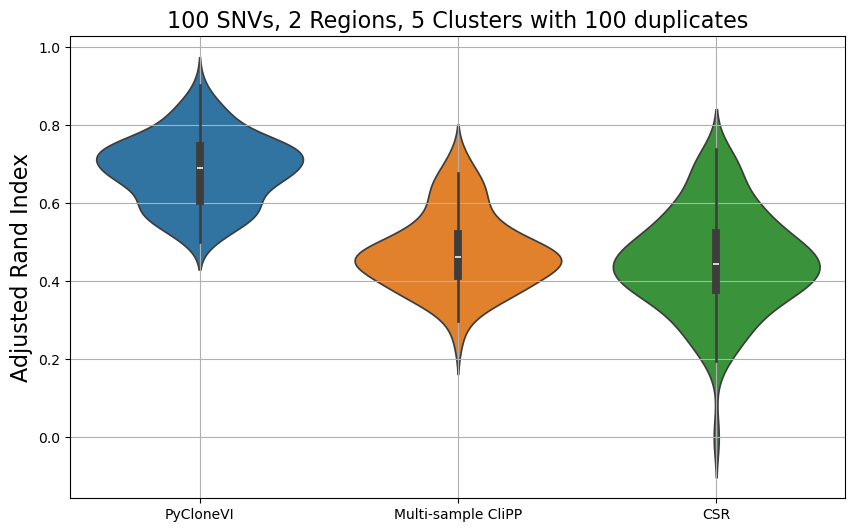

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming res1 is already defined and is a 2D numpy array
# Example res1 matrix

# Create a DataFrame for easier plotting with seaborn
df_res1 = pd.DataFrame(res1, columns=['PyCloneVI', 'Multi-sample CliPP', 'CSR'])

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_res1)
plt.xlabel('')
plt.ylabel('Adjusted Rand Index', fontsize=16)
plt.title('100 SNVs, 2 Regions, 5 Clusters with 100 duplicates', fontsize=16)
plt.grid(True)
plt.show()

In [26]:
!python clipp_data_simulation.py
datafile = 'multi_clipp_simulation_data/simulation_data_cluster_5_region_2_read_depth_100_replica_2.tsv'

In [27]:
from helper import *
from sklearn.metrics import rand_score
df = pd.read_csv(datafile, sep="\t")
change_df_to_pyclonevi(df)
!pyclone-vi fit -i pyclonevi_input.tsv -o pyclonevi_intemediate_output.h5 -c 40 -d beta-binomial -r 10
!pyclone-vi write-results-file -i pyclonevi_intemediate_output.h5 -o pyclonevi_output.tsv
df = pd.read_csv("pyclonevi_output.tsv", sep="\t")
mutation_to_cluster = df.set_index('mutation_id')['cluster_id'].to_dict()
mutation_to_cluster = dict(sorted(mutation_to_cluster.items()))
df = pd.read_csv(datafile, sep="\t")
mutation_to_cluster2 = df.set_index('mutation')['cluster'].to_dict()
mutation_to_cluster2 = dict(sorted(mutation_to_cluster2.items()))
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(list(mutation_to_cluster.values()), list(mutation_to_cluster2.values()))

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

Num Samples: 2
Samples: R1 R2
Num mutations: 100
Performing restart 0
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -162398.37263571954
Number of clusters used: 38

Fitting completed
ELBO: -812.9561349195415
Number of clusters used: 4

Performing restart 1
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -12593.245271517595
Number of clusters used: 35

Fitting completed
ELBO: -812.9561708873551
Number of clusters used: 4

Performing restart 2
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -35212.85496401629
Number of clusters used: 37

Fitting completed
ELBO: -812.9561185668866
Number of clusters used: 4

Performing restart 3
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -28672.2814848052
Number of clusters used: 38

Fitting completed
ELBO: -812.956133437798
Number of clusters used: 4

Performing restart 4
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -3

0.701021505888177

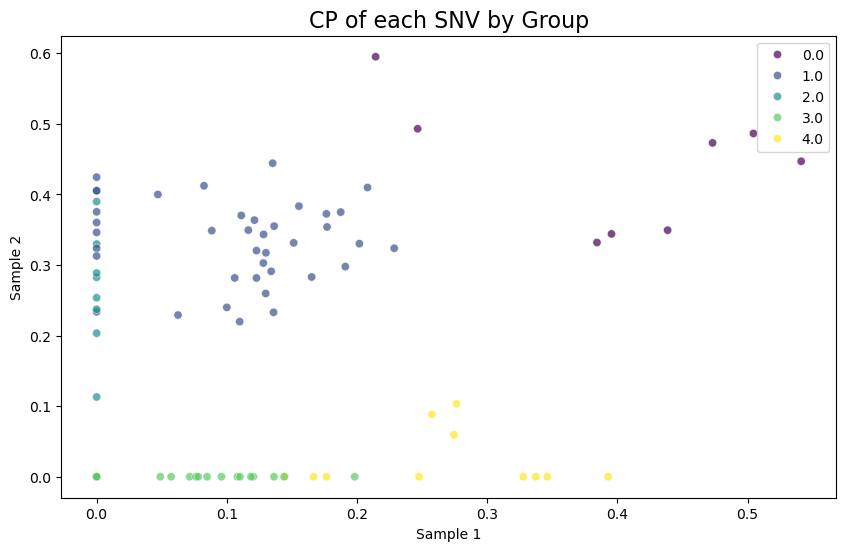

In [15]:
from helper import *
df = pd.read_csv(datafile, sep="\t")
m = len(np.unique(df['region']))
n = int(len(df) / m)
c_mat = get_c_mat(df)
cparr = np.zeros([n, m])
group = np.zeros(n)
cp = df['tumour_purity'] * df['alt_counts'] * (df['tumour_purity'] * (df['major_cn'] + df['minor_cn']) + 2 * (1 - df['tumour_purity'])) / ((df['ref_counts'] + df['alt_counts']) * df['tumour_purity'] * df['multiplicity'])

for i in range(n):
    group[i] = int(df['cluster'][i * m])
    for j in range(m):
        cparr[i, j] = cp[i * m + j]
plt.figure(figsize=(10, 6))
sns.scatterplot(x=cparr[:, 0], y=cparr[:, 1], hue=group, palette='viridis', alpha=0.7)

# Add labels and title
plt.title("CP of each SNV by Group", fontsize=16)
plt.xlabel("Sample 1")
plt.ylabel("Sample 2")

# Show the plot
plt.show()

In [30]:
from snv2 import *
import pandas as pd
from helper import *
from sklearn.metrics import rand_score, adjusted_rand_score
df = pd.read_csv(datafile, sep="\t")
m = len(np.unique(df['region']))
n = int(len(df) / m)
rho = 0.2
omega = 1
max_iteration = 20
gamma = [0.1 + 0.0025 * i for i in range(56)]
ray.shutdown()
ray.init
res = [ADMM.remote(df, rho, gamma[i], omega, n, m, max_iteration) for i in range(len(gamma))]
res = ray.get(res)
ray.shutdown()

group = np.zeros(n)
for i in range(n):
    group[i] = int(df['cluster'][i * m])
for i in range(len(gamma)):
    acc = adjusted_rand_score(res[i][7], group)
    print(f"lambda = {round(gamma[i], 5)}, accuracy = {round(acc, 4)}")

2024-12-15 01:02:39,687	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=37951) Gamma: 0.12000000000000001, clusters : dict_values([0, 1, 2, 3, 4, 5, 5, 4, 3, 5, 10, 2, 12, 13, 12, 15, 10, 17, 1, 12, 10, 21, 5, 5, 10, 2, 26, 27, 5, 2, 12, 5, 5, 10, 1, 3, 5, 5, 38, 10, 3, 5, 2, 43, 2, 2, 5, 47, 10, 38, 10, 51, 52, 3, 2, 55, 38, 38, 38, 38, 2, 38, 4, 63, 2, 3, 2, 38, 10, 69, 2, 71, 2, 2, 10, 21, 2, 2, 78, 10, 38, 10, 38, 10, 2, 2, 2, 10, 10, 10, 2, 10, 38, 2, 38, 1, 96, 38, 38, 38])
(ADMM pid=37947) Gamma: 0.15000000000000002, clusters : dict_values([0, 1, 2, 3, 4, 5, 5, 4, 3, 5, 10, 2, 12, 5, 14, 12, 12, 0, 1, 14, 12, 21, 5, 5, 12, 2, 26, 12, 5, 2, 14, 5, 5, 12, 1, 12, 5, 5, 5, 12, 12, 5, 2, 43, 2, 2, 5, 43, 12, 43, 14, 43, 5, 12, 2, 55, 43, 43, 43, 43, 43, 43, 62, 63, 43, 12, 43, 43, 14, 43, 43, 1, 43, 43, 12, 12, 43, 43, 78, 14, 43, 14, 43, 14, 43, 43, 43, 12, 12, 14, 43, 14, 43, 43, 43, 1, 96, 43, 43, 43]) [repeated 14x across cluster]
(ADMM pid=37947) Gamma: 0.17, clusters : dict_values([0, 1, 2, 3, 4, 2, 2, 4, 3, 2, 2, 2, 3, 2, 14, 3, 3, 0, 1,

/var/folders/w9/kx7wk6017tl5yqsllw_f5hph0000gn/T/ipykernel_120/668518668.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


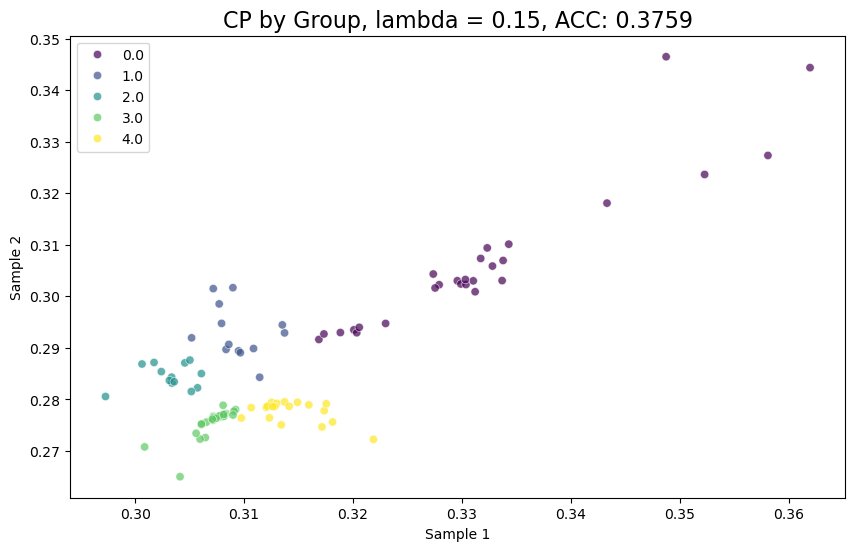

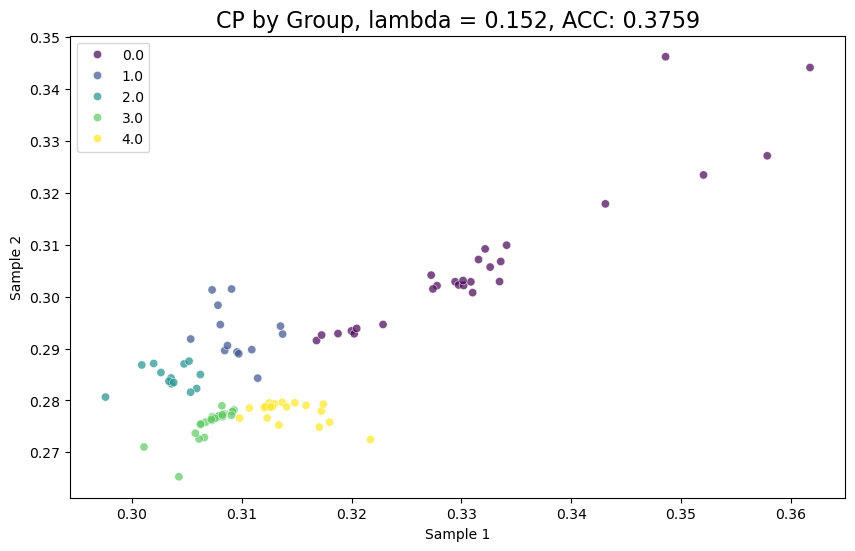

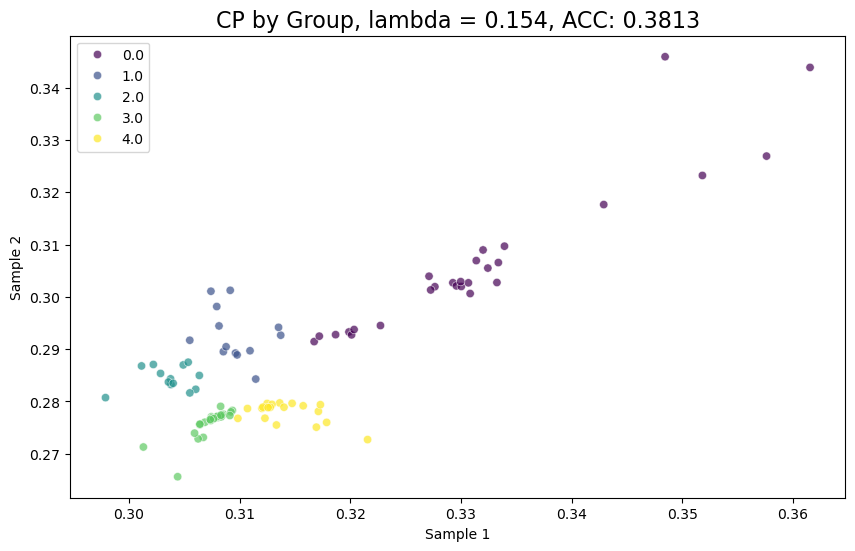

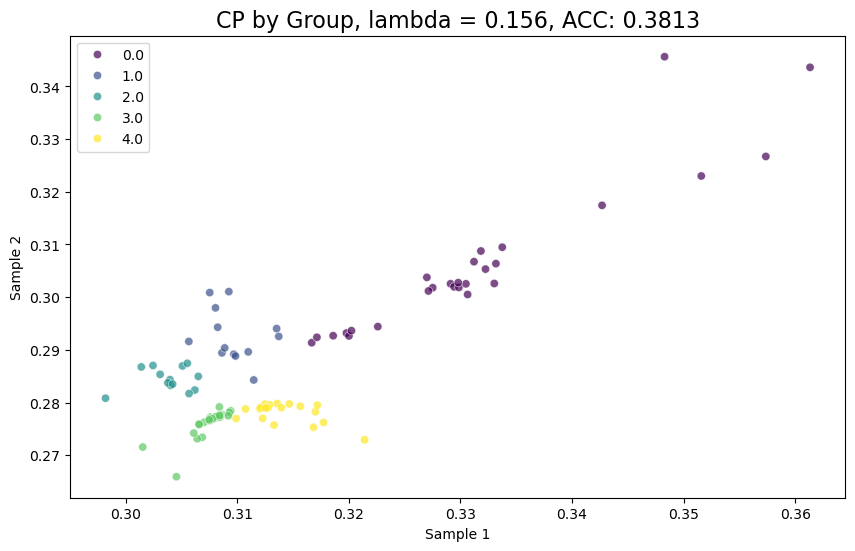

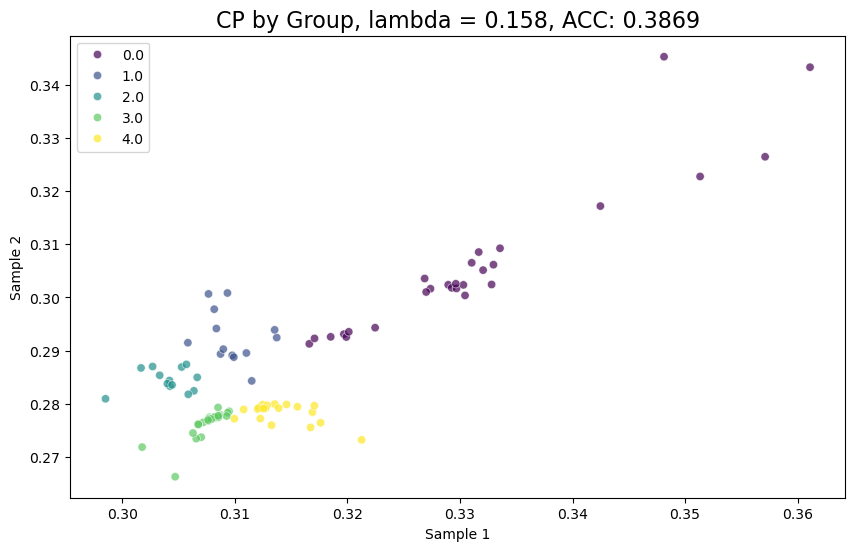

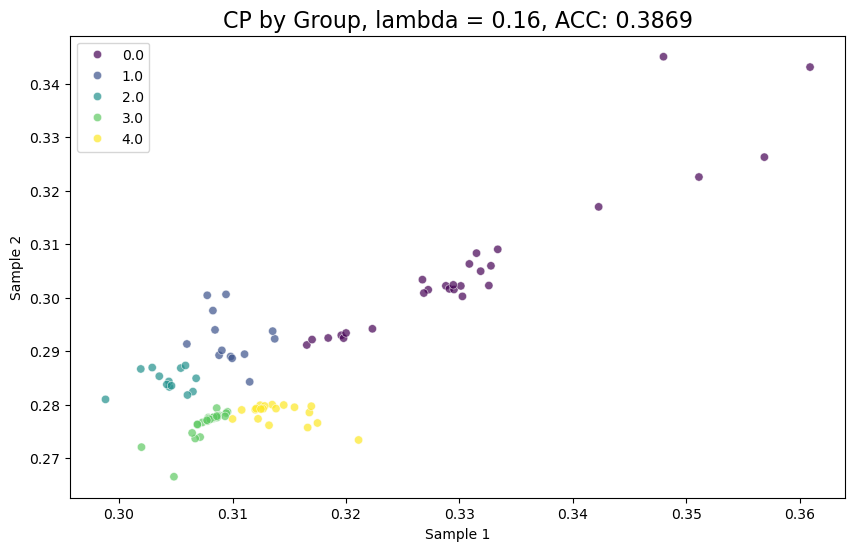

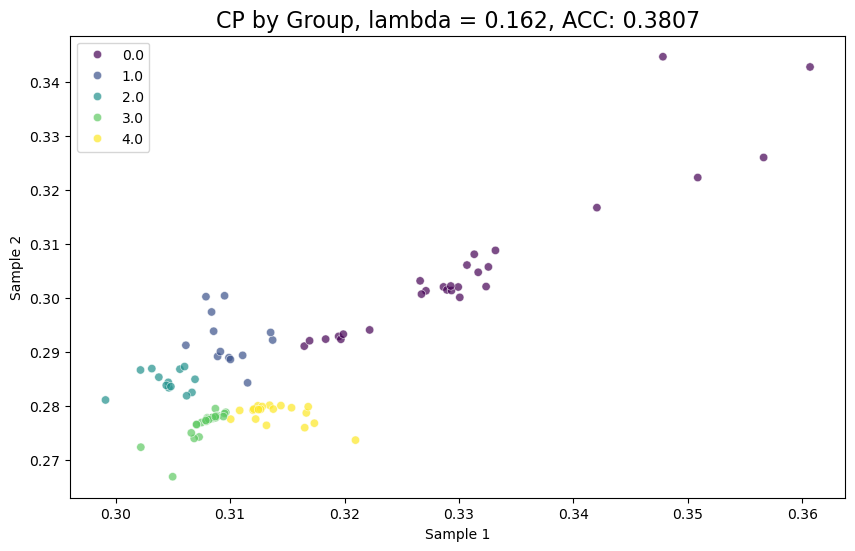

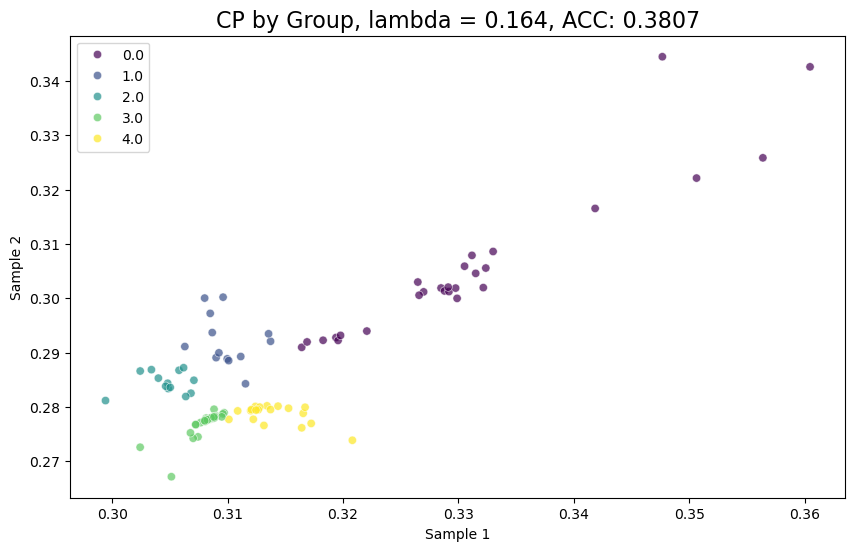

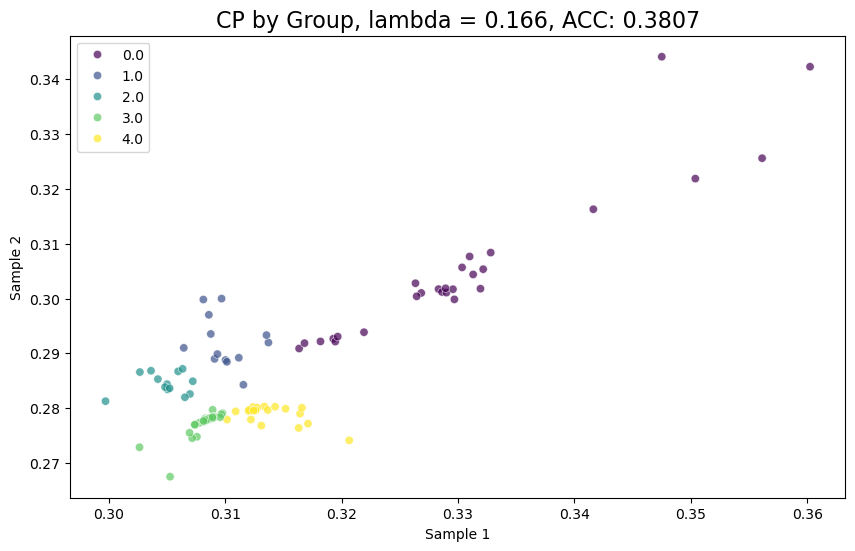

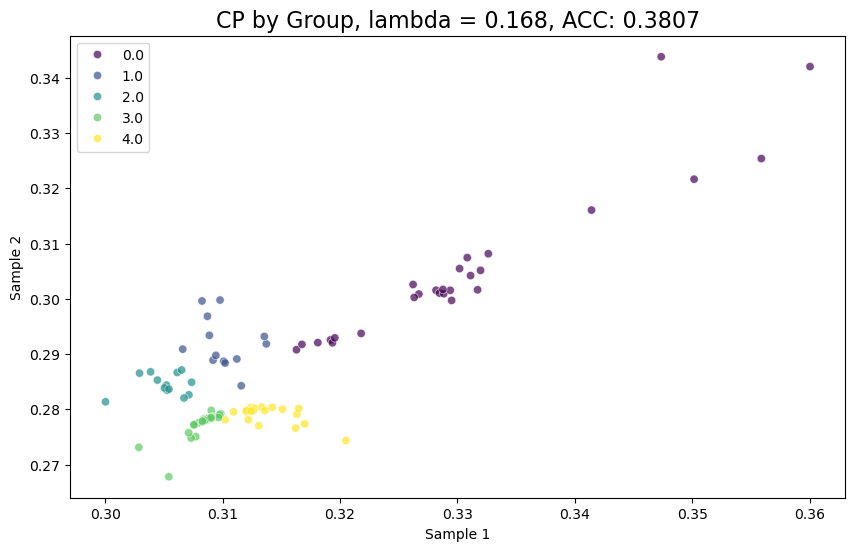

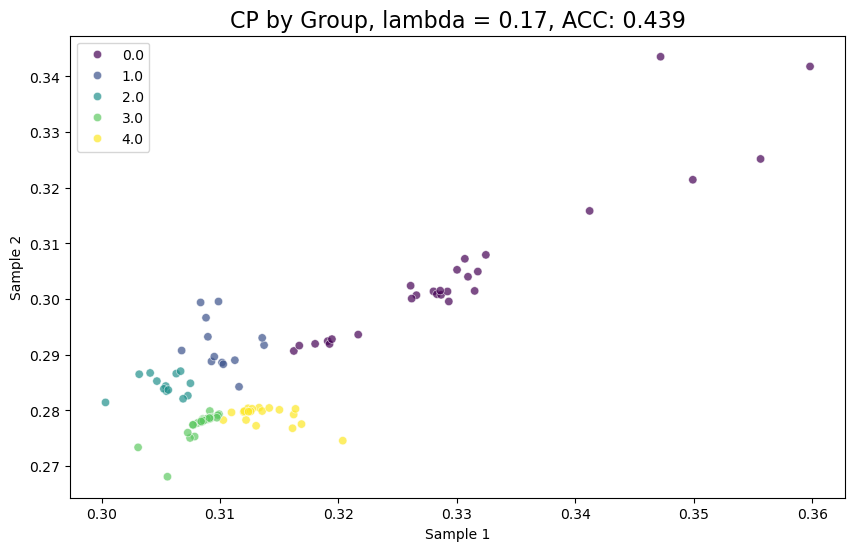

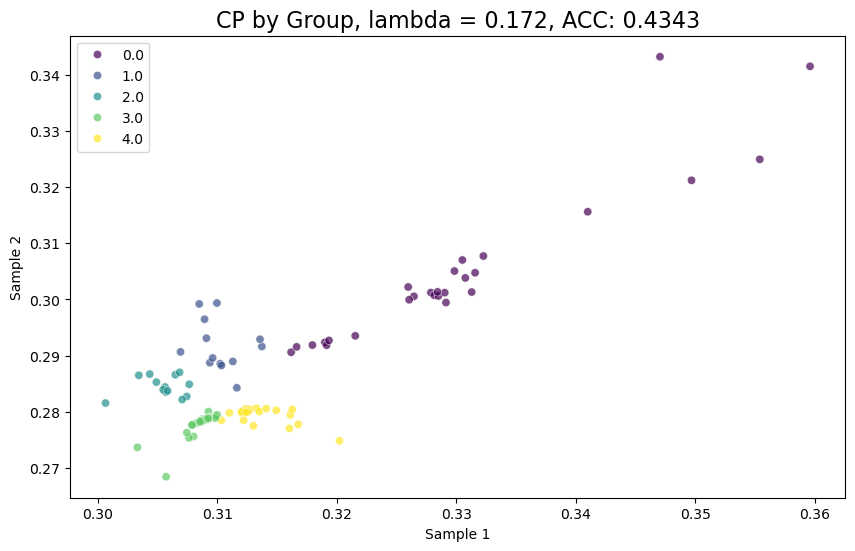

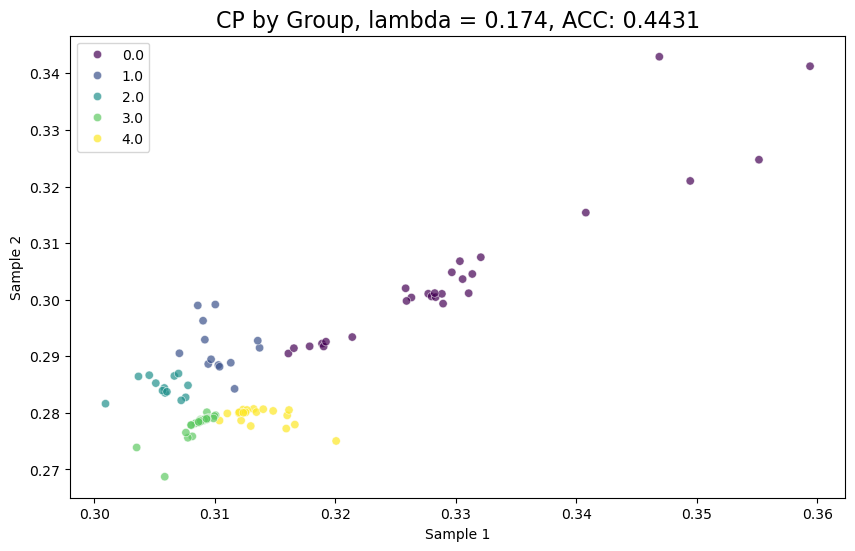

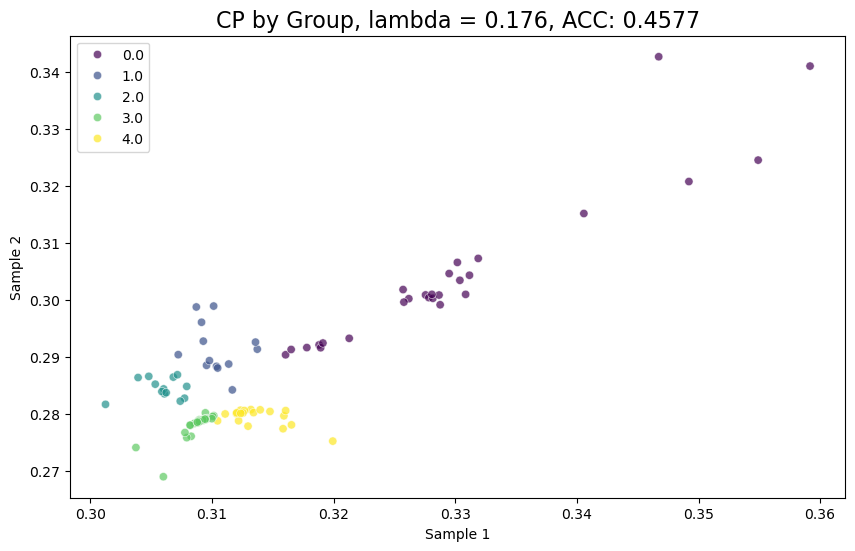

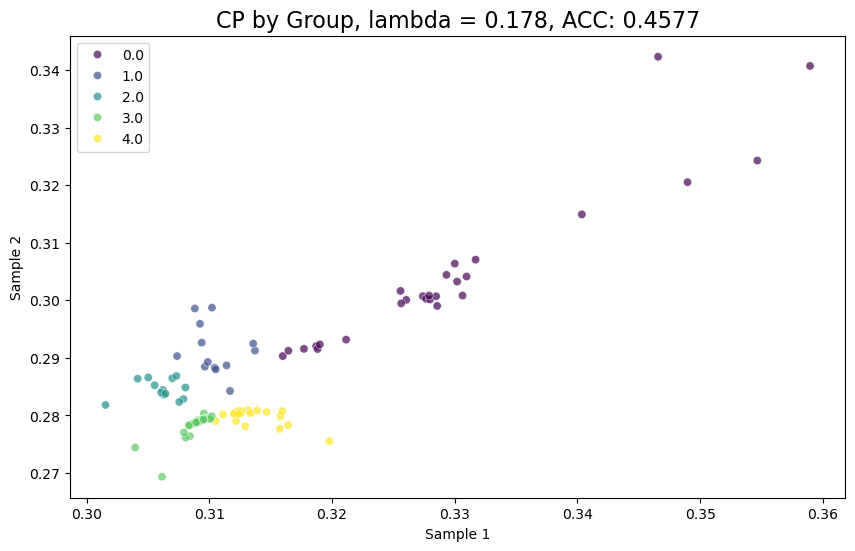

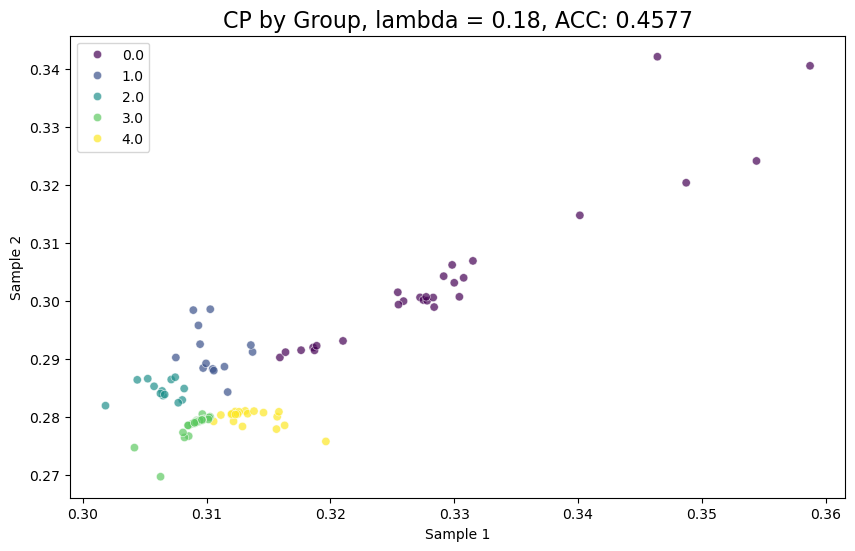

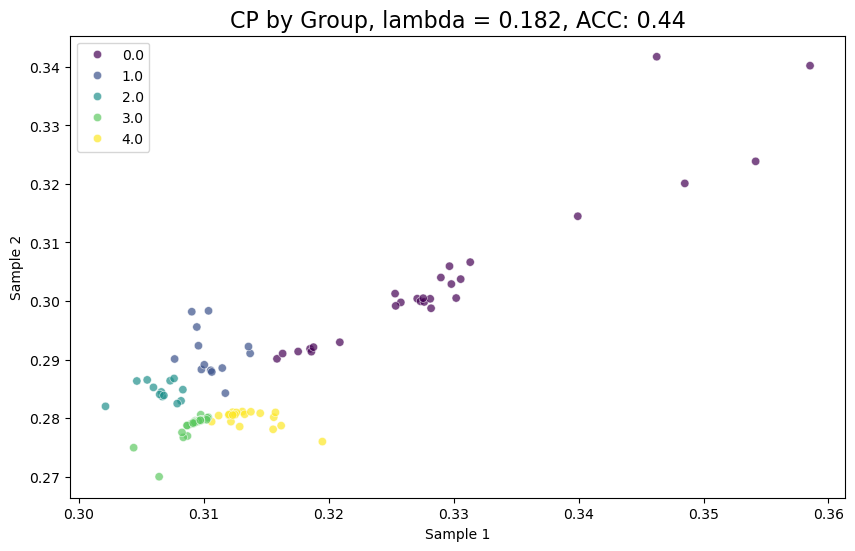

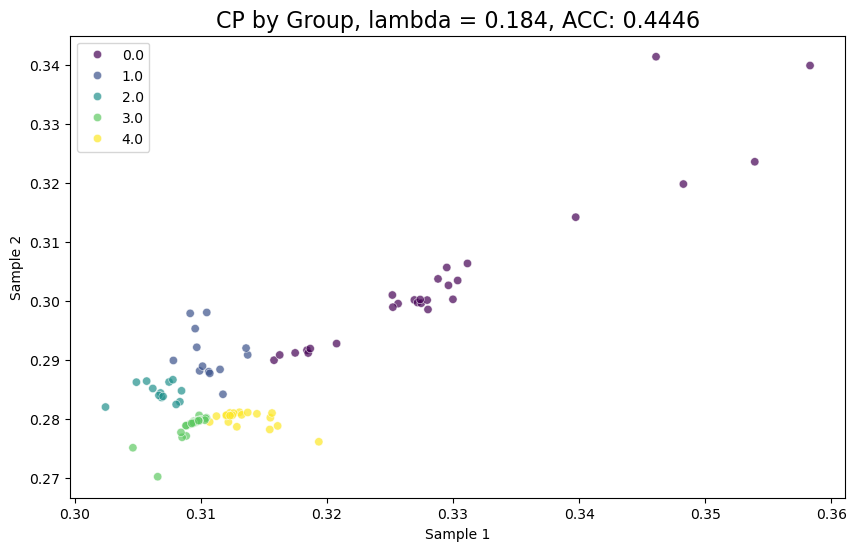

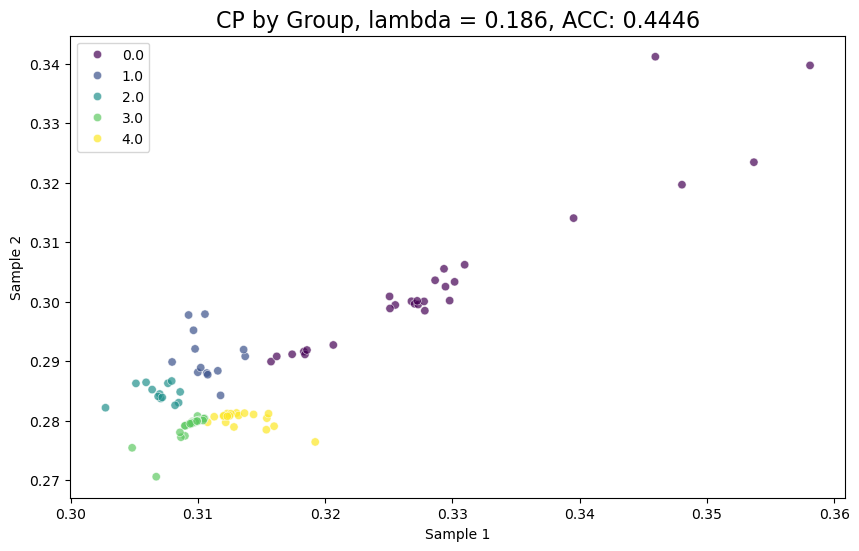

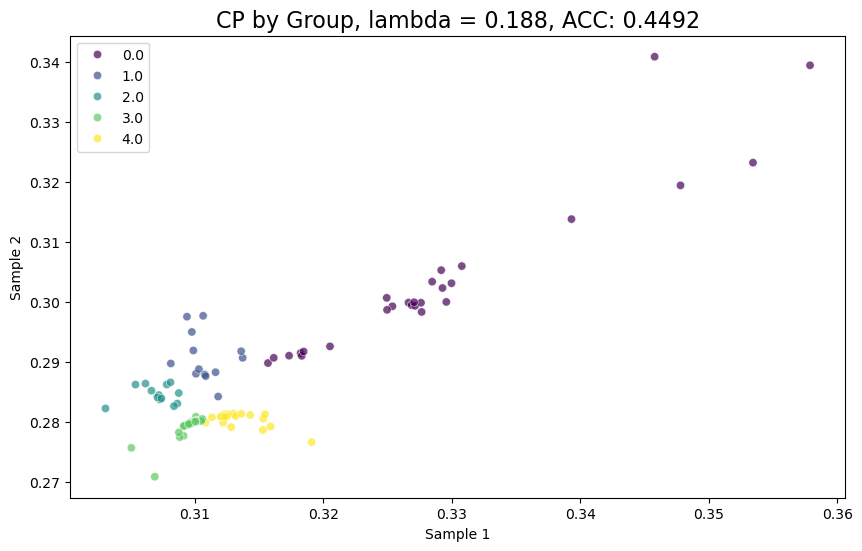

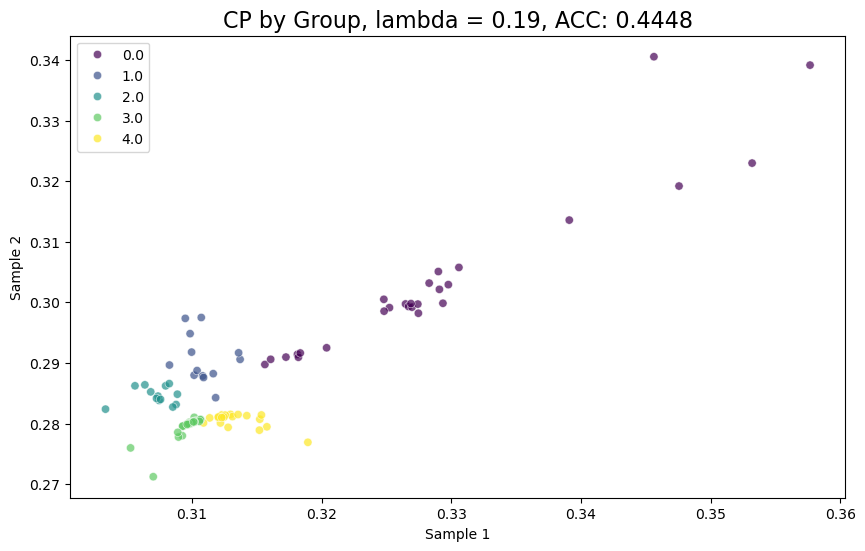

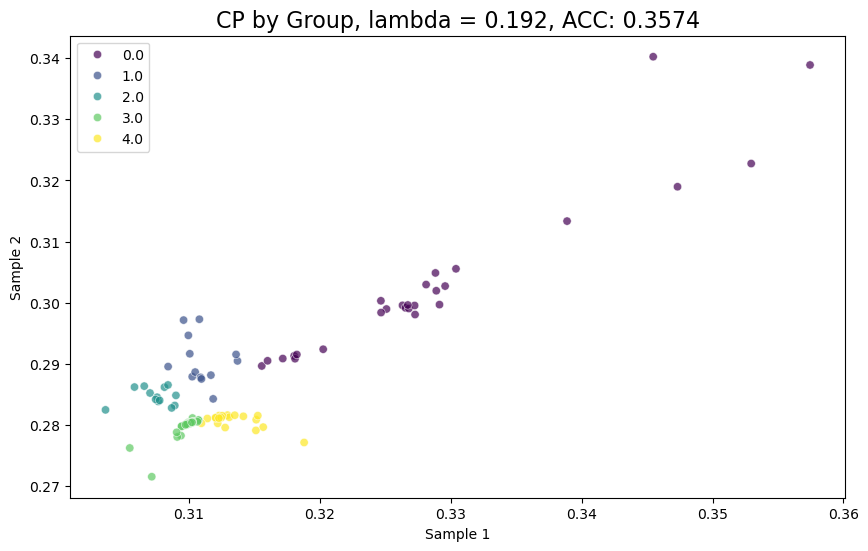

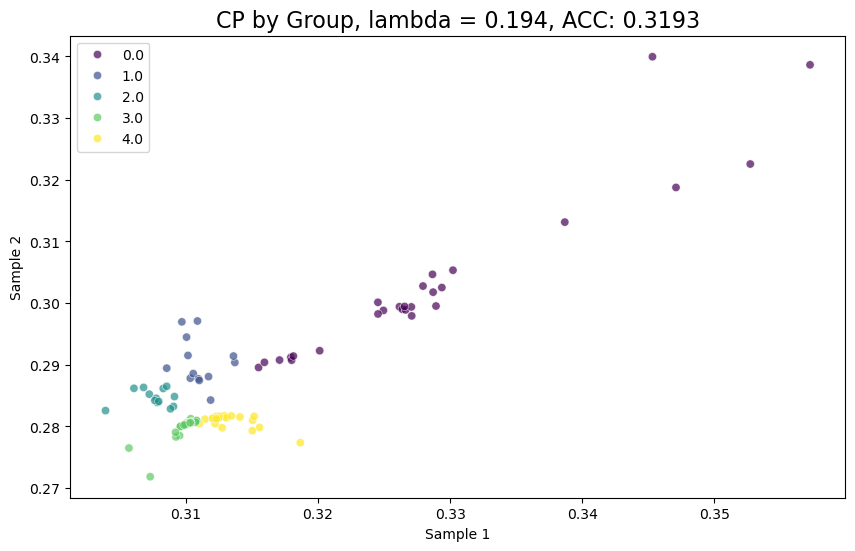

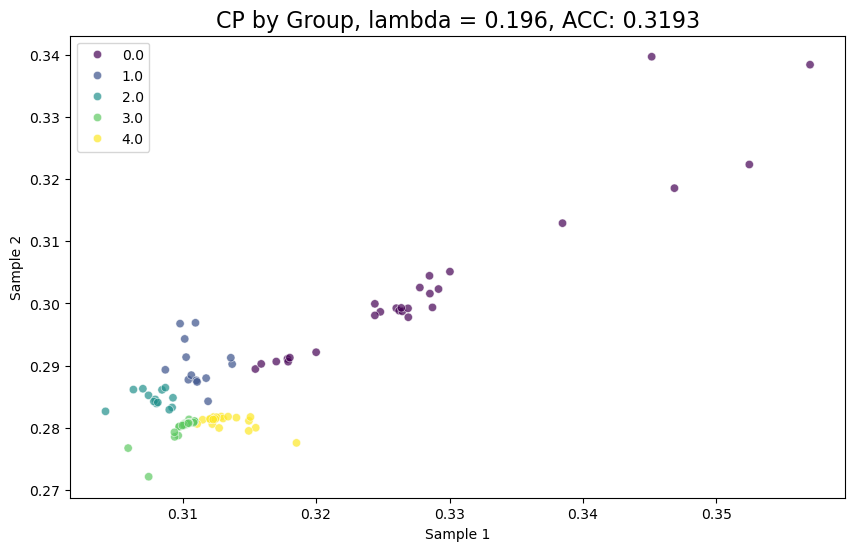

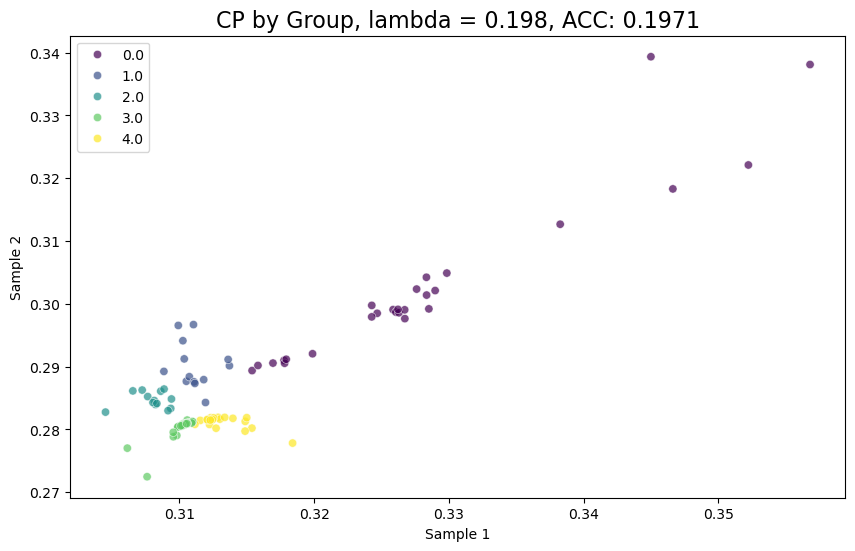

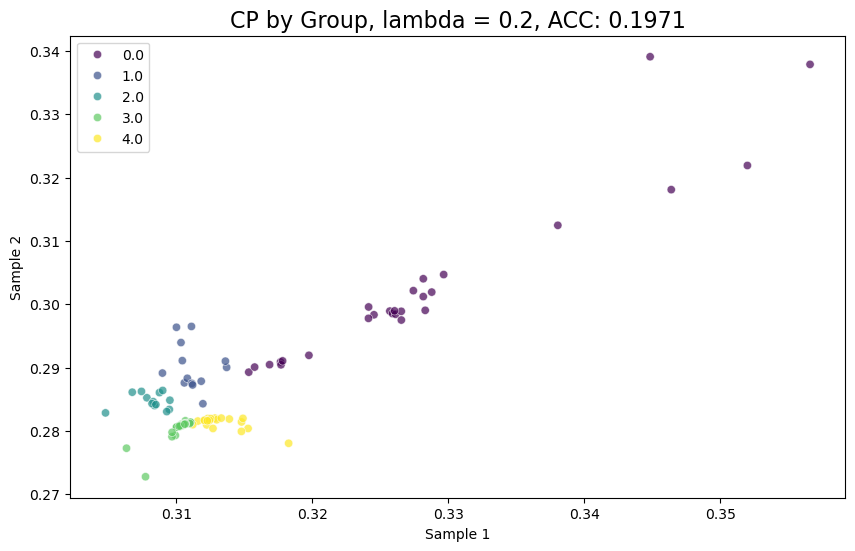

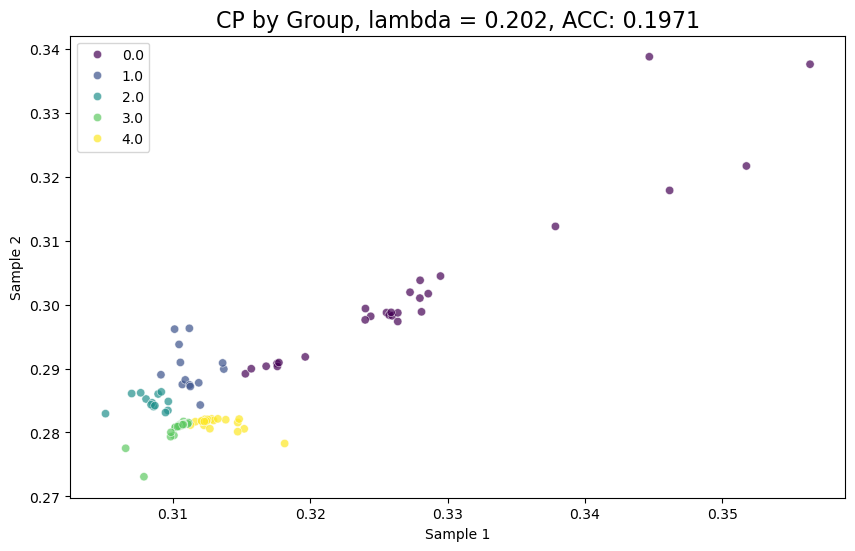

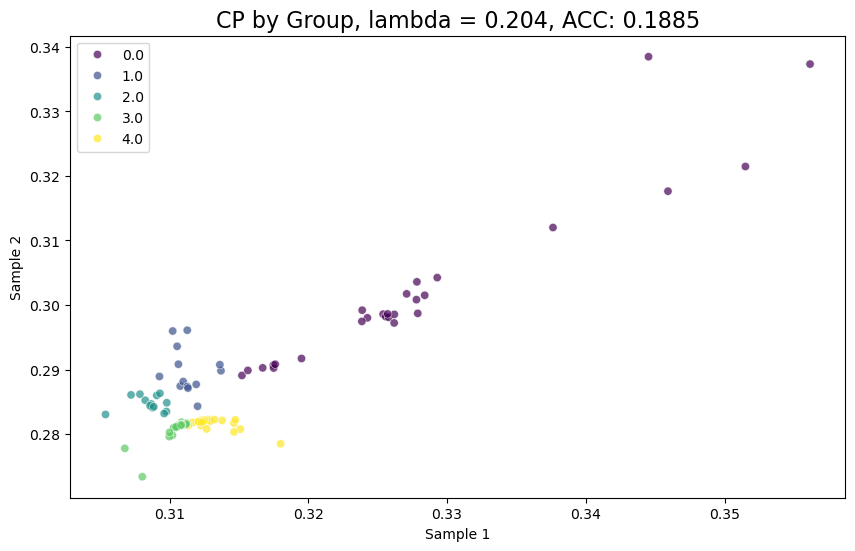

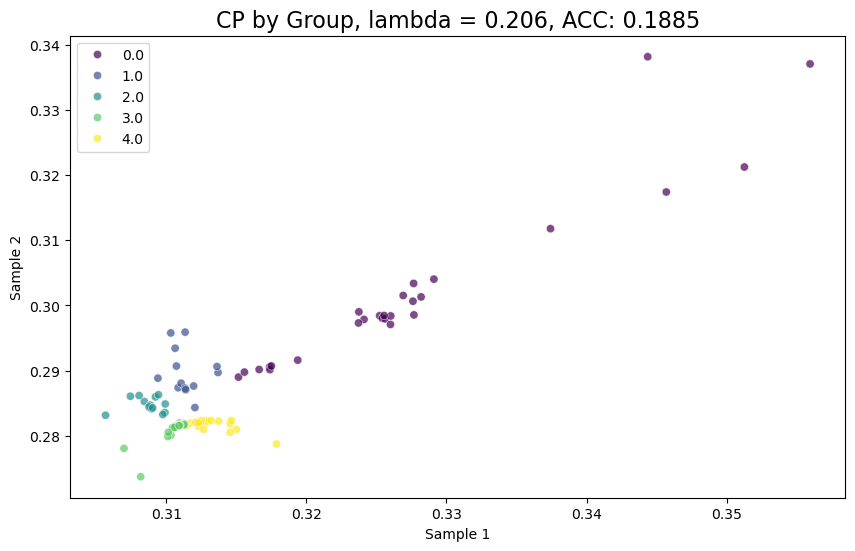

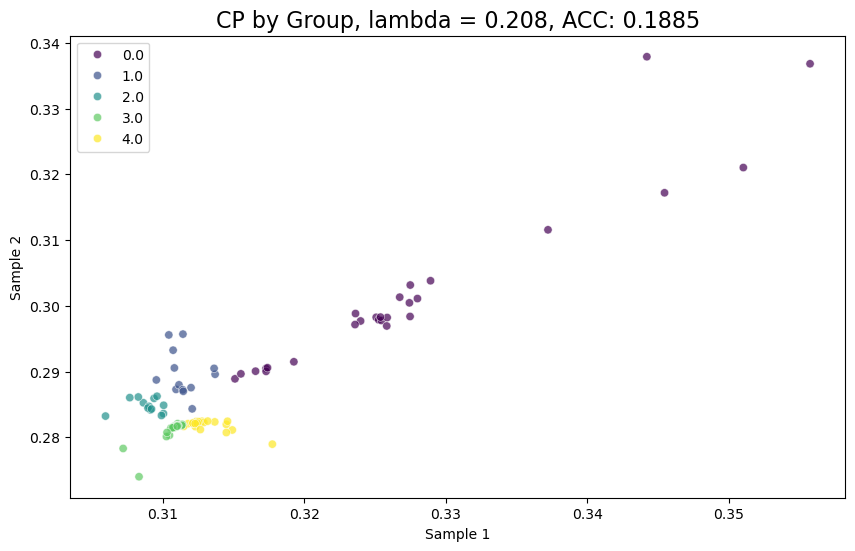

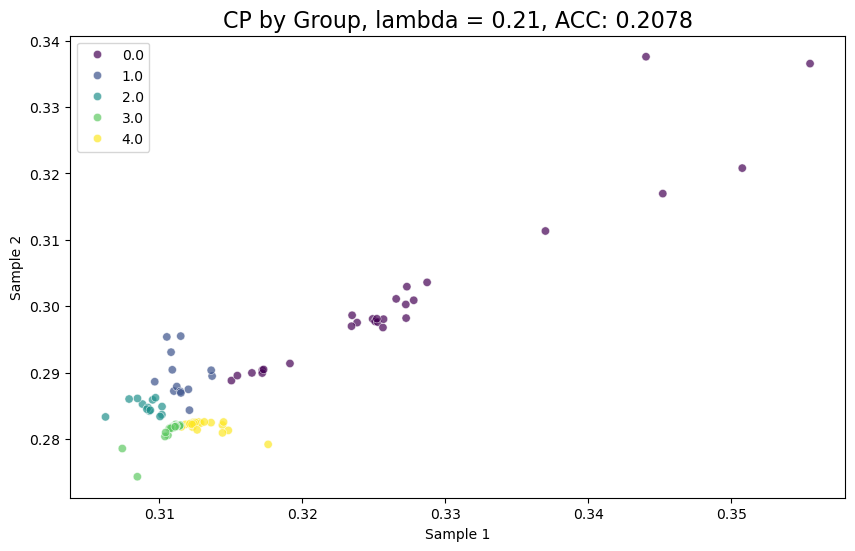

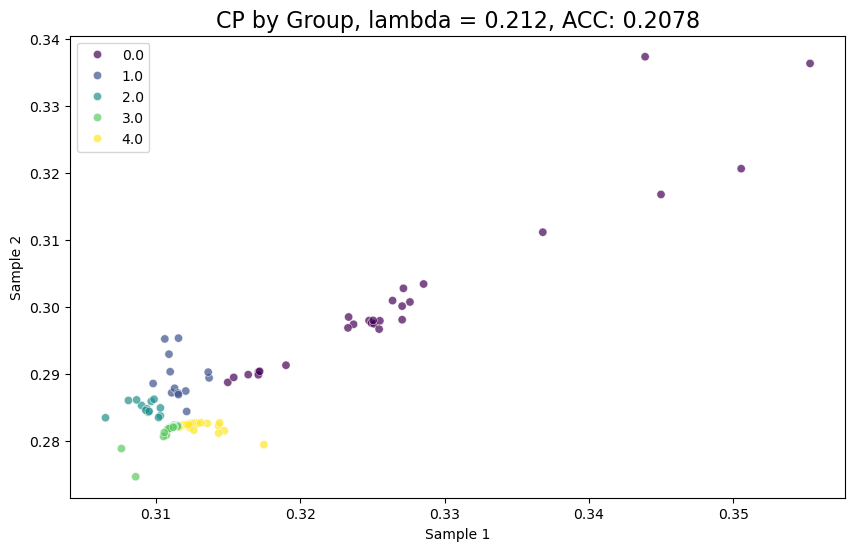

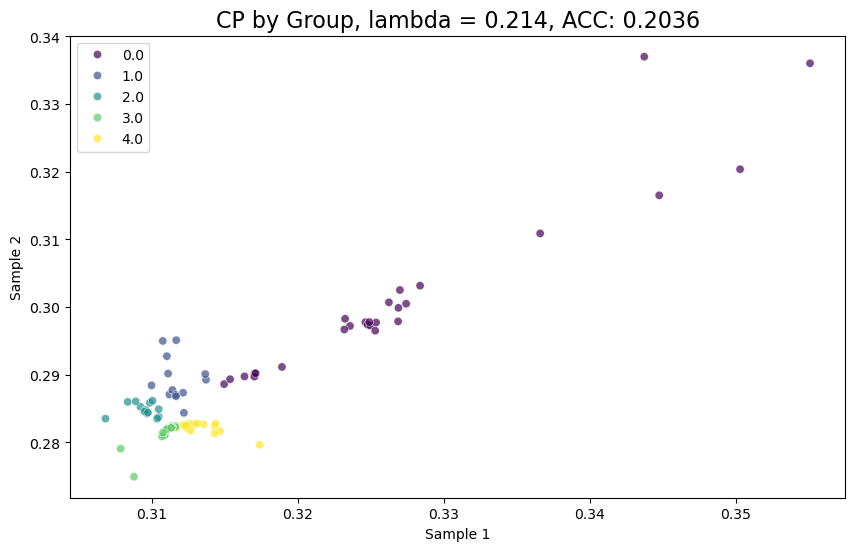

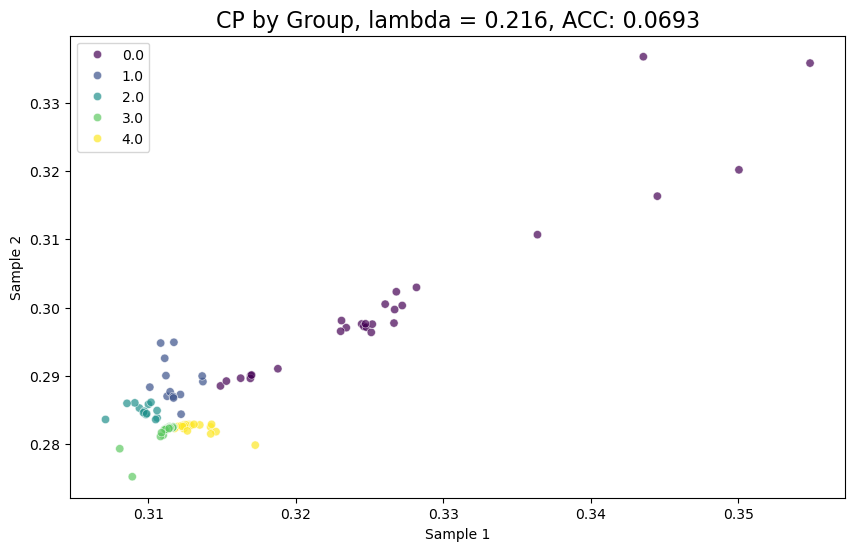

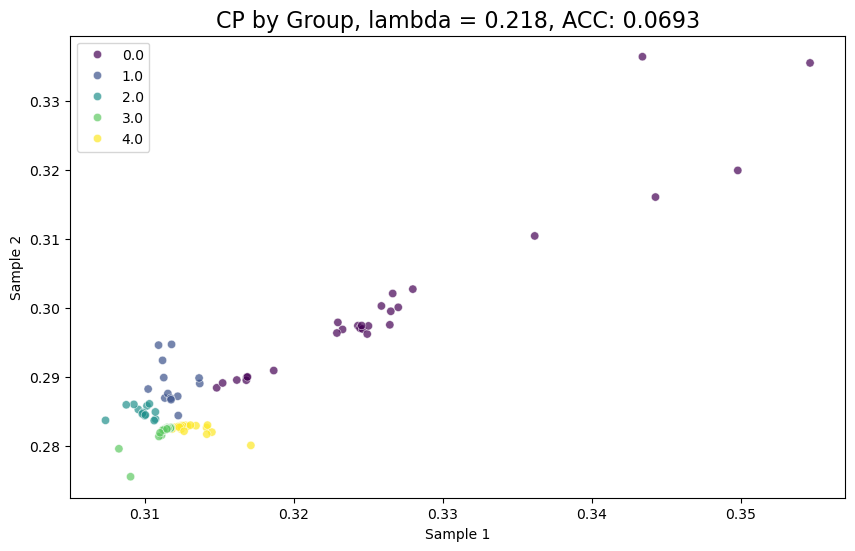

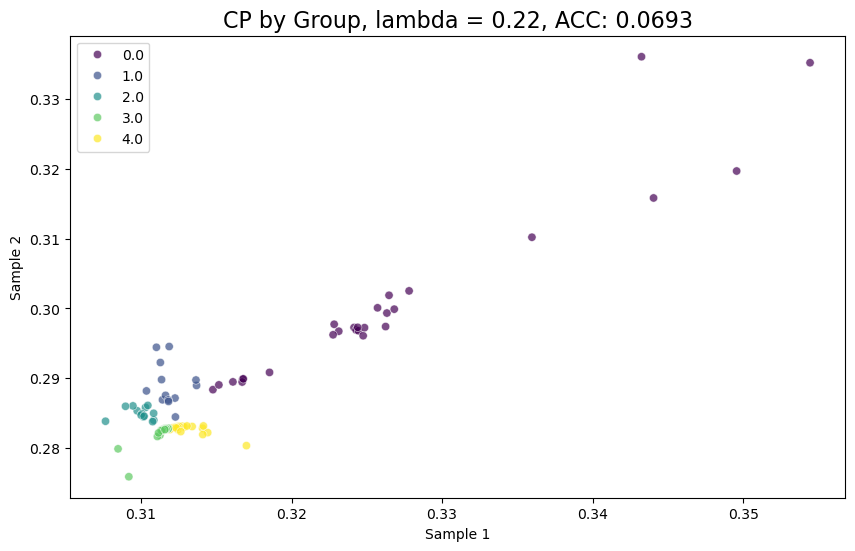

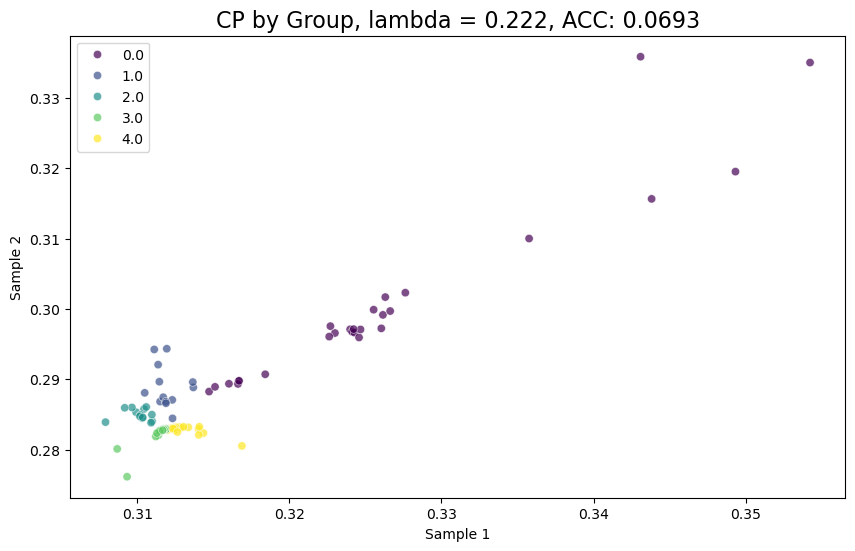

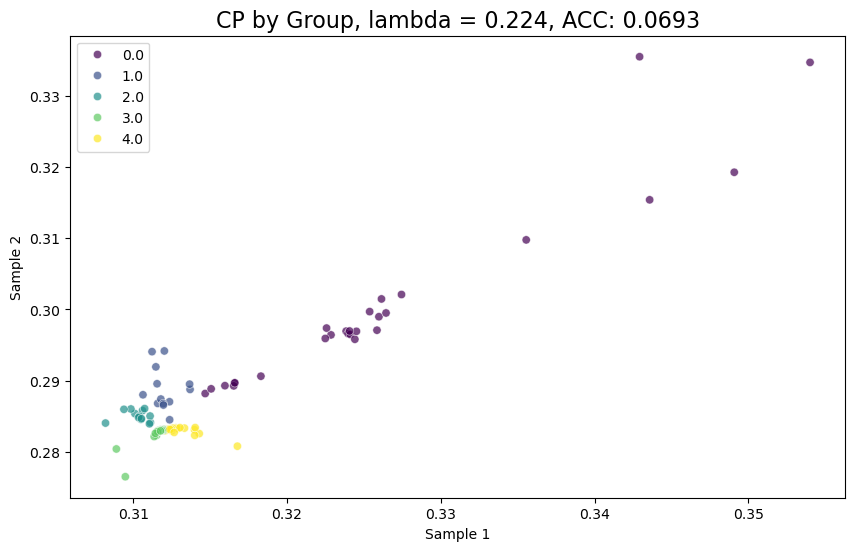

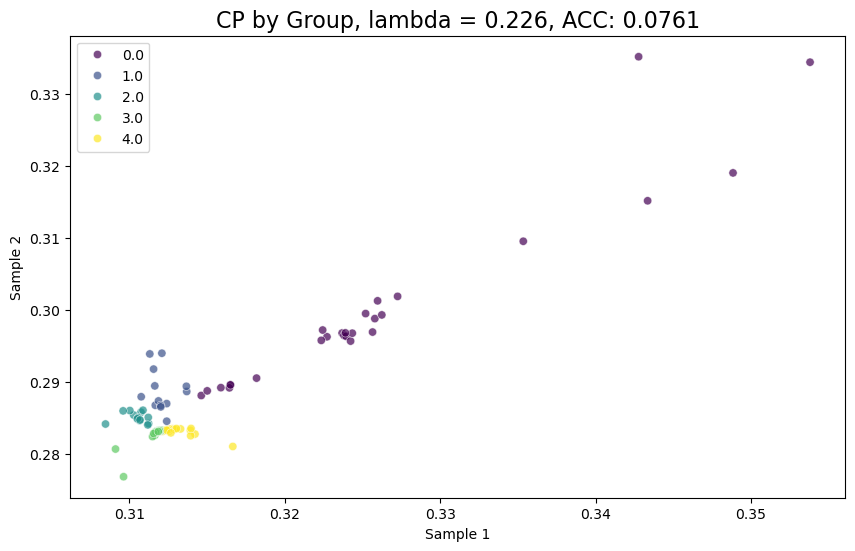

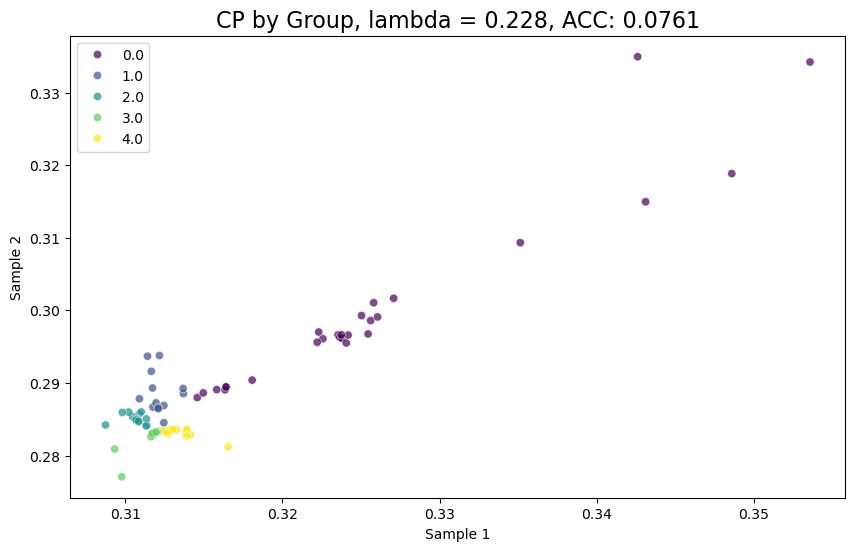

In [2]:
from helper import *
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, rand_score
group = np.zeros(n)
for i in range(n):
    group[i] = int(df['cluster'][i * m])
for i in range(len(gamma)):
    cp = convert_p_to_cp(res[i][0], n, m)
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=cp[:, 0], y=cp[:, 1], hue=group, palette='viridis', alpha=0.7)

    # Add labels and title
    plt.title(f"CP by Group, lambda = {round(gamma[i], 4)}, ACC: {round(adjusted_rand_score(res[i][7], group), 4)}", fontsize=16)
    plt.xlabel("Sample 1")
    plt.ylabel("Sample 2")

    # Show the plot
    plt.savefig(f"example_{i}.png", dpi=300, bbox_inches="tight")

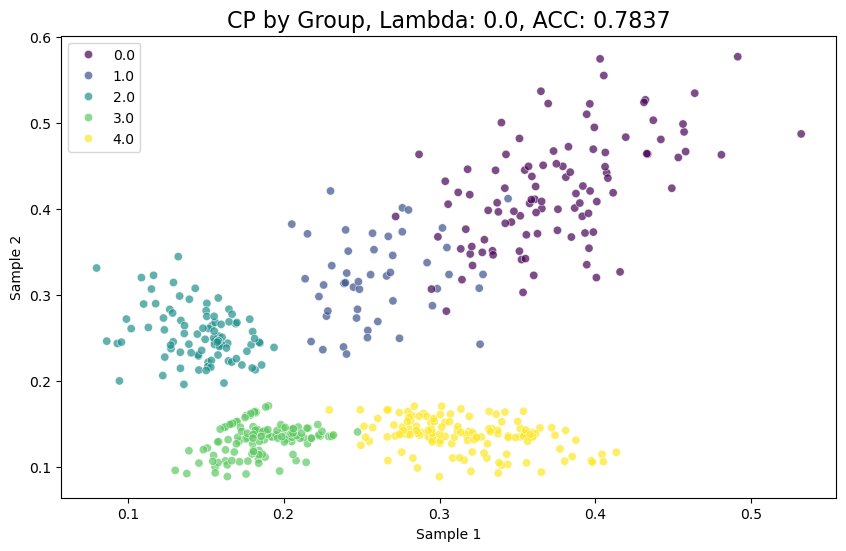

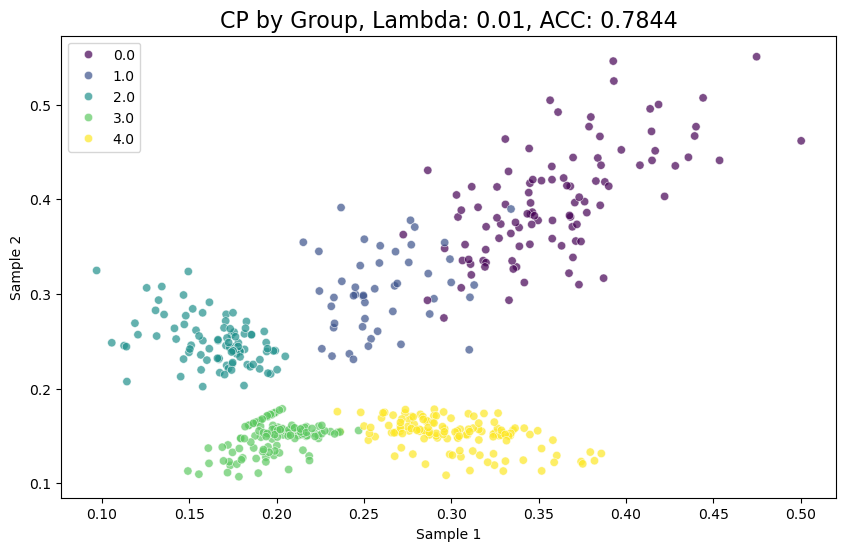

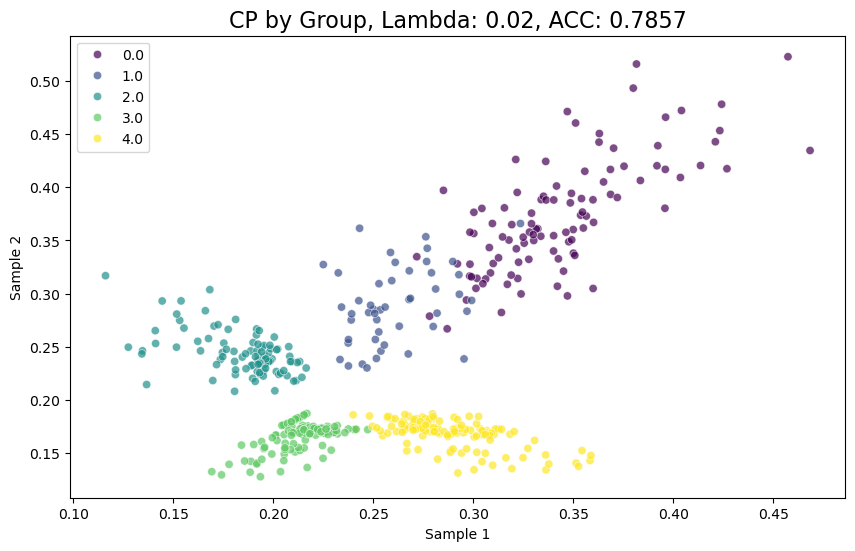

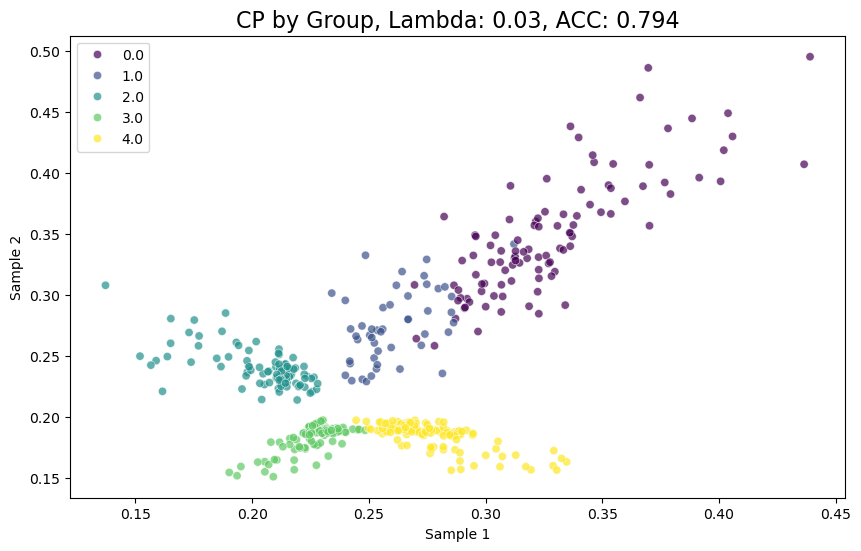

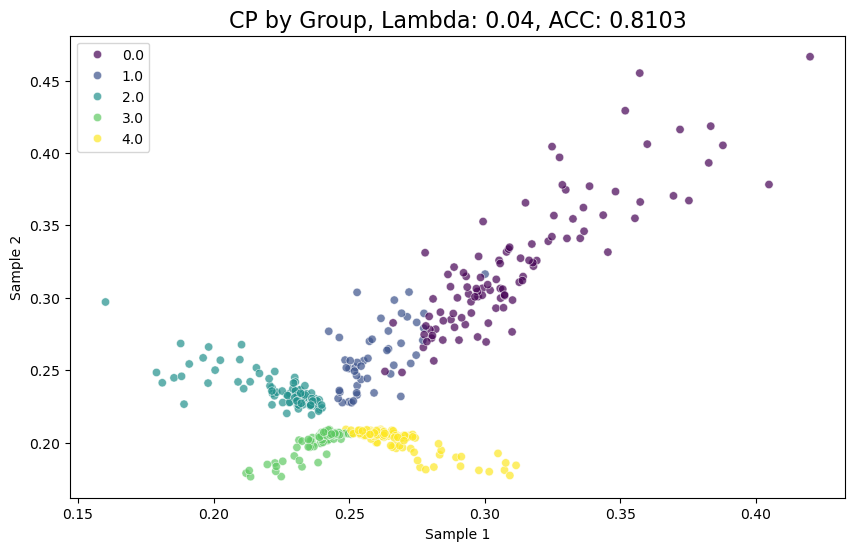

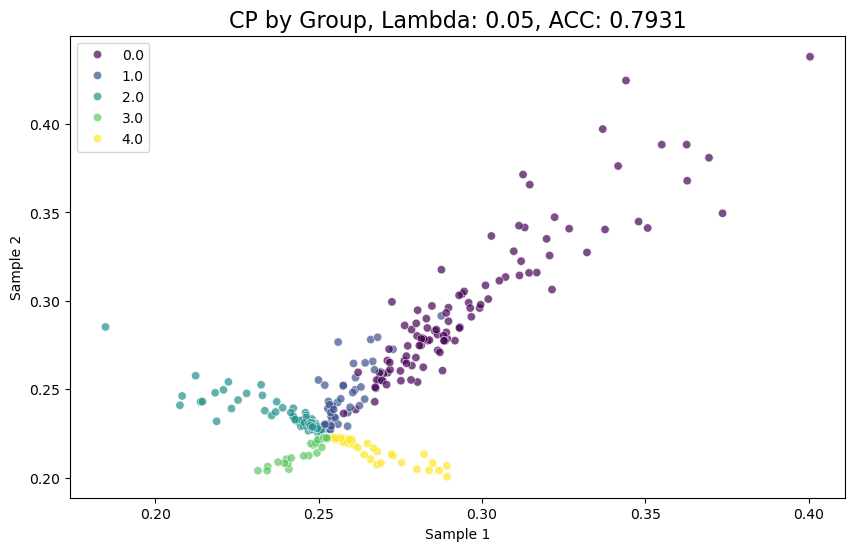

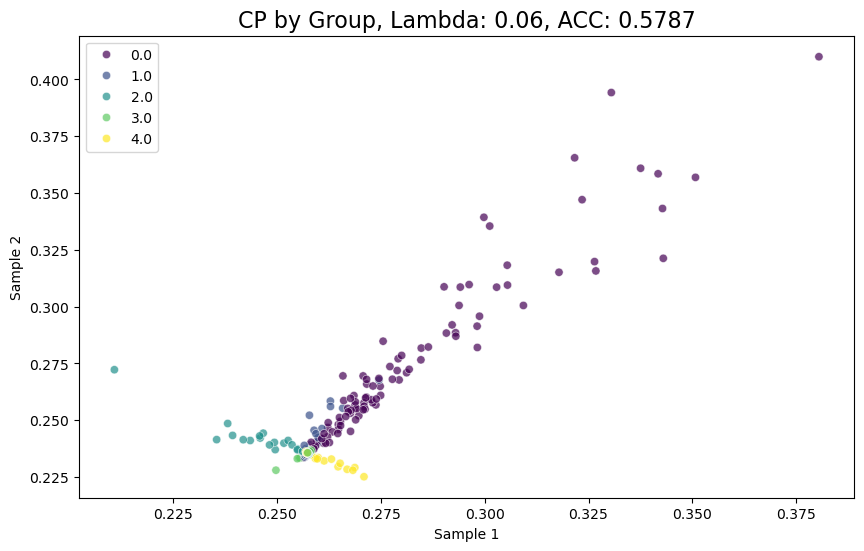

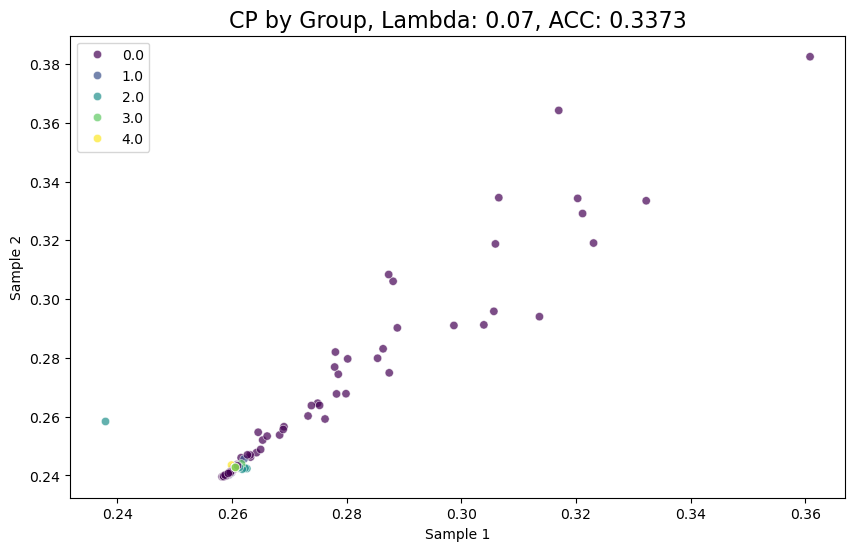

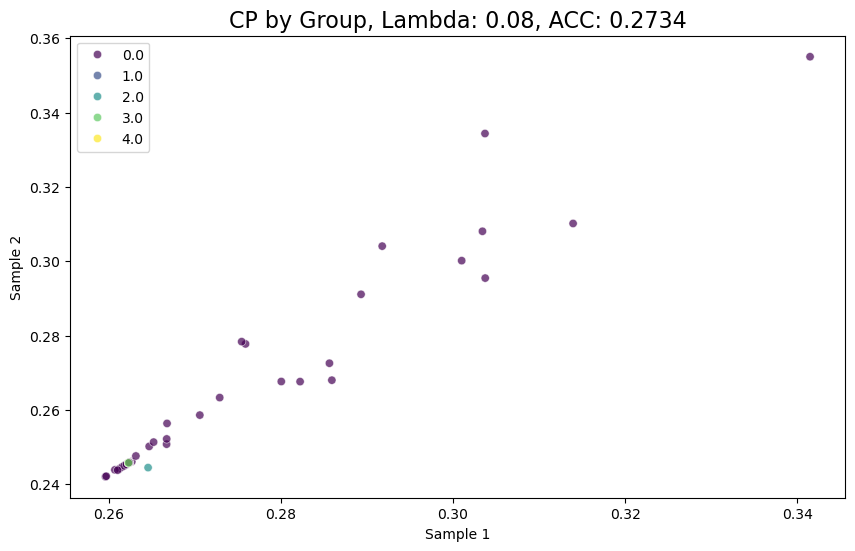

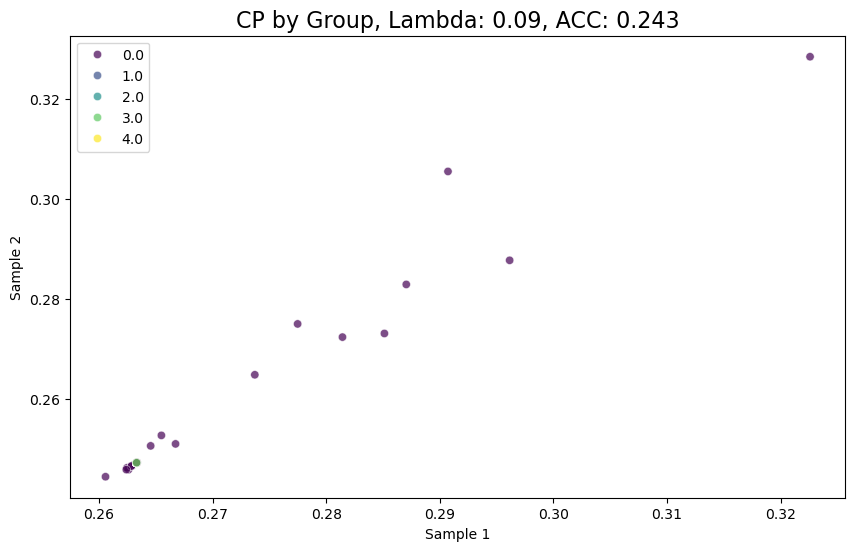

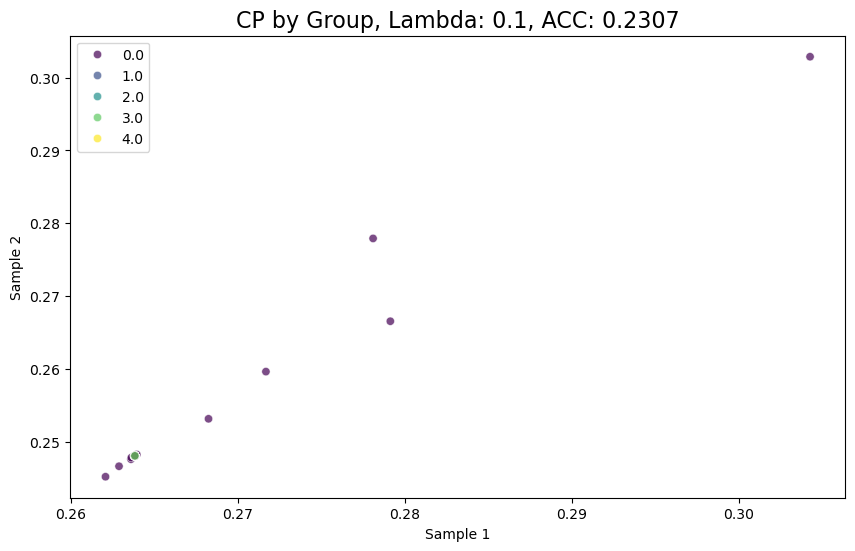

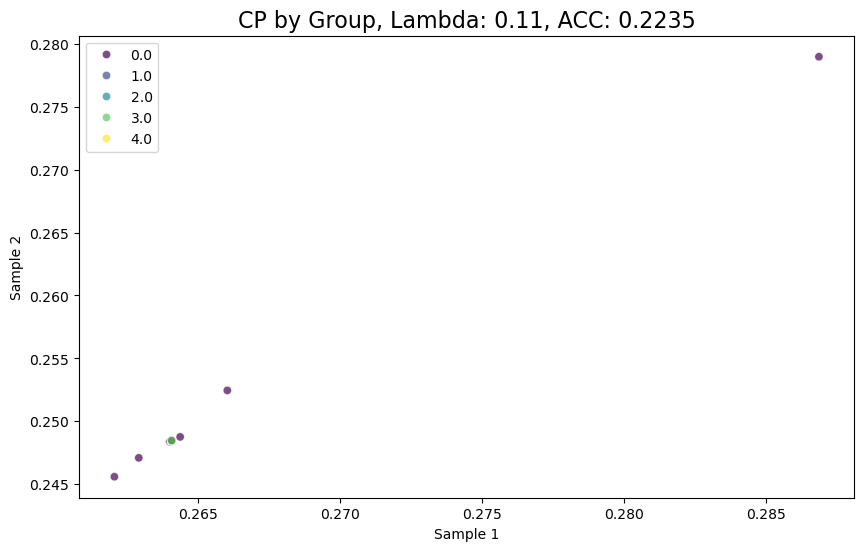

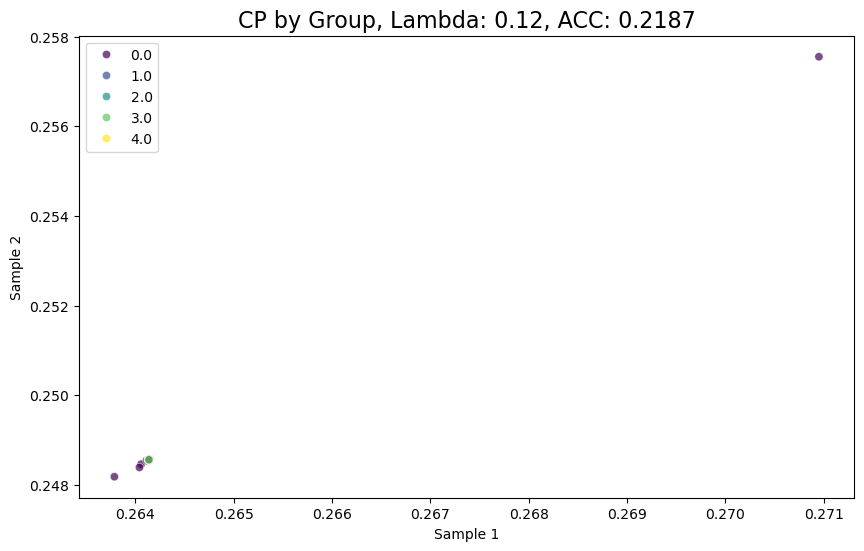

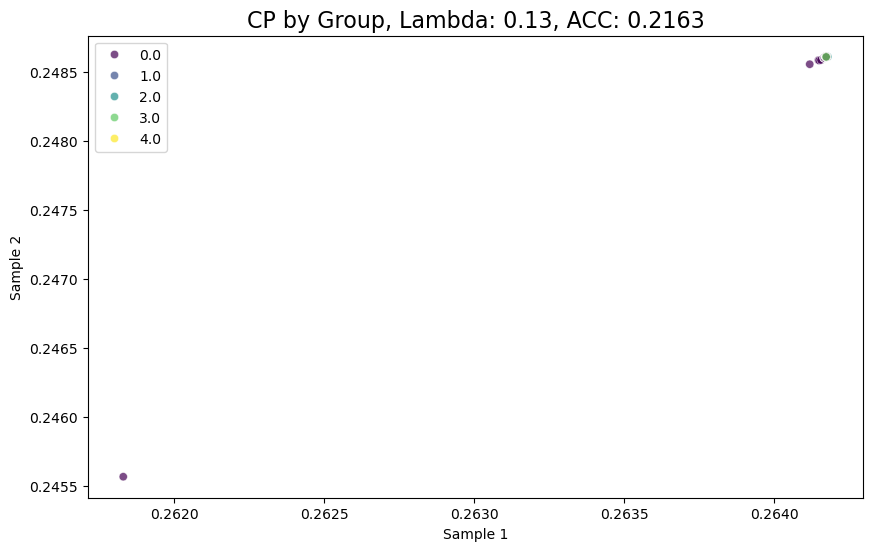

In [2]:
for i in range(len(gamma)):
    cp = convert_p_to_cp(res[i][0], n, m)
    acc = rand_score(res[i][7], group)
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=cp[:, 0], y=cp[:, 1], hue=group, palette='viridis', alpha=0.7)

    # Add labels and title
    plt.title(f"CP by Group, Lambda: {round(gamma[i], 4)}, ACC: {round(acc, 4)}", fontsize=16)
    plt.xlabel("Sample 1")
    plt.ylabel("Sample 2")

    # Show the plot
    plt.savefig(f"example_{i}.png", dpi=300, bbox_inches="tight")

In [ ]:

def create_gif(image_sequence, output_file, duration=10):
    """
    Generate a GIF from a sequence of images.

    Parameters:
        image_sequence (list of str): Paths to the image files in sequence.
        output_file (str): Path for the output GIF file.
        duration (float): Duration of each frame in seconds (default is 0.5s).
    """
    with imageio.get_writer(output_file, mode='I', duration=duration) as writer:
        for image_path in image_sequence:
            image = imageio.imread(image_path)
            writer.append_data(image)
    print(f"GIF saved as {output_file}")

image_sequence = [f"example_{i}.png" for i in range(85)]  # Replace with your image paths
output_gif = "output.gif"
create_gif(image_sequence, output_gif, duration=100)

GIF saved as output.gif


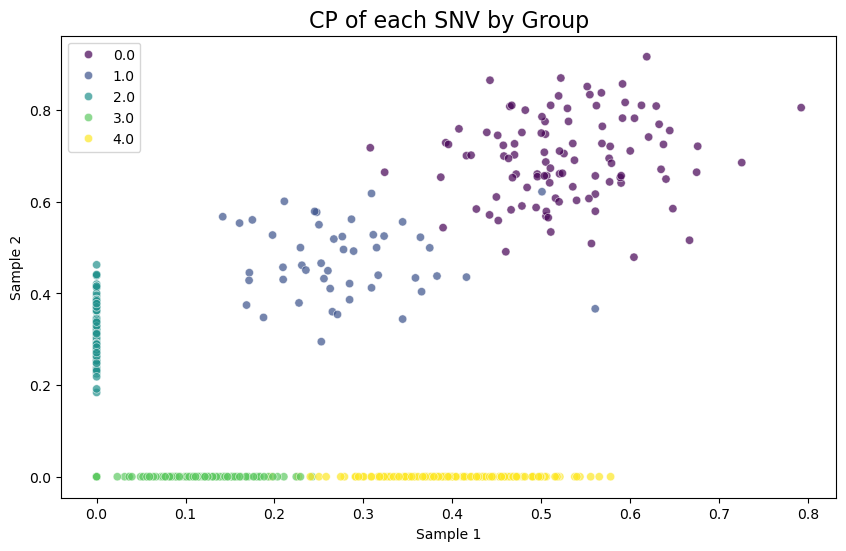

In [7]:
from helper import *
c_mat = get_c_mat(df)
cp1 = convert_p_to_cp(res[0][0], n, m)
cparr = np.zeros([n, m])
group = np.zeros(n)
cp = df['tumour_purity'] * df['alt_counts'] * (df['tumour_purity'] * (df['major_cn'] + df['minor_cn']) + 2 * (1 - df['tumour_purity'])) / ((df['ref_counts'] + df['alt_counts']) * df['tumour_purity'] * df['multiplicity'])

for i in range(n):
    group[i] = int(df['cluster'][i * m])
    for j in range(m):
        cparr[i, j] = cp[i * m + j]
plt.figure(figsize=(10, 6))
sns.scatterplot(x=cparr[:, 0], y=cparr[:, 1], hue=group, palette='viridis', alpha=0.7)

# Add labels and title
plt.title("CP of each SNV by Group", fontsize=16)
plt.xlabel("Sample 1")
plt.ylabel("Sample 2")

# Show the plot
plt.show()

In [2]:
!pyclone-vi fit -i pyclonevi_input.tsv -o pyclonevi_intemediate_output.h5 -c 40 -d beta-binomial -r 10


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

Num Samples: 2
Samples: R1 R2
Num mutations: 500
Performing restart 0
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -1021815.7397335623
Number of clusters used: 40

Fitting completed
ELBO: -2989.7344074257658
Number of clusters used: 5

Performing restart 1
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -167425.47069198618
Number of clusters used: 40

Fitting completed
ELBO: -3201.145749510069
Number of clusters used: 4

Performing restart 2
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -121249.76056186734
Number of clusters used: 40

Fitting completed
ELBO: -2963.4665316353894
Number of clusters used: 5

Performing restart 3
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -127546.51212402275
Number of clusters used: 40

Fitting completed
ELBO: -2963.466501331445
Number of clusters used: 5

Performing restart 4
Setting annealing factor to : 1.0

Iteration: 0
EL

In [3]:
!pyclone-vi write-results-file -i pyclonevi_intemediate_output.h5 -o pyclonevi_output.tsv


In [7]:
df = pd.read_csv("pyclonevi_output.tsv", sep="\t")
mutation_to_cluster = df.set_index('mutation_id')['cluster_id'].to_dict()
mutation_to_cluster = dict(sorted(mutation_to_cluster.items()))
mutation_to_cluster

{'chr10:103847184': 4,
 'chr10:106982054': 2,
 'chr10:108043632': 1,
 'chr10:110966154': 5,
 'chr10:113009015': 2,
 'chr10:120855102': 2,
 'chr10:126064': 2,
 'chr10:14711122': 5,
 'chr10:22513236': 2,
 'chr10:25797233': 1,
 'chr10:27858833': 1,
 'chr10:29226748': 4,
 'chr10:44684369': 2,
 'chr10:44710590': 5,
 'chr10:45538010': 1,
 'chr10:46452775': 4,
 'chr10:49553289': 5,
 'chr10:55678210': 5,
 'chr10:59536439': 5,
 'chr10:5955046': 5,
 'chr10:63990277': 5,
 'chr10:64903524': 5,
 'chr10:76178088': 2,
 'chr10:76214455': 5,
 'chr10:77137650': 1,
 'chr10:86052837': 5,
 'chr10:91322148': 5,
 'chr10:91731959': 4,
 'chr10:95445037': 2,
 'chr11:102251491': 2,
 'chr11:106475208': 2,
 'chr11:112978056': 2,
 'chr11:114718331': 5,
 'chr11:118995503': 5,
 'chr11:119697857': 2,
 'chr11:128711512': 5,
 'chr11:13257380': 3,
 'chr11:16035007': 3,
 'chr11:1904937': 5,
 'chr11:23256305': 3,
 'chr11:24233095': 1,
 'chr11:31061889': 1,
 'chr11:32158303': 2,
 'chr11:43477812': 5,
 'chr11:49402596': 2,
 

In [12]:
df = pd.read_csv("simulation_data_cluster_5_region_2_read_depth_100_replica_2.tsv", sep="\t")
mutation_to_cluster2 = df.set_index('mutation')['cluster'].to_dict()
mutation_to_cluster2 = dict(sorted(mutation_to_cluster2.items()))
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(list(mutation_to_cluster.values()), list(mutation_to_cluster2.values()))

0.7683379229941412